In [2]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter
from skimage.metrics import structural_similarity as ssim

In [3]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [4]:
dataset_path = "../data/chest_xray"

In [5]:
dataset = torchvision.datasets.ImageFolder(root=dataset_path, 
                                 transform = None,
                                 target_transform = None,
                                 )

In [6]:
len(dataset)

5856

In [7]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4273})

In [8]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

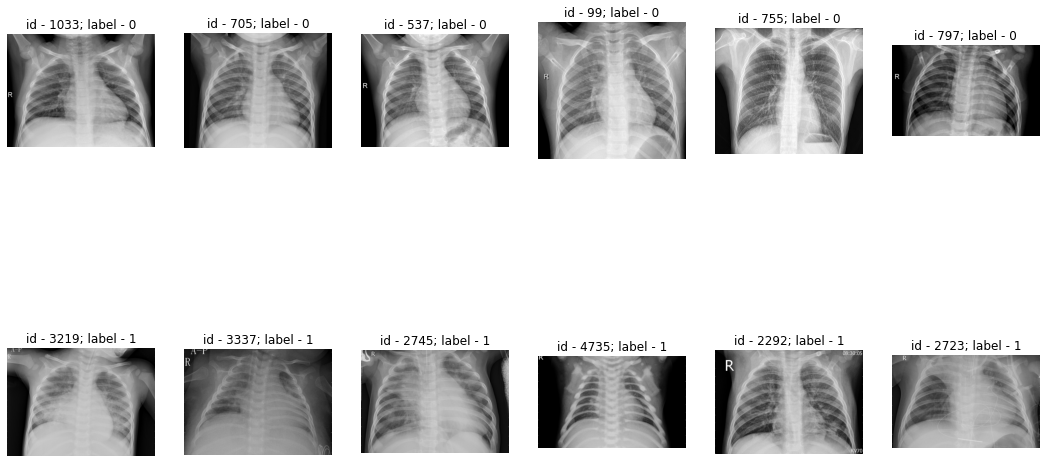

In [9]:
visualize_classes(dataset)

In [10]:
dataset = torchvision.datasets.ImageFolder(
    root=dataset_path, 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [11]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

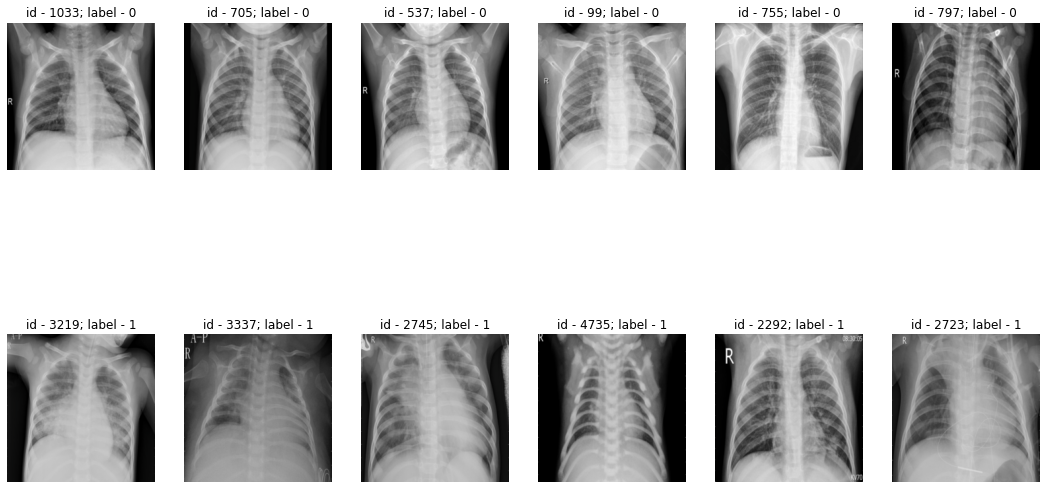

In [12]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [13]:
device = "cuda:0"
# device = "cpu"

In [14]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=2
)

### Load model

In [16]:
save_path = "../models/6.1_resnet_noise_aug_2021-04-13_04:07:43.pt"

In [17]:
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Analyze results

In [18]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 74/74 [00:07<00:00, 10.10it/s]


In [19]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [20]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [21]:
df["error_type"] = df.apply(error_class, axis=1)

In [22]:
df.groupby("error_type").count()

true  pred  prob
error_type                  
FN            10    10    10
FP            79    79    79
TN           228   228   228
TP           855   855   855

In [23]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.924061433447099
average_precision_score - 0.9133671201422556


In [24]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [25]:
df

true  pred      prob error_type
0        1     1  0.997144         TP
1        1     1  0.999653         TP
2        1     1  0.999719         TP
3        1     1  0.999561         TP
4        0     0  0.285987         TN
...    ...   ...       ...        ...
1167     0     1  0.998183         FP
1168     1     1  0.999632         TP
1169     1     1  0.999354         TP
1170     0     0  0.000871         TN
1171     0     0  0.000135         TN

[1172 rows x 4 columns]

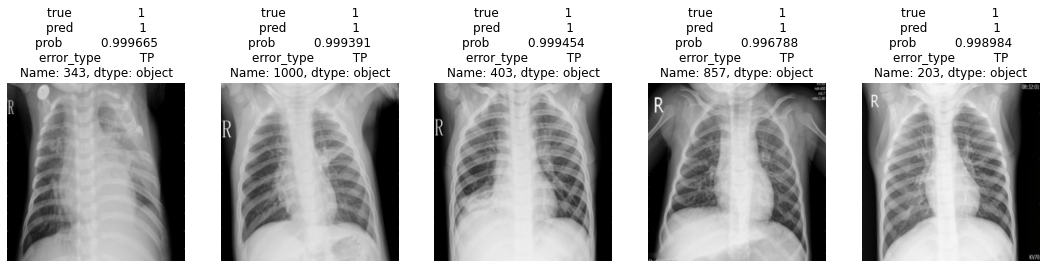

In [26]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

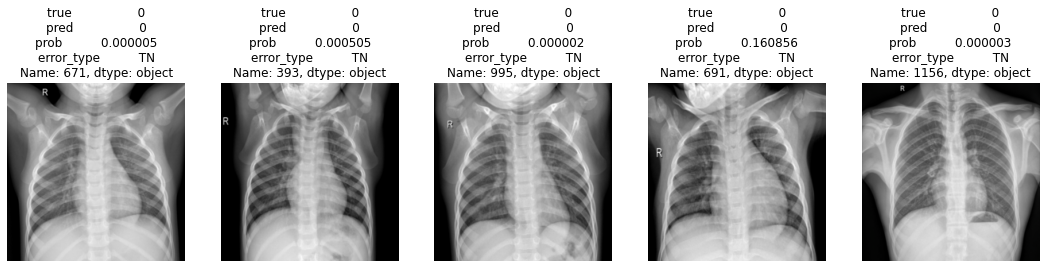

In [27]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

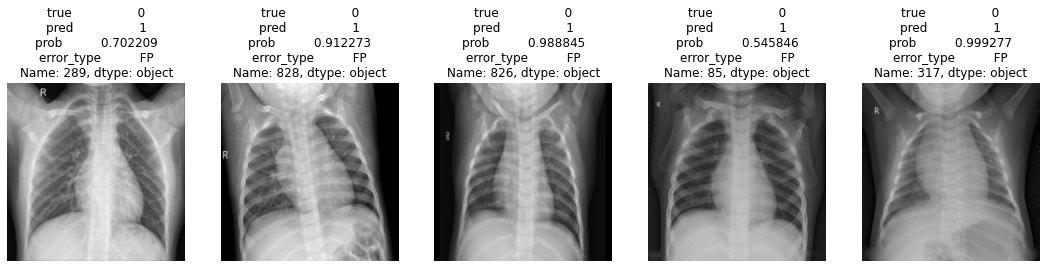

In [28]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

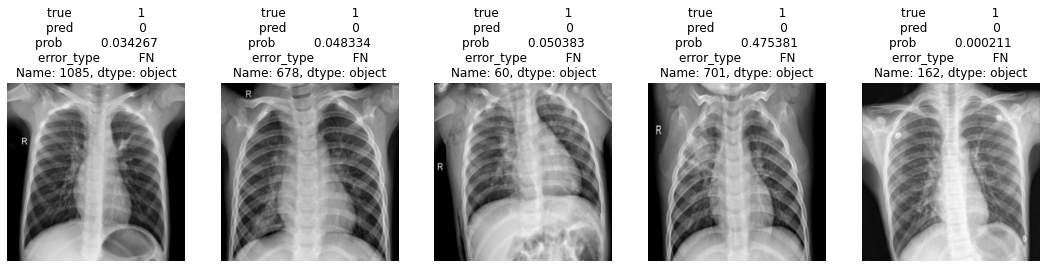

In [29]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Attacks

In [30]:
# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

In [31]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

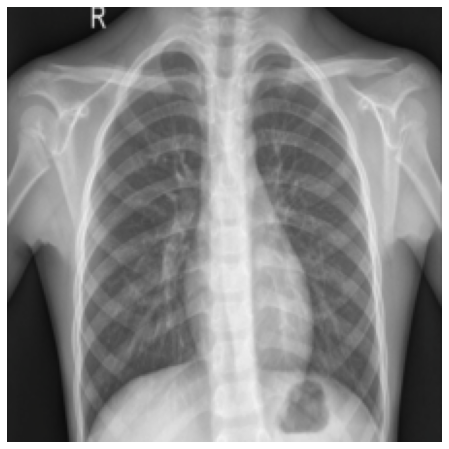

0.001022242

In [32]:
img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

#### Art wrapper

In [33]:
from art.estimators.classification import PyTorchClassifier

In [34]:
art_classifier = PyTorchClassifier(
    model=model, 
    loss=nn.CrossEntropyLoss(), 
    input_shape=(3, 244, 244), 
    nb_classes=2
)

In [35]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
output = art_classifier.predict(image)[0, 1]
print(output)

0.001022242


#### Loss gradient 

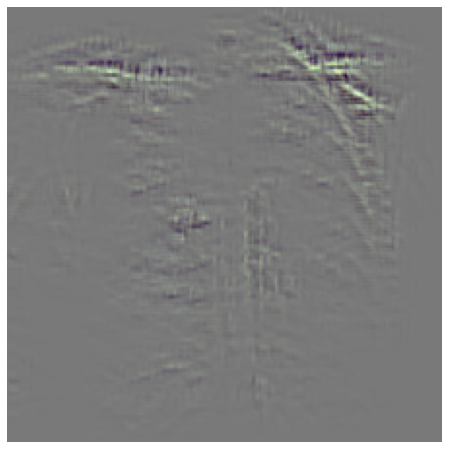

In [36]:
loss_gradient = art_classifier.loss_gradient(x=image, y=to_categorical([1], nb_classes=2))[0].permute(1, 2, 0).cpu().numpy()

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8))
plt.imshow(loss_gradient_plot)
plt.axis('off')
plt.show()

In [37]:
def norms(image, image_adv):
    img_original = inv_normalize(torch.tensor(image[0].cpu())).numpy() * 255
    img_adv = inv_normalize(torch.tensor(image_adv[0])).numpy() * 255

    l_0 = int(99*len(np.where(np.abs(img_original - img_adv)>0.5)[0]) / (224*224*3)) + 1   
    l_1 = int(99*np.sum(np.abs(img_original - img_adv)) / np.sum(np.abs(img_original))) + 1
    l_2 = int(99*np.linalg.norm(img_original - img_adv) / np.linalg.norm(img_original)) + 1 
    l_inf = int(99*np.max(np.abs(img_original - img_adv)) / 255) + 1

    print('Perturbation l_0 norm: %d%%' % l_0)
    print('Perturbation l_1 norm: %d%%' % l_1)
    print('Perturbation l_2 norm: %d%%' % l_2)
    print('Noise l_inf norm: %d%%' % l_inf)

    # Let's also plot the absolute amount of adversarial pixel perturbations:
    pert = img_original - img_adv
    pert_min = np.min(pert)
    pert_max = np.max(pert)

    plt.figure(figsize=(8,8))
    img_to_show = (pert - pert_min) / (pert_max - pert_min)
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

### Metrics

#### Original data

In [38]:
def get_misclassification_rate(df):
    errors = df.groupby("error_type").count().T.iloc[0]
    misclassification_rate = (errors["FP"] + errors["FN"]) / errors.sum() * 100
    return misclassification_rate

In [39]:
def get_robustness_to_gaussian_blur(df_blur, df_orig):
    robustness_to_gaussian_blur = len(df_blur[df_blur["pred"]!=df_blur["true"]]) / len(df_orig[df_orig["pred"]!=df_orig["true"]])
    return robustness_to_gaussian_blur

In [40]:
def get_av_ssim(orig_images, adv_images):
    values = []
    for i in tqdm(range(len(orig_images))):
        values.append(ssim(np.transpose(orig_images[i], (1, 2, 0)), np.transpose(adv_images[i], (1, 2, 0)), multichannel=True))
    return np.mean(values)

In [41]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [42]:
def get_preds(adv = None, batch_size=1, blur=False, max_iter=None):
    prob = []
    pred = []
    true = []
    images = []
    original_images = []
    
    if max_iter is not None:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=True, num_workers=1
        )
    else:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=1
        )
    blur_transform = transforms.GaussianBlur(3)
    counter = 0
    for image, label in tqdm(loader, total=max_iter if max_iter is not None else len(loader)):
        if max_iter is not None:
            original_images.append(np.array(image[0]).copy())
        if adv is not None:
            image = adv.generate(image.cpu(), y=to_categorical([1-label], nb_classes=2))
        if blur:
            for i in range(image.shape[0]):
                image[i] = blur_transform(torch.Tensor(image[i]))
        pred_adv = art_classifier.predict(image)[:,1].reshape(-1)
        prob.extend(list(pred_adv))
        pred.extend(list((pred_adv > 0.5).astype(int)))
        true.extend(list(label.numpy().reshape(-1)))
        images.append(np.array(image[0]))
        if max_iter is not None:
            counter += 1
            if counter >= max_iter:
                break

    df = pd.DataFrame({"prob":prob, "pred":pred, "true":true})
    df["error_type"] = df.apply(error_class, axis=1)
    if max_iter is not None:
        return df, np.array(images), np.array(original_images)
    else:
        return df, np.array(images)

In [43]:
df_orig, orig_images = get_preds()

100%|██████████| 1172/1172 [00:12<00:00, 95.61it/s] 


In [44]:
misclassification_rate = get_misclassification_rate(df_orig)
misclassification_rate

7.593856655290103

In [45]:
df_orig_blur, orig_blur_images = get_preds(blur=True)

100%|██████████| 1172/1172 [00:16<00:00, 72.68it/s]


In [46]:
robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_orig_blur, df_orig)
robustness_to_gaussian_blur

1.404494382022472

In [47]:
misclassification_rate = get_misclassification_rate(df_orig_blur)
misclassification_rate

10.665529010238908

In [48]:
average_ssim = get_av_ssim(orig_images, orig_blur_images)
average_ssim

100%|██████████| 1172/1172 [00:06<00:00, 191.90it/s]


0.9738353720692396

#### ProjectedGradientDescent

In [60]:
adv = ProjectedGradientDescent(art_classifier, targeted=True, max_iter=50, eps_step=1, eps=0.02)

In [61]:
df_pgd, pgd_images = get_preds(adv, batch_size=1)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:00<18:16,  1.07it/s]

  0%|          | 2/1172 [00:01<17:45,  1.10it/s]

  0%|          | 3/1172 [00:02<17:32,  1.11it/s]

  0%|          | 4/1172 [00:03<17:17,  1.13it/s]

  0%|          | 5/1172 [00:04<17:12,  1.13it/s]

  1%|          | 6/1172 [00:05<17:08,  1.13it/s]

  1%|          | 7/1172 [00:06<17:00,  1.14it/s]

  1%|          | 8/1172 [00:07<17:00,  1.14it/s]

  1%|          | 9/1172 [00:07<16:59,  1.14it/s]

  1%|          | 10/1172 [00:08<16:59,  1.14it/s]

  1%|          | 11/1172 [00:09<16:57,  1.14it/s]

  1%|          | 12/1172 [00:10<16:50,  1.15it/s]

  1%|          | 13/1172 [00:11<16:51,  1.15it/s]

  1%|          | 14/1172 [00:12<16:46,  1.15it/s]

  1%|▏         | 15/1172 [00:13<16:51,  1.14it/s]

  1%|▏         | 16/1172 [00:14<16:50,  1.14it/s]

  1%|▏         | 17/1172 [00:14<16:44,  1.15it/s]

  2%|▏         | 18/1172 [00:15<16:48,  1.14it/s]

  2%|▏         | 19/1172 [00:16<16:42,  1.15it/s]

  2%|▏         | 20/1172 [00:17<16:34,  1.16it/s]

  2%|▏         | 21/1172 [00:18<16:44,  1.15it/s]

  2%|▏         | 22/1172 [00:19<16:44,  1.14it/s]

  2%|▏         | 23/1172 [00:20<16:45,  1.14it/s]

  2%|▏         | 24/1172 [00:20<16:45,  1.14it/s]

  2%|▏         | 25/1172 [00:21<16:38,  1.15it/s]

  2%|▏         | 26/1172 [00:22<16:45,  1.14it/s]

  2%|▏         | 27/1172 [00:23<16:41,  1.14it/s]

  2%|▏         | 28/1172 [00:24<16:43,  1.14it/s]

  2%|▏         | 29/1172 [00:25<16:38,  1.15it/s]

  3%|▎         | 30/1172 [00:26<16:35,  1.15it/s]

  3%|▎         | 31/1172 [00:27<16:39,  1.14it/s]

  3%|▎         | 32/1172 [00:27<16:33,  1.15it/s]

  3%|▎         | 33/1172 [00:28<16:30,  1.15it/s]

  3%|▎         | 34/1172 [00:29<16:42,  1.14it/s]

  3%|▎         | 35/1172 [00:30<16:34,  1.14it/s]

  3%|▎         | 36/1172 [00:31<16:36,  1.14it/s]

  3%|▎         | 37/1172 [00:32<16:29,  1.15it/s]

  3%|▎         | 38/1172 [00:33<16:24,  1.15it/s]

  3%|▎         | 39/1172 [00:34<16:27,  1.15it/s]

  3%|▎         | 40/1172 [00:34<16:22,  1.15it/s]

  3%|▎         | 41/1172 [00:35<16:27,  1.15it/s]

  4%|▎         | 42/1172 [00:36<16:25,  1.15it/s]

  4%|▎         | 43/1172 [00:37<16:20,  1.15it/s]

  4%|▍         | 44/1172 [00:38<16:28,  1.14it/s]

  4%|▍         | 45/1172 [00:39<16:27,  1.14it/s]

  4%|▍         | 46/1172 [00:40<16:26,  1.14it/s]

  4%|▍         | 47/1172 [00:41<16:27,  1.14it/s]

  4%|▍         | 48/1172 [00:41<16:23,  1.14it/s]

  4%|▍         | 49/1172 [00:42<16:25,  1.14it/s]

  4%|▍         | 50/1172 [00:43<16:21,  1.14it/s]

  4%|▍         | 51/1172 [00:44<16:09,  1.16it/s]

  4%|▍         | 52/1172 [00:45<16:20,  1.14it/s]

  5%|▍         | 53/1172 [00:46<16:14,  1.15it/s]

  5%|▍         | 54/1172 [00:47<16:15,  1.15it/s]

  5%|▍         | 55/1172 [00:48<16:15,  1.15it/s]

  5%|▍         | 56/1172 [00:48<16:09,  1.15it/s]

  5%|▍         | 57/1172 [00:49<16:16,  1.14it/s]

  5%|▍         | 58/1172 [00:50<16:10,  1.15it/s]

  5%|▌         | 59/1172 [00:51<16:11,  1.15it/s]

  5%|▌         | 60/1172 [00:52<16:08,  1.15it/s]

  5%|▌         | 61/1172 [00:53<16:03,  1.15it/s]

  5%|▌         | 62/1172 [00:54<16:08,  1.15it/s]

  5%|▌         | 63/1172 [00:55<16:03,  1.15it/s]

  5%|▌         | 64/1172 [00:55<16:01,  1.15it/s]

  6%|▌         | 65/1172 [00:56<16:13,  1.14it/s]

  6%|▌         | 66/1172 [00:57<16:06,  1.14it/s]

  6%|▌         | 67/1172 [00:58<16:08,  1.14it/s]

  6%|▌         | 68/1172 [00:59<16:05,  1.14it/s]

  6%|▌         | 69/1172 [01:00<15:59,  1.15it/s]

  6%|▌         | 70/1172 [01:01<16:03,  1.14it/s]

  6%|▌         | 71/1172 [01:01<15:57,  1.15it/s]

  6%|▌         | 72/1172 [01:02<15:59,  1.15it/s]

  6%|▌         | 73/1172 [01:03<15:59,  1.15it/s]

  6%|▋         | 74/1172 [01:04<15:54,  1.15it/s]

  6%|▋         | 75/1172 [01:05<16:00,  1.14it/s]

  6%|▋         | 76/1172 [01:06<15:54,  1.15it/s]

  7%|▋         | 77/1172 [01:07<15:56,  1.15it/s]

  7%|▋         | 78/1172 [01:08<15:58,  1.14it/s]

  7%|▋         | 79/1172 [01:08<15:55,  1.14it/s]

  7%|▋         | 80/1172 [01:09<15:58,  1.14it/s]

  7%|▋         | 81/1172 [01:10<15:54,  1.14it/s]

  7%|▋         | 82/1172 [01:11<15:48,  1.15it/s]

  7%|▋         | 83/1172 [01:12<15:52,  1.14it/s]

  7%|▋         | 84/1172 [01:13<15:46,  1.15it/s]

  7%|▋         | 85/1172 [01:14<15:48,  1.15it/s]

  7%|▋         | 86/1172 [01:15<15:48,  1.14it/s]

  7%|▋         | 87/1172 [01:15<15:42,  1.15it/s]

  8%|▊         | 88/1172 [01:16<15:44,  1.15it/s]

  8%|▊         | 89/1172 [01:17<15:39,  1.15it/s]

  8%|▊         | 90/1172 [01:18<15:44,  1.15it/s]

  8%|▊         | 91/1172 [01:19<15:49,  1.14it/s]

  8%|▊         | 92/1172 [01:20<15:42,  1.15it/s]

  8%|▊         | 93/1172 [01:21<15:45,  1.14it/s]

  8%|▊         | 94/1172 [01:22<15:38,  1.15it/s]

  8%|▊         | 95/1172 [01:22<15:30,  1.16it/s]

  8%|▊         | 96/1172 [01:23<15:35,  1.15it/s]

  8%|▊         | 97/1172 [01:24<15:30,  1.15it/s]

  8%|▊         | 98/1172 [01:25<15:33,  1.15it/s]

  8%|▊         | 99/1172 [01:26<15:34,  1.15it/s]

  9%|▊         | 100/1172 [01:27<15:29,  1.15it/s]

  9%|▊         | 101/1172 [01:28<15:36,  1.14it/s]

  9%|▊         | 102/1172 [01:29<15:30,  1.15it/s]

  9%|▉         | 103/1172 [01:29<15:32,  1.15it/s]

  9%|▉         | 104/1172 [01:30<15:33,  1.14it/s]

  9%|▉         | 105/1172 [01:31<15:27,  1.15it/s]

  9%|▉         | 106/1172 [01:32<15:34,  1.14it/s]

  9%|▉         | 107/1172 [01:33<15:27,  1.15it/s]

  9%|▉         | 108/1172 [01:34<15:28,  1.15it/s]

  9%|▉         | 109/1172 [01:35<15:30,  1.14it/s]

  9%|▉         | 110/1172 [01:36<15:24,  1.15it/s]

  9%|▉         | 111/1172 [01:36<15:26,  1.15it/s]

 10%|▉         | 112/1172 [01:37<15:21,  1.15it/s]

 10%|▉         | 113/1172 [01:38<15:12,  1.16it/s]

 10%|▉         | 114/1172 [01:39<15:22,  1.15it/s]

 10%|▉         | 115/1172 [01:40<15:20,  1.15it/s]

 10%|▉         | 116/1172 [01:41<15:24,  1.14it/s]

 10%|▉         | 117/1172 [01:42<15:21,  1.14it/s]

 10%|█         | 118/1172 [01:42<15:16,  1.15it/s]

 10%|█         | 119/1172 [01:43<15:22,  1.14it/s]

 10%|█         | 120/1172 [01:44<15:17,  1.15it/s]

 10%|█         | 121/1172 [01:45<15:20,  1.14it/s]

 10%|█         | 122/1172 [01:46<15:22,  1.14it/s]

 10%|█         | 123/1172 [01:47<15:15,  1.15it/s]

 11%|█         | 124/1172 [01:48<15:16,  1.14it/s]

 11%|█         | 125/1172 [01:49<15:11,  1.15it/s]

 11%|█         | 126/1172 [01:49<15:08,  1.15it/s]

 11%|█         | 127/1172 [01:50<15:15,  1.14it/s]

 11%|█         | 128/1172 [01:51<15:09,  1.15it/s]

 11%|█         | 129/1172 [01:52<15:10,  1.15it/s]

 11%|█         | 130/1172 [01:53<15:10,  1.14it/s]

 11%|█         | 131/1172 [01:54<15:05,  1.15it/s]

 11%|█▏        | 132/1172 [01:55<15:11,  1.14it/s]

 11%|█▏        | 133/1172 [01:56<15:05,  1.15it/s]

 11%|█▏        | 134/1172 [01:56<15:05,  1.15it/s]

 12%|█▏        | 135/1172 [01:57<15:05,  1.14it/s]

 12%|█▏        | 136/1172 [01:58<15:00,  1.15it/s]

 12%|█▏        | 137/1172 [01:59<15:07,  1.14it/s]

 12%|█▏        | 138/1172 [02:00<15:03,  1.14it/s]

 12%|█▏        | 139/1172 [02:01<15:02,  1.14it/s]

 12%|█▏        | 140/1172 [02:02<15:10,  1.13it/s]

 12%|█▏        | 141/1172 [02:03<15:02,  1.14it/s]

 12%|█▏        | 142/1172 [02:03<15:02,  1.14it/s]

 12%|█▏        | 143/1172 [02:04<14:56,  1.15it/s]

 12%|█▏        | 144/1172 [02:05<14:51,  1.15it/s]

 12%|█▏        | 145/1172 [02:06<14:56,  1.15it/s]

 12%|█▏        | 146/1172 [02:07<14:51,  1.15it/s]

 13%|█▎        | 147/1172 [02:08<14:53,  1.15it/s]

 13%|█▎        | 148/1172 [02:09<14:49,  1.15it/s]

 13%|█▎        | 149/1172 [02:10<14:45,  1.15it/s]

 13%|█▎        | 150/1172 [02:10<14:53,  1.14it/s]

 13%|█▎        | 151/1172 [02:11<14:53,  1.14it/s]

 13%|█▎        | 152/1172 [02:12<14:53,  1.14it/s]

 13%|█▎        | 153/1172 [02:13<14:52,  1.14it/s]

 13%|█▎        | 154/1172 [02:14<14:46,  1.15it/s]

 13%|█▎        | 155/1172 [02:15<14:47,  1.15it/s]

 13%|█▎        | 156/1172 [02:16<14:42,  1.15it/s]

 13%|█▎        | 157/1172 [02:17<14:39,  1.15it/s]

 13%|█▎        | 158/1172 [02:17<14:45,  1.15it/s]

 14%|█▎        | 159/1172 [02:18<14:40,  1.15it/s]

 14%|█▎        | 160/1172 [02:19<14:42,  1.15it/s]

 14%|█▎        | 161/1172 [02:20<14:43,  1.14it/s]

 14%|█▍        | 162/1172 [02:21<14:37,  1.15it/s]

 14%|█▍        | 163/1172 [02:22<14:44,  1.14it/s]

 14%|█▍        | 164/1172 [02:23<14:38,  1.15it/s]

 14%|█▍        | 165/1172 [02:24<14:39,  1.15it/s]

 14%|█▍        | 166/1172 [02:24<14:33,  1.15it/s]

 14%|█▍        | 167/1172 [02:25<14:30,  1.15it/s]

 14%|█▍        | 168/1172 [02:26<14:37,  1.14it/s]

 14%|█▍        | 169/1172 [02:27<14:32,  1.15it/s]

 15%|█▍        | 170/1172 [02:28<14:35,  1.14it/s]

 15%|█▍        | 171/1172 [02:29<14:34,  1.14it/s]

 15%|█▍        | 172/1172 [02:30<14:29,  1.15it/s]

 15%|█▍        | 173/1172 [02:30<14:33,  1.14it/s]

 15%|█▍        | 174/1172 [02:31<14:27,  1.15it/s]

 15%|█▍        | 175/1172 [02:32<14:20,  1.16it/s]

 15%|█▌        | 176/1172 [02:33<14:25,  1.15it/s]

 15%|█▌        | 177/1172 [02:34<14:21,  1.15it/s]

 15%|█▌        | 178/1172 [02:35<14:24,  1.15it/s]

 15%|█▌        | 179/1172 [02:36<14:21,  1.15it/s]

 15%|█▌        | 180/1172 [02:37<14:17,  1.16it/s]

 15%|█▌        | 181/1172 [02:37<14:24,  1.15it/s]

 16%|█▌        | 182/1172 [02:38<14:23,  1.15it/s]

 16%|█▌        | 183/1172 [02:39<14:23,  1.15it/s]

 16%|█▌        | 184/1172 [02:40<14:23,  1.14it/s]

 16%|█▌        | 185/1172 [02:41<14:20,  1.15it/s]

 16%|█▌        | 186/1172 [02:42<14:23,  1.14it/s]

 16%|█▌        | 187/1172 [02:43<14:17,  1.15it/s]

 16%|█▌        | 188/1172 [02:44<14:18,  1.15it/s]

 16%|█▌        | 189/1172 [02:44<14:23,  1.14it/s]

 16%|█▌        | 190/1172 [02:45<14:16,  1.15it/s]

 16%|█▋        | 191/1172 [02:46<14:19,  1.14it/s]

 16%|█▋        | 192/1172 [02:47<14:16,  1.14it/s]

 16%|█▋        | 193/1172 [02:48<14:11,  1.15it/s]

 17%|█▋        | 194/1172 [02:49<14:15,  1.14it/s]

 17%|█▋        | 195/1172 [02:50<14:09,  1.15it/s]

 17%|█▋        | 196/1172 [02:51<14:11,  1.15it/s]

 17%|█▋        | 197/1172 [02:51<14:12,  1.14it/s]

 17%|█▋        | 198/1172 [02:52<14:09,  1.15it/s]

 17%|█▋        | 199/1172 [02:53<14:12,  1.14it/s]

 17%|█▋        | 200/1172 [02:54<14:06,  1.15it/s]

 17%|█▋        | 201/1172 [02:55<14:08,  1.14it/s]

 17%|█▋        | 202/1172 [02:56<14:08,  1.14it/s]

 17%|█▋        | 203/1172 [02:57<14:03,  1.15it/s]

 17%|█▋        | 204/1172 [02:57<14:05,  1.15it/s]

 17%|█▋        | 205/1172 [02:58<14:00,  1.15it/s]

 18%|█▊        | 206/1172 [02:59<13:58,  1.15it/s]

 18%|█▊        | 207/1172 [03:00<14:04,  1.14it/s]

 18%|█▊        | 208/1172 [03:01<13:59,  1.15it/s]

 18%|█▊        | 209/1172 [03:02<14:02,  1.14it/s]

 18%|█▊        | 210/1172 [03:03<13:57,  1.15it/s]

 18%|█▊        | 211/1172 [03:04<13:53,  1.15it/s]

 18%|█▊        | 212/1172 [03:04<14:00,  1.14it/s]

 18%|█▊        | 213/1172 [03:05<13:54,  1.15it/s]

 18%|█▊        | 214/1172 [03:06<13:56,  1.15it/s]

 18%|█▊        | 215/1172 [03:07<13:48,  1.15it/s]

 18%|█▊        | 216/1172 [03:07<11:40,  1.36it/s]

 19%|█▊        | 217/1172 [03:08<10:10,  1.56it/s]

 19%|█▊        | 218/1172 [03:08<09:08,  1.74it/s]

 19%|█▊        | 219/1172 [03:09<08:24,  1.89it/s]

 19%|█▉        | 220/1172 [03:09<07:53,  2.01it/s]

 19%|█▉        | 221/1172 [03:10<07:27,  2.12it/s]

 19%|█▉        | 222/1172 [03:10<06:56,  2.28it/s]

 19%|█▉        | 223/1172 [03:10<06:34,  2.41it/s]

 19%|█▉        | 224/1172 [03:11<06:32,  2.41it/s]

 19%|█▉        | 225/1172 [03:11<06:34,  2.40it/s]

 19%|█▉        | 226/1172 [03:11<06:13,  2.53it/s]

 19%|█▉        | 227/1172 [03:12<05:58,  2.63it/s]

 19%|█▉        | 228/1172 [03:12<05:48,  2.71it/s]

 20%|█▉        | 229/1172 [03:13<05:46,  2.73it/s]

 20%|█▉        | 230/1172 [03:13<05:39,  2.78it/s]

 20%|█▉        | 231/1172 [03:13<05:55,  2.65it/s]

 20%|█▉        | 232/1172 [03:14<05:46,  2.72it/s]

 20%|█▉        | 233/1172 [03:14<05:39,  2.77it/s]

 20%|█▉        | 234/1172 [03:14<05:38,  2.77it/s]

 20%|██        | 235/1172 [03:15<05:39,  2.76it/s]

 20%|██        | 236/1172 [03:15<05:39,  2.75it/s]

 20%|██        | 237/1172 [03:15<05:39,  2.75it/s]

 20%|██        | 238/1172 [03:16<05:39,  2.75it/s]

 20%|██        | 239/1172 [03:16<05:45,  2.70it/s]

 20%|██        | 240/1172 [03:17<05:42,  2.72it/s]

 21%|██        | 241/1172 [03:17<05:42,  2.72it/s]

 21%|██        | 242/1172 [03:17<05:42,  2.72it/s]

 21%|██        | 243/1172 [03:18<05:41,  2.72it/s]

 21%|██        | 244/1172 [03:18<05:41,  2.72it/s]

 21%|██        | 245/1172 [03:18<05:40,  2.72it/s]

 21%|██        | 246/1172 [03:19<05:41,  2.71it/s]

 21%|██        | 247/1172 [03:19<05:40,  2.71it/s]

 21%|██        | 248/1172 [03:19<05:40,  2.72it/s]

 21%|██        | 249/1172 [03:20<05:39,  2.72it/s]

 21%|██▏       | 250/1172 [03:20<05:39,  2.72it/s]

 21%|██▏       | 251/1172 [03:21<05:38,  2.72it/s]

 22%|██▏       | 252/1172 [03:21<05:38,  2.72it/s]

 22%|██▏       | 253/1172 [03:21<05:37,  2.72it/s]

 22%|██▏       | 254/1172 [03:22<05:35,  2.74it/s]

 22%|██▏       | 255/1172 [03:22<05:30,  2.77it/s]

 22%|██▏       | 256/1172 [03:22<05:25,  2.81it/s]

 22%|██▏       | 257/1172 [03:23<05:22,  2.84it/s]

 22%|██▏       | 258/1172 [03:23<05:19,  2.86it/s]

 22%|██▏       | 259/1172 [03:23<05:17,  2.88it/s]

 22%|██▏       | 260/1172 [03:24<05:16,  2.88it/s]

 22%|██▏       | 261/1172 [03:24<05:16,  2.88it/s]

 22%|██▏       | 262/1172 [03:24<05:16,  2.88it/s]

 22%|██▏       | 263/1172 [03:25<05:15,  2.88it/s]

 23%|██▎       | 264/1172 [03:25<05:16,  2.87it/s]

 23%|██▎       | 265/1172 [03:26<05:15,  2.87it/s]

 23%|██▎       | 266/1172 [03:26<05:15,  2.87it/s]

 23%|██▎       | 267/1172 [03:26<05:15,  2.87it/s]

 23%|██▎       | 268/1172 [03:27<05:14,  2.87it/s]

 23%|██▎       | 269/1172 [03:27<05:14,  2.87it/s]

 23%|██▎       | 270/1172 [03:27<05:14,  2.87it/s]

 23%|██▎       | 271/1172 [03:28<05:11,  2.89it/s]

 23%|██▎       | 272/1172 [03:28<05:06,  2.94it/s]

 23%|██▎       | 273/1172 [03:28<05:02,  2.97it/s]

 23%|██▎       | 274/1172 [03:29<04:59,  2.99it/s]

 23%|██▎       | 275/1172 [03:29<04:57,  3.01it/s]

 24%|██▎       | 276/1172 [03:29<04:56,  3.02it/s]

 24%|██▎       | 277/1172 [03:30<04:55,  3.03it/s]

 24%|██▎       | 278/1172 [03:30<04:54,  3.04it/s]

 24%|██▍       | 279/1172 [03:30<04:53,  3.04it/s]

 24%|██▍       | 280/1172 [03:31<04:53,  3.04it/s]

 24%|██▍       | 281/1172 [03:31<04:52,  3.04it/s]

 24%|██▍       | 282/1172 [03:31<04:52,  3.05it/s]

 24%|██▍       | 283/1172 [03:32<04:51,  3.05it/s]

 24%|██▍       | 284/1172 [03:32<04:51,  3.05it/s]

 24%|██▍       | 285/1172 [03:32<04:51,  3.05it/s]

 24%|██▍       | 286/1172 [03:33<04:50,  3.05it/s]

 24%|██▍       | 287/1172 [03:33<04:50,  3.05it/s]

 25%|██▍       | 288/1172 [03:33<04:50,  3.05it/s]

 25%|██▍       | 289/1172 [03:33<04:49,  3.05it/s]

 25%|██▍       | 290/1172 [03:34<04:49,  3.05it/s]

 25%|██▍       | 291/1172 [03:34<04:49,  3.05it/s]

 25%|██▍       | 292/1172 [03:34<04:48,  3.05it/s]

 25%|██▌       | 293/1172 [03:35<04:48,  3.05it/s]

 25%|██▌       | 294/1172 [03:35<04:47,  3.05it/s]

 25%|██▌       | 295/1172 [03:35<04:47,  3.05it/s]

 25%|██▌       | 296/1172 [03:36<04:47,  3.05it/s]

 25%|██▌       | 297/1172 [03:36<04:46,  3.05it/s]

 25%|██▌       | 298/1172 [03:36<04:46,  3.05it/s]

 26%|██▌       | 299/1172 [03:37<04:46,  3.05it/s]

 26%|██▌       | 300/1172 [03:37<04:46,  3.05it/s]

 26%|██▌       | 301/1172 [03:37<04:45,  3.05it/s]

 26%|██▌       | 302/1172 [03:38<04:45,  3.05it/s]

 26%|██▌       | 303/1172 [03:38<04:45,  3.05it/s]

 26%|██▌       | 304/1172 [03:38<04:44,  3.05it/s]

 26%|██▌       | 305/1172 [03:39<04:44,  3.05it/s]

 26%|██▌       | 306/1172 [03:39<04:49,  2.99it/s]

 26%|██▌       | 307/1172 [03:39<04:54,  2.94it/s]

 26%|██▋       | 308/1172 [03:40<04:56,  2.91it/s]

 26%|██▋       | 309/1172 [03:40<04:58,  2.89it/s]

 26%|██▋       | 310/1172 [03:40<04:59,  2.88it/s]

 27%|██▋       | 311/1172 [03:41<04:59,  2.87it/s]

 27%|██▋       | 312/1172 [03:41<04:59,  2.87it/s]

 27%|██▋       | 313/1172 [03:42<04:55,  2.91it/s]

 27%|██▋       | 314/1172 [03:42<04:52,  2.94it/s]

 27%|██▋       | 315/1172 [03:42<04:49,  2.96it/s]

 27%|██▋       | 316/1172 [03:43<04:48,  2.97it/s]

 27%|██▋       | 317/1172 [03:43<04:47,  2.98it/s]

 27%|██▋       | 318/1172 [03:43<04:45,  2.99it/s]

 27%|██▋       | 319/1172 [03:44<04:45,  2.99it/s]

 27%|██▋       | 320/1172 [03:44<04:44,  2.99it/s]

 27%|██▋       | 321/1172 [03:44<04:44,  3.00it/s]

 27%|██▋       | 322/1172 [03:45<04:43,  3.00it/s]

 28%|██▊       | 323/1172 [03:45<04:42,  3.00it/s]

 28%|██▊       | 324/1172 [03:45<04:42,  3.00it/s]

 28%|██▊       | 325/1172 [03:46<04:42,  3.00it/s]

 28%|██▊       | 326/1172 [03:46<04:42,  3.00it/s]

 28%|██▊       | 327/1172 [03:46<04:41,  3.00it/s]

 28%|██▊       | 328/1172 [03:47<04:41,  3.00it/s]

 28%|██▊       | 329/1172 [03:47<04:40,  3.00it/s]

 28%|██▊       | 330/1172 [03:47<04:40,  3.00it/s]

 28%|██▊       | 331/1172 [03:48<04:40,  3.00it/s]

 28%|██▊       | 332/1172 [03:48<04:39,  3.00it/s]

 28%|██▊       | 333/1172 [03:48<04:39,  3.00it/s]

 28%|██▊       | 334/1172 [03:49<04:39,  3.00it/s]

 29%|██▊       | 335/1172 [03:49<04:39,  3.00it/s]

 29%|██▊       | 336/1172 [03:49<04:38,  3.00it/s]

 29%|██▉       | 337/1172 [03:50<04:38,  3.00it/s]

 29%|██▉       | 338/1172 [03:50<04:38,  3.00it/s]

 29%|██▉       | 339/1172 [03:50<04:37,  3.00it/s]

 29%|██▉       | 340/1172 [03:51<04:37,  3.00it/s]

 29%|██▉       | 341/1172 [03:51<04:36,  3.00it/s]

 29%|██▉       | 342/1172 [03:51<04:36,  3.00it/s]

 29%|██▉       | 343/1172 [03:52<04:36,  3.00it/s]

 29%|██▉       | 344/1172 [03:52<04:36,  3.00it/s]

 29%|██▉       | 345/1172 [03:52<04:35,  3.00it/s]

 30%|██▉       | 346/1172 [03:53<04:35,  2.99it/s]

 30%|██▉       | 347/1172 [03:53<04:35,  2.99it/s]

 30%|██▉       | 348/1172 [03:53<04:35,  2.99it/s]

 30%|██▉       | 349/1172 [03:54<04:35,  2.98it/s]

 30%|██▉       | 350/1172 [03:54<04:35,  2.98it/s]

 30%|██▉       | 351/1172 [03:54<04:35,  2.98it/s]

 30%|███       | 352/1172 [03:55<04:36,  2.97it/s]

 30%|███       | 353/1172 [03:55<04:39,  2.93it/s]

 30%|███       | 354/1172 [03:55<04:42,  2.89it/s]

 30%|███       | 355/1172 [03:56<04:43,  2.88it/s]

 30%|███       | 356/1172 [03:56<04:43,  2.88it/s]

 30%|███       | 357/1172 [03:56<04:42,  2.88it/s]

 31%|███       | 358/1172 [03:57<04:41,  2.89it/s]

 31%|███       | 359/1172 [03:57<04:39,  2.91it/s]

 31%|███       | 360/1172 [03:57<04:37,  2.92it/s]

 31%|███       | 361/1172 [03:58<04:36,  2.93it/s]

 31%|███       | 362/1172 [03:58<04:35,  2.94it/s]

 31%|███       | 363/1172 [03:58<04:36,  2.93it/s]

 31%|███       | 364/1172 [03:59<04:37,  2.91it/s]

 31%|███       | 365/1172 [03:59<04:36,  2.92it/s]

 31%|███       | 366/1172 [03:59<04:34,  2.93it/s]

 31%|███▏      | 367/1172 [04:00<04:34,  2.94it/s]

 31%|███▏      | 368/1172 [04:00<04:33,  2.94it/s]

 31%|███▏      | 369/1172 [04:00<04:33,  2.94it/s]

 32%|███▏      | 370/1172 [04:01<04:32,  2.94it/s]

 32%|███▏      | 371/1172 [04:01<04:32,  2.94it/s]

 32%|███▏      | 372/1172 [04:01<04:32,  2.93it/s]

 32%|███▏      | 373/1172 [04:02<04:32,  2.93it/s]

 32%|███▏      | 374/1172 [04:02<04:34,  2.91it/s]

 32%|███▏      | 375/1172 [04:02<04:33,  2.91it/s]

 32%|███▏      | 376/1172 [04:03<04:33,  2.91it/s]

 32%|███▏      | 377/1172 [04:03<04:32,  2.91it/s]

 32%|███▏      | 378/1172 [04:03<04:32,  2.91it/s]

 32%|███▏      | 379/1172 [04:04<04:32,  2.91it/s]

 32%|███▏      | 380/1172 [04:04<04:31,  2.91it/s]

 33%|███▎      | 381/1172 [04:04<04:31,  2.91it/s]

 33%|███▎      | 382/1172 [04:05<04:30,  2.92it/s]

 33%|███▎      | 383/1172 [04:05<04:30,  2.91it/s]

 33%|███▎      | 384/1172 [04:06<04:30,  2.91it/s]

 33%|███▎      | 385/1172 [04:06<04:30,  2.91it/s]

 33%|███▎      | 386/1172 [04:06<04:29,  2.91it/s]

 33%|███▎      | 387/1172 [04:07<04:29,  2.91it/s]

 33%|███▎      | 388/1172 [04:07<04:28,  2.92it/s]

 33%|███▎      | 389/1172 [04:07<04:28,  2.91it/s]

 33%|███▎      | 390/1172 [04:08<04:28,  2.91it/s]

 33%|███▎      | 391/1172 [04:08<04:28,  2.91it/s]

 33%|███▎      | 392/1172 [04:08<04:29,  2.89it/s]

 34%|███▎      | 393/1172 [04:09<04:30,  2.88it/s]

 34%|███▎      | 394/1172 [04:09<04:30,  2.87it/s]

 34%|███▎      | 395/1172 [04:09<04:26,  2.91it/s]

 34%|███▍      | 396/1172 [04:10<04:23,  2.94it/s]

 34%|███▍      | 397/1172 [04:10<04:23,  2.94it/s]

 34%|███▍      | 398/1172 [04:10<04:21,  2.96it/s]

 34%|███▍      | 399/1172 [04:11<04:19,  2.98it/s]

 34%|███▍      | 400/1172 [04:11<04:18,  2.99it/s]

 34%|███▍      | 401/1172 [04:11<04:18,  2.98it/s]

 34%|███▍      | 402/1172 [04:12<04:19,  2.97it/s]

 34%|███▍      | 403/1172 [04:12<04:19,  2.97it/s]

 34%|███▍      | 404/1172 [04:12<04:19,  2.96it/s]

 35%|███▍      | 405/1172 [04:13<04:19,  2.95it/s]

 35%|███▍      | 406/1172 [04:13<04:19,  2.95it/s]

 35%|███▍      | 407/1172 [04:13<04:19,  2.95it/s]

 35%|███▍      | 408/1172 [04:14<04:18,  2.95it/s]

 35%|███▍      | 409/1172 [04:14<04:18,  2.95it/s]

 35%|███▍      | 410/1172 [04:14<04:19,  2.94it/s]

 35%|███▌      | 411/1172 [04:15<04:20,  2.92it/s]

 35%|███▌      | 412/1172 [04:15<04:20,  2.92it/s]

 35%|███▌      | 413/1172 [04:15<04:19,  2.92it/s]

 35%|███▌      | 414/1172 [04:16<04:19,  2.92it/s]

 35%|███▌      | 415/1172 [04:16<04:19,  2.92it/s]

 35%|███▌      | 416/1172 [04:16<04:18,  2.92it/s]

 36%|███▌      | 417/1172 [04:17<04:18,  2.92it/s]

 36%|███▌      | 418/1172 [04:17<04:18,  2.92it/s]

 36%|███▌      | 419/1172 [04:17<04:18,  2.92it/s]

 36%|███▌      | 420/1172 [04:18<04:17,  2.92it/s]

 36%|███▌      | 421/1172 [04:18<04:17,  2.92it/s]

 36%|███▌      | 422/1172 [04:18<04:17,  2.92it/s]

 36%|███▌      | 423/1172 [04:19<04:16,  2.92it/s]

 36%|███▌      | 424/1172 [04:19<04:16,  2.92it/s]

 36%|███▋      | 425/1172 [04:20<04:15,  2.92it/s]

 36%|███▋      | 426/1172 [04:20<04:15,  2.92it/s]

 36%|███▋      | 427/1172 [04:20<04:15,  2.92it/s]

 37%|███▋      | 428/1172 [04:21<04:14,  2.92it/s]

 37%|███▋      | 429/1172 [04:21<04:14,  2.92it/s]

 37%|███▋      | 430/1172 [04:21<04:14,  2.92it/s]

 37%|███▋      | 431/1172 [04:22<04:13,  2.92it/s]

 37%|███▋      | 432/1172 [04:22<04:13,  2.92it/s]

 37%|███▋      | 433/1172 [04:22<04:13,  2.92it/s]

 37%|███▋      | 434/1172 [04:23<04:12,  2.92it/s]

 37%|███▋      | 435/1172 [04:23<04:12,  2.92it/s]

 37%|███▋      | 436/1172 [04:23<04:12,  2.92it/s]

 37%|███▋      | 437/1172 [04:24<04:11,  2.92it/s]

 37%|███▋      | 438/1172 [04:24<04:11,  2.92it/s]

 37%|███▋      | 439/1172 [04:24<04:11,  2.92it/s]

 38%|███▊      | 440/1172 [04:25<04:10,  2.92it/s]

 38%|███▊      | 441/1172 [04:25<04:10,  2.92it/s]

 38%|███▊      | 442/1172 [04:25<04:10,  2.92it/s]

 38%|███▊      | 443/1172 [04:26<04:09,  2.92it/s]

 38%|███▊      | 444/1172 [04:26<04:09,  2.92it/s]

 38%|███▊      | 445/1172 [04:26<04:09,  2.92it/s]

 38%|███▊      | 446/1172 [04:27<04:08,  2.92it/s]

 38%|███▊      | 447/1172 [04:27<04:08,  2.92it/s]

 38%|███▊      | 448/1172 [04:27<04:07,  2.92it/s]

 38%|███▊      | 449/1172 [04:28<04:07,  2.92it/s]

 38%|███▊      | 450/1172 [04:28<04:09,  2.89it/s]

 38%|███▊      | 451/1172 [04:28<04:10,  2.88it/s]

 39%|███▊      | 452/1172 [04:29<04:10,  2.87it/s]

 39%|███▊      | 453/1172 [04:29<04:14,  2.82it/s]

 39%|███▊      | 454/1172 [04:30<04:16,  2.80it/s]

 39%|███▉      | 455/1172 [04:30<04:15,  2.80it/s]

 39%|███▉      | 456/1172 [04:30<04:14,  2.81it/s]

 39%|███▉      | 457/1172 [04:31<04:13,  2.82it/s]

 39%|███▉      | 458/1172 [04:31<04:12,  2.83it/s]

 39%|███▉      | 459/1172 [04:31<04:12,  2.83it/s]

 39%|███▉      | 460/1172 [04:32<04:11,  2.83it/s]

 39%|███▉      | 461/1172 [04:32<04:10,  2.83it/s]

 39%|███▉      | 462/1172 [04:32<04:13,  2.80it/s]

 40%|███▉      | 463/1172 [04:33<04:14,  2.79it/s]

 40%|███▉      | 464/1172 [04:33<04:14,  2.78it/s]

 40%|███▉      | 465/1172 [04:33<04:13,  2.79it/s]

 40%|███▉      | 466/1172 [04:34<04:12,  2.80it/s]

 40%|███▉      | 467/1172 [04:34<04:11,  2.80it/s]

 40%|███▉      | 468/1172 [04:35<04:11,  2.80it/s]

 40%|████      | 469/1172 [04:35<04:12,  2.79it/s]

 40%|████      | 470/1172 [04:35<04:12,  2.78it/s]

 40%|████      | 471/1172 [04:36<04:12,  2.78it/s]

 40%|████      | 472/1172 [04:36<04:10,  2.79it/s]

 40%|████      | 473/1172 [04:36<04:11,  2.78it/s]

 40%|████      | 474/1172 [04:37<04:08,  2.80it/s]

 41%|████      | 475/1172 [04:37<04:06,  2.82it/s]

 41%|████      | 476/1172 [04:37<04:04,  2.84it/s]

 41%|████      | 477/1172 [04:38<04:03,  2.86it/s]

 41%|████      | 478/1172 [04:38<04:02,  2.87it/s]

 41%|████      | 479/1172 [04:38<04:00,  2.88it/s]

 41%|████      | 480/1172 [04:39<04:00,  2.88it/s]

 41%|████      | 481/1172 [04:39<03:59,  2.88it/s]

 41%|████      | 482/1172 [04:39<03:58,  2.89it/s]

 41%|████      | 483/1172 [04:40<04:00,  2.87it/s]

 41%|████▏     | 484/1172 [04:40<03:59,  2.88it/s]

 41%|████▏     | 485/1172 [04:40<03:57,  2.89it/s]

 41%|████▏     | 486/1172 [04:41<03:56,  2.90it/s]

 42%|████▏     | 487/1172 [04:41<03:55,  2.90it/s]

 42%|████▏     | 488/1172 [04:42<03:56,  2.89it/s]

 42%|████▏     | 489/1172 [04:42<03:55,  2.90it/s]

 42%|████▏     | 490/1172 [04:42<03:54,  2.91it/s]

 42%|████▏     | 491/1172 [04:43<03:56,  2.87it/s]

 42%|████▏     | 492/1172 [04:43<03:56,  2.87it/s]

 42%|████▏     | 493/1172 [04:43<03:57,  2.86it/s]

 42%|████▏     | 494/1172 [04:44<03:55,  2.88it/s]

 42%|████▏     | 495/1172 [04:44<03:54,  2.89it/s]

 42%|████▏     | 496/1172 [04:44<03:55,  2.87it/s]

 42%|████▏     | 497/1172 [04:45<03:56,  2.86it/s]

 42%|████▏     | 498/1172 [04:45<03:55,  2.86it/s]

 43%|████▎     | 499/1172 [04:45<03:53,  2.88it/s]

 43%|████▎     | 500/1172 [04:46<03:52,  2.89it/s]

 43%|████▎     | 501/1172 [04:46<03:51,  2.90it/s]

 43%|████▎     | 502/1172 [04:46<03:50,  2.91it/s]

 43%|████▎     | 503/1172 [04:47<03:49,  2.91it/s]

 43%|████▎     | 504/1172 [04:47<03:49,  2.91it/s]

 43%|████▎     | 505/1172 [04:47<03:48,  2.92it/s]

 43%|████▎     | 506/1172 [04:48<03:48,  2.92it/s]

 43%|████▎     | 507/1172 [04:48<03:47,  2.92it/s]

 43%|████▎     | 508/1172 [04:48<03:47,  2.92it/s]

 43%|████▎     | 509/1172 [04:49<03:47,  2.92it/s]

 44%|████▎     | 510/1172 [04:49<03:46,  2.92it/s]

 44%|████▎     | 511/1172 [04:49<03:47,  2.91it/s]

 44%|████▎     | 512/1172 [04:50<03:46,  2.91it/s]

 44%|████▍     | 513/1172 [04:50<03:45,  2.92it/s]

 44%|████▍     | 514/1172 [04:50<03:45,  2.92it/s]

 44%|████▍     | 515/1172 [04:51<03:44,  2.92it/s]

 44%|████▍     | 516/1172 [04:51<03:44,  2.92it/s]

 44%|████▍     | 517/1172 [04:52<03:44,  2.92it/s]

 44%|████▍     | 518/1172 [04:52<03:43,  2.92it/s]

 44%|████▍     | 519/1172 [04:52<03:43,  2.92it/s]

 44%|████▍     | 520/1172 [04:53<03:43,  2.92it/s]

 44%|████▍     | 521/1172 [04:53<03:42,  2.92it/s]

 45%|████▍     | 522/1172 [04:53<03:42,  2.92it/s]

 45%|████▍     | 523/1172 [04:54<03:42,  2.92it/s]

 45%|████▍     | 524/1172 [04:54<03:42,  2.92it/s]

 45%|████▍     | 525/1172 [04:54<03:41,  2.92it/s]

 45%|████▍     | 526/1172 [04:55<03:41,  2.92it/s]

 45%|████▍     | 527/1172 [04:55<03:40,  2.92it/s]

 45%|████▌     | 528/1172 [04:55<03:40,  2.92it/s]

 45%|████▌     | 529/1172 [04:56<03:40,  2.91it/s]

 45%|████▌     | 530/1172 [04:56<03:40,  2.91it/s]

 45%|████▌     | 531/1172 [04:56<03:40,  2.91it/s]

 45%|████▌     | 532/1172 [04:57<03:39,  2.91it/s]

 45%|████▌     | 533/1172 [04:57<03:39,  2.91it/s]

 46%|████▌     | 534/1172 [04:57<03:39,  2.91it/s]

 46%|████▌     | 535/1172 [04:58<03:38,  2.91it/s]

 46%|████▌     | 536/1172 [04:58<03:38,  2.91it/s]

 46%|████▌     | 537/1172 [04:58<03:38,  2.91it/s]

 46%|████▌     | 538/1172 [04:59<03:37,  2.91it/s]

 46%|████▌     | 539/1172 [04:59<03:37,  2.91it/s]

 46%|████▌     | 540/1172 [04:59<03:37,  2.91it/s]

 46%|████▌     | 541/1172 [05:00<03:36,  2.91it/s]

 46%|████▌     | 542/1172 [05:00<03:36,  2.92it/s]

 46%|████▋     | 543/1172 [05:00<03:35,  2.92it/s]

 46%|████▋     | 544/1172 [05:01<03:35,  2.92it/s]

 47%|████▋     | 545/1172 [05:01<03:34,  2.92it/s]

 47%|████▋     | 546/1172 [05:01<03:34,  2.92it/s]

 47%|████▋     | 547/1172 [05:02<03:34,  2.92it/s]

 47%|████▋     | 548/1172 [05:02<03:33,  2.92it/s]

 47%|████▋     | 549/1172 [05:02<03:33,  2.92it/s]

 47%|████▋     | 550/1172 [05:03<03:32,  2.92it/s]

 47%|████▋     | 551/1172 [05:03<03:32,  2.92it/s]

 47%|████▋     | 552/1172 [05:03<03:31,  2.93it/s]

 47%|████▋     | 553/1172 [05:04<03:30,  2.94it/s]

 47%|████▋     | 554/1172 [05:04<03:30,  2.94it/s]

 47%|████▋     | 555/1172 [05:05<03:29,  2.94it/s]

 47%|████▋     | 556/1172 [05:05<03:29,  2.94it/s]

 48%|████▊     | 557/1172 [05:05<03:28,  2.94it/s]

 48%|████▊     | 558/1172 [05:06<03:28,  2.94it/s]

 48%|████▊     | 559/1172 [05:06<03:28,  2.94it/s]

 48%|████▊     | 560/1172 [05:06<03:27,  2.95it/s]

 48%|████▊     | 561/1172 [05:07<03:27,  2.95it/s]

 48%|████▊     | 562/1172 [05:07<03:27,  2.95it/s]

 48%|████▊     | 563/1172 [05:07<03:26,  2.95it/s]

 48%|████▊     | 564/1172 [05:08<03:26,  2.95it/s]

 48%|████▊     | 565/1172 [05:08<03:26,  2.95it/s]

 48%|████▊     | 566/1172 [05:08<03:25,  2.95it/s]

 48%|████▊     | 567/1172 [05:09<03:25,  2.95it/s]

 48%|████▊     | 568/1172 [05:09<03:24,  2.95it/s]

 49%|████▊     | 569/1172 [05:09<03:24,  2.95it/s]

 49%|████▊     | 570/1172 [05:10<03:24,  2.95it/s]

 49%|████▊     | 571/1172 [05:10<03:23,  2.95it/s]

 49%|████▉     | 572/1172 [05:10<03:23,  2.95it/s]

 49%|████▉     | 573/1172 [05:11<03:23,  2.95it/s]

 49%|████▉     | 574/1172 [05:11<03:22,  2.95it/s]

 49%|████▉     | 575/1172 [05:11<03:24,  2.91it/s]

 49%|████▉     | 576/1172 [05:12<03:26,  2.89it/s]

 49%|████▉     | 577/1172 [05:12<03:28,  2.86it/s]

 49%|████▉     | 578/1172 [05:12<03:27,  2.86it/s]

 49%|████▉     | 579/1172 [05:13<03:27,  2.85it/s]

 49%|████▉     | 580/1172 [05:13<03:27,  2.86it/s]

 50%|████▉     | 581/1172 [05:13<03:26,  2.87it/s]

 50%|████▉     | 582/1172 [05:14<03:25,  2.87it/s]

 50%|████▉     | 583/1172 [05:14<03:24,  2.88it/s]

 50%|████▉     | 584/1172 [05:14<03:24,  2.88it/s]

 50%|████▉     | 585/1172 [05:15<03:24,  2.88it/s]

 50%|█████     | 586/1172 [05:15<03:23,  2.88it/s]

 50%|█████     | 587/1172 [05:16<03:23,  2.88it/s]

 50%|█████     | 588/1172 [05:16<03:22,  2.88it/s]

 50%|█████     | 589/1172 [05:16<03:22,  2.87it/s]

 50%|█████     | 590/1172 [05:17<03:21,  2.89it/s]

 50%|█████     | 591/1172 [05:17<03:21,  2.89it/s]

 51%|█████     | 592/1172 [05:17<03:21,  2.88it/s]

 51%|█████     | 593/1172 [05:18<03:21,  2.87it/s]

 51%|█████     | 594/1172 [05:18<03:21,  2.87it/s]

 51%|█████     | 595/1172 [05:18<03:21,  2.86it/s]

 51%|█████     | 596/1172 [05:19<03:21,  2.86it/s]

 51%|█████     | 597/1172 [05:19<03:19,  2.88it/s]

 51%|█████     | 598/1172 [05:19<03:18,  2.89it/s]

 51%|█████     | 599/1172 [05:20<03:17,  2.90it/s]

 51%|█████     | 600/1172 [05:20<03:19,  2.87it/s]

 51%|█████▏    | 601/1172 [05:20<03:20,  2.85it/s]

 51%|█████▏    | 602/1172 [05:21<03:21,  2.83it/s]

 51%|█████▏    | 603/1172 [05:21<03:21,  2.82it/s]

 52%|█████▏    | 604/1172 [05:21<03:21,  2.81it/s]

 52%|█████▏    | 605/1172 [05:22<03:21,  2.81it/s]

 52%|█████▏    | 606/1172 [05:22<03:21,  2.80it/s]

 52%|█████▏    | 607/1172 [05:23<03:22,  2.79it/s]

 52%|█████▏    | 608/1172 [05:23<03:22,  2.79it/s]

 52%|█████▏    | 609/1172 [05:23<03:22,  2.78it/s]

 52%|█████▏    | 610/1172 [05:24<03:22,  2.78it/s]

 52%|█████▏    | 611/1172 [05:24<03:22,  2.77it/s]

 52%|█████▏    | 612/1172 [05:24<03:22,  2.77it/s]

 52%|█████▏    | 613/1172 [05:25<03:21,  2.77it/s]

 52%|█████▏    | 614/1172 [05:25<03:23,  2.74it/s]

 52%|█████▏    | 615/1172 [05:25<03:28,  2.67it/s]

 53%|█████▎    | 616/1172 [05:26<03:30,  2.65it/s]

 53%|█████▎    | 617/1172 [05:26<03:46,  2.45it/s]

 53%|█████▎    | 618/1172 [05:27<03:44,  2.47it/s]

 53%|█████▎    | 619/1172 [05:27<03:38,  2.53it/s]

 53%|█████▎    | 620/1172 [05:28<03:39,  2.51it/s]

 53%|█████▎    | 621/1172 [05:28<03:39,  2.50it/s]

 53%|█████▎    | 622/1172 [05:28<03:39,  2.51it/s]

 53%|█████▎    | 623/1172 [05:29<03:39,  2.50it/s]

 53%|█████▎    | 624/1172 [05:29<03:45,  2.43it/s]

 53%|█████▎    | 625/1172 [05:30<03:50,  2.38it/s]

 53%|█████▎    | 626/1172 [05:30<03:52,  2.35it/s]

 53%|█████▎    | 627/1172 [05:30<03:53,  2.34it/s]

 54%|█████▎    | 628/1172 [05:31<03:55,  2.31it/s]

 54%|█████▎    | 629/1172 [05:31<03:53,  2.32it/s]

 54%|█████▍    | 630/1172 [05:32<03:48,  2.38it/s]

 54%|█████▍    | 631/1172 [05:32<03:41,  2.44it/s]

 54%|█████▍    | 632/1172 [05:32<03:33,  2.53it/s]

 54%|█████▍    | 633/1172 [05:33<03:28,  2.59it/s]

 54%|█████▍    | 634/1172 [05:33<03:24,  2.63it/s]

 54%|█████▍    | 635/1172 [05:34<03:21,  2.66it/s]

 54%|█████▍    | 636/1172 [05:34<03:19,  2.68it/s]

 54%|█████▍    | 637/1172 [05:34<03:18,  2.70it/s]

 54%|█████▍    | 638/1172 [05:35<03:16,  2.71it/s]

 55%|█████▍    | 639/1172 [05:35<03:14,  2.74it/s]

 55%|█████▍    | 640/1172 [05:35<03:21,  2.65it/s]

 55%|█████▍    | 641/1172 [05:36<03:16,  2.71it/s]

 55%|█████▍    | 642/1172 [05:36<03:15,  2.71it/s]

 55%|█████▍    | 643/1172 [05:37<03:14,  2.72it/s]

 55%|█████▍    | 644/1172 [05:37<03:13,  2.72it/s]

 55%|█████▌    | 645/1172 [05:37<03:13,  2.72it/s]

 55%|█████▌    | 646/1172 [05:38<03:12,  2.73it/s]

 55%|█████▌    | 647/1172 [05:38<03:19,  2.63it/s]

 55%|█████▌    | 648/1172 [05:38<03:14,  2.69it/s]

 55%|█████▌    | 649/1172 [05:39<03:13,  2.70it/s]

 55%|█████▌    | 650/1172 [05:39<03:12,  2.71it/s]

 56%|█████▌    | 651/1172 [05:39<03:12,  2.71it/s]

 56%|█████▌    | 652/1172 [05:40<03:11,  2.72it/s]

 56%|█████▌    | 653/1172 [05:40<03:10,  2.72it/s]

 56%|█████▌    | 654/1172 [05:41<03:10,  2.72it/s]

 56%|█████▌    | 655/1172 [05:41<03:10,  2.72it/s]

 56%|█████▌    | 656/1172 [05:41<03:09,  2.72it/s]

 56%|█████▌    | 657/1172 [05:42<03:09,  2.72it/s]

 56%|█████▌    | 658/1172 [05:42<03:08,  2.73it/s]

 56%|█████▌    | 659/1172 [05:42<03:08,  2.72it/s]

 56%|█████▋    | 660/1172 [05:43<03:08,  2.72it/s]

 56%|█████▋    | 661/1172 [05:43<03:07,  2.72it/s]

 56%|█████▋    | 662/1172 [05:44<03:07,  2.72it/s]

 57%|█████▋    | 663/1172 [05:44<03:06,  2.72it/s]

 57%|█████▋    | 664/1172 [05:44<03:06,  2.72it/s]

 57%|█████▋    | 665/1172 [05:45<03:05,  2.73it/s]

 57%|█████▋    | 666/1172 [05:45<03:05,  2.73it/s]

 57%|█████▋    | 667/1172 [05:45<03:05,  2.73it/s]

 57%|█████▋    | 668/1172 [05:46<03:04,  2.73it/s]

 57%|█████▋    | 669/1172 [05:46<03:03,  2.74it/s]

 57%|█████▋    | 670/1172 [05:46<03:03,  2.74it/s]

 57%|█████▋    | 671/1172 [05:47<03:02,  2.74it/s]

 57%|█████▋    | 672/1172 [05:47<02:59,  2.79it/s]

 57%|█████▋    | 673/1172 [05:47<02:54,  2.85it/s]

 58%|█████▊    | 674/1172 [05:48<02:51,  2.90it/s]

 58%|█████▊    | 675/1172 [05:48<02:49,  2.93it/s]

 58%|█████▊    | 676/1172 [05:48<02:48,  2.95it/s]

 58%|█████▊    | 677/1172 [05:49<02:46,  2.97it/s]

 58%|█████▊    | 678/1172 [05:49<02:45,  2.98it/s]

 58%|█████▊    | 679/1172 [05:49<02:45,  2.99it/s]

 58%|█████▊    | 680/1172 [05:50<02:48,  2.93it/s]

 58%|█████▊    | 681/1172 [05:50<02:50,  2.88it/s]

 58%|█████▊    | 682/1172 [05:51<02:52,  2.84it/s]

 58%|█████▊    | 683/1172 [05:51<02:53,  2.82it/s]

 58%|█████▊    | 684/1172 [05:51<02:53,  2.81it/s]

 58%|█████▊    | 685/1172 [05:52<02:54,  2.79it/s]

 59%|█████▊    | 686/1172 [05:52<02:54,  2.79it/s]

 59%|█████▊    | 687/1172 [05:52<02:54,  2.78it/s]

 59%|█████▊    | 688/1172 [05:53<02:54,  2.77it/s]

 59%|█████▉    | 689/1172 [05:53<02:54,  2.77it/s]

 59%|█████▉    | 690/1172 [05:53<02:53,  2.77it/s]

 59%|█████▉    | 691/1172 [05:54<02:53,  2.77it/s]

 59%|█████▉    | 692/1172 [05:54<02:53,  2.77it/s]

 59%|█████▉    | 693/1172 [05:55<02:52,  2.77it/s]

 59%|█████▉    | 694/1172 [05:55<02:52,  2.77it/s]

 59%|█████▉    | 695/1172 [05:55<02:51,  2.78it/s]

 59%|█████▉    | 696/1172 [05:56<02:49,  2.80it/s]

 59%|█████▉    | 697/1172 [05:56<02:50,  2.79it/s]

 60%|█████▉    | 698/1172 [05:56<02:50,  2.78it/s]

 60%|█████▉    | 699/1172 [05:57<02:51,  2.76it/s]

 60%|█████▉    | 700/1172 [05:57<02:51,  2.75it/s]

 60%|█████▉    | 701/1172 [05:57<02:52,  2.74it/s]

 60%|█████▉    | 702/1172 [05:58<02:52,  2.73it/s]

 60%|█████▉    | 703/1172 [05:58<02:52,  2.72it/s]

 60%|██████    | 704/1172 [05:59<02:51,  2.73it/s]

 60%|██████    | 705/1172 [05:59<02:49,  2.76it/s]

 60%|██████    | 706/1172 [05:59<02:48,  2.77it/s]

 60%|██████    | 707/1172 [06:00<02:47,  2.78it/s]

 60%|██████    | 708/1172 [06:00<02:46,  2.79it/s]

 60%|██████    | 709/1172 [06:00<02:45,  2.80it/s]

 61%|██████    | 710/1172 [06:01<02:41,  2.86it/s]

 61%|██████    | 711/1172 [06:01<02:38,  2.90it/s]

 61%|██████    | 712/1172 [06:01<02:37,  2.93it/s]

 61%|██████    | 713/1172 [06:02<02:35,  2.95it/s]

 61%|██████    | 714/1172 [06:02<02:35,  2.95it/s]

 61%|██████    | 715/1172 [06:02<02:34,  2.96it/s]

 61%|██████    | 716/1172 [06:03<02:32,  2.98it/s]

 61%|██████    | 717/1172 [06:03<02:31,  3.00it/s]

 61%|██████▏   | 718/1172 [06:03<02:30,  3.02it/s]

 61%|██████▏   | 719/1172 [06:04<02:29,  3.03it/s]

 61%|██████▏   | 720/1172 [06:04<02:28,  3.04it/s]

 62%|██████▏   | 721/1172 [06:04<02:28,  3.04it/s]

 62%|██████▏   | 722/1172 [06:05<02:27,  3.05it/s]

 62%|██████▏   | 723/1172 [06:05<02:30,  2.99it/s]

 62%|██████▏   | 724/1172 [06:05<02:31,  2.96it/s]

 62%|██████▏   | 725/1172 [06:06<02:32,  2.94it/s]

 62%|██████▏   | 726/1172 [06:06<02:32,  2.92it/s]

 62%|██████▏   | 727/1172 [06:06<02:33,  2.90it/s]

 62%|██████▏   | 728/1172 [06:07<02:33,  2.90it/s]

 62%|██████▏   | 729/1172 [06:07<02:33,  2.89it/s]

 62%|██████▏   | 730/1172 [06:07<02:33,  2.89it/s]

 62%|██████▏   | 731/1172 [06:08<02:32,  2.88it/s]

 62%|██████▏   | 732/1172 [06:08<02:32,  2.88it/s]

 63%|██████▎   | 733/1172 [06:08<02:32,  2.88it/s]

 63%|██████▎   | 734/1172 [06:09<02:32,  2.88it/s]

 63%|██████▎   | 735/1172 [06:09<02:31,  2.88it/s]

 63%|██████▎   | 736/1172 [06:09<02:31,  2.88it/s]

 63%|██████▎   | 737/1172 [06:10<02:31,  2.88it/s]

 63%|██████▎   | 738/1172 [06:10<02:31,  2.87it/s]

 63%|██████▎   | 739/1172 [06:11<02:30,  2.87it/s]

 63%|██████▎   | 740/1172 [06:11<02:30,  2.87it/s]

 63%|██████▎   | 741/1172 [06:11<02:30,  2.87it/s]

 63%|██████▎   | 742/1172 [06:12<02:29,  2.87it/s]

 63%|██████▎   | 743/1172 [06:12<02:29,  2.87it/s]

 63%|██████▎   | 744/1172 [06:12<02:28,  2.87it/s]

 64%|██████▎   | 745/1172 [06:13<02:28,  2.87it/s]

 64%|██████▎   | 746/1172 [06:13<02:28,  2.88it/s]

 64%|██████▎   | 747/1172 [06:13<02:27,  2.88it/s]

 64%|██████▍   | 748/1172 [06:14<02:27,  2.88it/s]

 64%|██████▍   | 749/1172 [06:14<02:27,  2.88it/s]

 64%|██████▍   | 750/1172 [06:14<02:26,  2.88it/s]

 64%|██████▍   | 751/1172 [06:15<02:26,  2.87it/s]

 64%|██████▍   | 752/1172 [06:15<02:24,  2.91it/s]

 64%|██████▍   | 753/1172 [06:15<02:22,  2.94it/s]

 64%|██████▍   | 754/1172 [06:16<02:21,  2.96it/s]

 64%|██████▍   | 755/1172 [06:16<02:20,  2.97it/s]

 65%|██████▍   | 756/1172 [06:16<02:20,  2.96it/s]

 65%|██████▍   | 757/1172 [06:17<02:21,  2.94it/s]

 65%|██████▍   | 758/1172 [06:17<02:23,  2.88it/s]

 65%|██████▍   | 759/1172 [06:17<02:21,  2.93it/s]

 65%|██████▍   | 760/1172 [06:18<02:19,  2.96it/s]

 65%|██████▍   | 761/1172 [06:18<02:17,  2.98it/s]

 65%|██████▌   | 762/1172 [06:18<02:16,  3.00it/s]

 65%|██████▌   | 763/1172 [06:19<02:15,  3.01it/s]

 65%|██████▌   | 764/1172 [06:19<02:15,  3.02it/s]

 65%|██████▌   | 765/1172 [06:19<02:14,  3.03it/s]

 65%|██████▌   | 766/1172 [06:20<02:13,  3.03it/s]

 65%|██████▌   | 767/1172 [06:20<02:15,  2.99it/s]

 66%|██████▌   | 768/1172 [06:20<02:15,  2.97it/s]

 66%|██████▌   | 769/1172 [06:21<02:16,  2.95it/s]

 66%|██████▌   | 770/1172 [06:21<02:16,  2.95it/s]

 66%|██████▌   | 771/1172 [06:21<02:16,  2.94it/s]

 66%|██████▌   | 772/1172 [06:22<02:16,  2.93it/s]

 66%|██████▌   | 773/1172 [06:22<02:16,  2.92it/s]

 66%|██████▌   | 774/1172 [06:22<02:16,  2.92it/s]

 66%|██████▌   | 775/1172 [06:23<02:15,  2.92it/s]

 66%|██████▌   | 776/1172 [06:23<02:15,  2.92it/s]

 66%|██████▋   | 777/1172 [06:23<02:15,  2.92it/s]

 66%|██████▋   | 778/1172 [06:24<02:15,  2.91it/s]

 66%|██████▋   | 779/1172 [06:24<02:14,  2.91it/s]

 67%|██████▋   | 780/1172 [06:25<02:14,  2.91it/s]

 67%|██████▋   | 781/1172 [06:25<02:14,  2.90it/s]

 67%|██████▋   | 782/1172 [06:25<02:14,  2.90it/s]

 67%|██████▋   | 783/1172 [06:26<02:13,  2.91it/s]

 67%|██████▋   | 784/1172 [06:26<02:13,  2.91it/s]

 67%|██████▋   | 785/1172 [06:26<02:13,  2.90it/s]

 67%|██████▋   | 786/1172 [06:27<02:12,  2.91it/s]

 67%|██████▋   | 787/1172 [06:27<02:12,  2.91it/s]

 67%|██████▋   | 788/1172 [06:27<02:12,  2.91it/s]

 67%|██████▋   | 789/1172 [06:28<02:09,  2.95it/s]

 67%|██████▋   | 790/1172 [06:28<02:08,  2.97it/s]

 67%|██████▋   | 791/1172 [06:28<02:07,  3.00it/s]

 68%|██████▊   | 792/1172 [06:29<02:06,  3.02it/s]

 68%|██████▊   | 793/1172 [06:29<02:05,  3.03it/s]

 68%|██████▊   | 794/1172 [06:29<02:04,  3.03it/s]

 68%|██████▊   | 795/1172 [06:30<02:04,  3.04it/s]

 68%|██████▊   | 796/1172 [06:30<02:03,  3.04it/s]

 68%|██████▊   | 797/1172 [06:30<02:03,  3.05it/s]

 68%|██████▊   | 798/1172 [06:31<02:02,  3.05it/s]

 68%|██████▊   | 799/1172 [06:31<02:02,  3.05it/s]

 68%|██████▊   | 800/1172 [06:31<02:02,  3.05it/s]

 68%|██████▊   | 801/1172 [06:32<02:01,  3.05it/s]

 68%|██████▊   | 802/1172 [06:32<02:01,  3.05it/s]

 69%|██████▊   | 803/1172 [06:32<02:01,  3.03it/s]

 69%|██████▊   | 804/1172 [06:33<02:02,  3.01it/s]

 69%|██████▊   | 805/1172 [06:33<02:02,  2.99it/s]

 69%|██████▉   | 806/1172 [06:33<02:03,  2.97it/s]

 69%|██████▉   | 807/1172 [06:34<02:03,  2.96it/s]

 69%|██████▉   | 808/1172 [06:34<02:03,  2.96it/s]

 69%|██████▉   | 809/1172 [06:34<02:02,  2.95it/s]

 69%|██████▉   | 810/1172 [06:35<02:02,  2.95it/s]

 69%|██████▉   | 811/1172 [06:35<02:02,  2.95it/s]

 69%|██████▉   | 812/1172 [06:35<02:02,  2.95it/s]

 69%|██████▉   | 813/1172 [06:36<02:01,  2.94it/s]

 69%|██████▉   | 814/1172 [06:36<02:01,  2.94it/s]

 70%|██████▉   | 815/1172 [06:36<02:01,  2.94it/s]

 70%|██████▉   | 816/1172 [06:37<02:01,  2.94it/s]

 70%|██████▉   | 817/1172 [06:37<02:00,  2.94it/s]

 70%|██████▉   | 818/1172 [06:37<02:00,  2.94it/s]

 70%|██████▉   | 819/1172 [06:38<02:00,  2.93it/s]

 70%|██████▉   | 820/1172 [06:38<02:00,  2.93it/s]

 70%|███████   | 821/1172 [06:38<01:59,  2.93it/s]

 70%|███████   | 822/1172 [06:39<01:59,  2.92it/s]

 70%|███████   | 823/1172 [06:39<01:59,  2.92it/s]

 70%|███████   | 824/1172 [06:39<01:59,  2.90it/s]

 70%|███████   | 825/1172 [06:40<01:59,  2.91it/s]

 70%|███████   | 826/1172 [06:40<01:59,  2.91it/s]

 71%|███████   | 827/1172 [06:40<01:58,  2.91it/s]

 71%|███████   | 828/1172 [06:41<01:58,  2.90it/s]

 71%|███████   | 829/1172 [06:41<01:58,  2.90it/s]

 71%|███████   | 830/1172 [06:41<01:58,  2.89it/s]

 71%|███████   | 831/1172 [06:42<01:57,  2.89it/s]

 71%|███████   | 832/1172 [06:42<01:57,  2.89it/s]

 71%|███████   | 833/1172 [06:42<01:57,  2.88it/s]

 71%|███████   | 834/1172 [06:43<01:57,  2.88it/s]

 71%|███████   | 835/1172 [06:43<01:56,  2.88it/s]

 71%|███████▏  | 836/1172 [06:44<01:56,  2.89it/s]

 71%|███████▏  | 837/1172 [06:44<01:56,  2.89it/s]

 72%|███████▏  | 838/1172 [06:44<01:55,  2.89it/s]

 72%|███████▏  | 839/1172 [06:45<01:55,  2.89it/s]

 72%|███████▏  | 840/1172 [06:45<01:55,  2.88it/s]

 72%|███████▏  | 841/1172 [06:45<01:54,  2.88it/s]

 72%|███████▏  | 842/1172 [06:46<01:54,  2.88it/s]

 72%|███████▏  | 843/1172 [06:46<01:54,  2.88it/s]

 72%|███████▏  | 844/1172 [06:46<01:53,  2.88it/s]

 72%|███████▏  | 845/1172 [06:47<01:53,  2.88it/s]

 72%|███████▏  | 846/1172 [06:47<01:53,  2.86it/s]

 72%|███████▏  | 847/1172 [06:47<01:54,  2.85it/s]

 72%|███████▏  | 848/1172 [06:48<01:53,  2.85it/s]

 72%|███████▏  | 849/1172 [06:48<01:53,  2.85it/s]

 73%|███████▎  | 850/1172 [06:48<01:52,  2.87it/s]

 73%|███████▎  | 851/1172 [06:49<01:51,  2.88it/s]

 73%|███████▎  | 852/1172 [06:49<01:50,  2.89it/s]

 73%|███████▎  | 853/1172 [06:49<01:50,  2.90it/s]

 73%|███████▎  | 854/1172 [06:50<01:49,  2.90it/s]

 73%|███████▎  | 855/1172 [06:50<01:49,  2.90it/s]

 73%|███████▎  | 856/1172 [06:50<01:48,  2.91it/s]

 73%|███████▎  | 857/1172 [06:51<01:48,  2.91it/s]

 73%|███████▎  | 858/1172 [06:51<01:47,  2.91it/s]

 73%|███████▎  | 859/1172 [06:51<01:47,  2.91it/s]

 73%|███████▎  | 860/1172 [06:52<01:47,  2.91it/s]

 73%|███████▎  | 861/1172 [06:52<01:47,  2.90it/s]

 74%|███████▎  | 862/1172 [06:53<01:46,  2.90it/s]

 74%|███████▎  | 863/1172 [06:53<01:47,  2.87it/s]

 74%|███████▎  | 864/1172 [06:53<01:47,  2.86it/s]

 74%|███████▍  | 865/1172 [06:54<01:47,  2.86it/s]

 74%|███████▍  | 866/1172 [06:54<01:47,  2.85it/s]

 74%|███████▍  | 867/1172 [06:54<01:46,  2.86it/s]

 74%|███████▍  | 868/1172 [06:55<01:45,  2.87it/s]

 74%|███████▍  | 869/1172 [06:55<01:45,  2.88it/s]

 74%|███████▍  | 870/1172 [06:55<01:44,  2.88it/s]

 74%|███████▍  | 871/1172 [06:56<01:44,  2.89it/s]

 74%|███████▍  | 872/1172 [06:56<01:43,  2.89it/s]

 74%|███████▍  | 873/1172 [06:56<01:43,  2.89it/s]

 75%|███████▍  | 874/1172 [06:57<01:43,  2.89it/s]

 75%|███████▍  | 875/1172 [06:57<02:19,  2.13it/s]

 75%|███████▍  | 876/1172 [06:58<02:53,  1.71it/s]

 75%|███████▍  | 877/1172 [06:59<03:17,  1.49it/s]

 75%|███████▍  | 878/1172 [07:00<03:33,  1.38it/s]

 75%|███████▌  | 879/1172 [07:01<03:46,  1.30it/s]

 75%|███████▌  | 880/1172 [07:02<03:54,  1.24it/s]

 75%|███████▌  | 881/1172 [07:03<03:58,  1.22it/s]

 75%|███████▌  | 882/1172 [07:04<04:02,  1.20it/s]

 75%|███████▌  | 883/1172 [07:04<04:02,  1.19it/s]

 75%|███████▌  | 884/1172 [07:05<04:03,  1.18it/s]

 76%|███████▌  | 885/1172 [07:06<04:06,  1.16it/s]

 76%|███████▌  | 886/1172 [07:07<04:05,  1.17it/s]

 76%|███████▌  | 887/1172 [07:08<04:06,  1.16it/s]

 76%|███████▌  | 888/1172 [07:09<04:05,  1.16it/s]

 76%|███████▌  | 889/1172 [07:10<04:03,  1.16it/s]

 76%|███████▌  | 890/1172 [07:10<04:04,  1.15it/s]

 76%|███████▌  | 891/1172 [07:11<04:02,  1.16it/s]

 76%|███████▌  | 892/1172 [07:12<04:02,  1.15it/s]

 76%|███████▌  | 893/1172 [07:13<04:01,  1.16it/s]

 76%|███████▋  | 894/1172 [07:14<03:59,  1.16it/s]

 76%|███████▋  | 895/1172 [07:15<03:59,  1.16it/s]

 76%|███████▋  | 896/1172 [07:16<03:57,  1.16it/s]

 77%|███████▋  | 897/1172 [07:16<03:57,  1.16it/s]

 77%|███████▋  | 898/1172 [07:17<03:57,  1.16it/s]

 77%|███████▋  | 899/1172 [07:18<03:55,  1.16it/s]

 77%|███████▋  | 900/1172 [07:19<03:54,  1.16it/s]

 77%|███████▋  | 901/1172 [07:20<03:52,  1.16it/s]

 77%|███████▋  | 902/1172 [07:21<03:50,  1.17it/s]

 77%|███████▋  | 903/1172 [07:22<03:51,  1.16it/s]

 77%|███████▋  | 904/1172 [07:22<03:49,  1.17it/s]

 77%|███████▋  | 905/1172 [07:23<03:50,  1.16it/s]

 77%|███████▋  | 906/1172 [07:24<03:49,  1.16it/s]

 77%|███████▋  | 907/1172 [07:25<03:48,  1.16it/s]

 77%|███████▋  | 908/1172 [07:26<03:48,  1.16it/s]

 78%|███████▊  | 909/1172 [07:27<03:46,  1.16it/s]

 78%|███████▊  | 910/1172 [07:28<03:46,  1.16it/s]

 78%|███████▊  | 911/1172 [07:29<03:45,  1.16it/s]

 78%|███████▊  | 912/1172 [07:29<03:43,  1.16it/s]

 78%|███████▊  | 913/1172 [07:30<03:44,  1.15it/s]

 78%|███████▊  | 914/1172 [07:31<03:44,  1.15it/s]

 78%|███████▊  | 915/1172 [07:32<03:42,  1.16it/s]

 78%|███████▊  | 916/1172 [07:33<03:44,  1.14it/s]

 78%|███████▊  | 917/1172 [07:34<03:42,  1.15it/s]

 78%|███████▊  | 918/1172 [07:35<03:41,  1.15it/s]

 78%|███████▊  | 919/1172 [07:36<03:40,  1.15it/s]

 78%|███████▊  | 920/1172 [07:36<03:38,  1.16it/s]

 79%|███████▊  | 921/1172 [07:37<03:38,  1.15it/s]

 79%|███████▊  | 922/1172 [07:38<03:38,  1.14it/s]

 79%|███████▉  | 923/1172 [07:39<03:37,  1.15it/s]

 79%|███████▉  | 924/1172 [07:40<03:34,  1.16it/s]

 79%|███████▉  | 925/1172 [07:41<03:33,  1.16it/s]

 79%|███████▉  | 926/1172 [07:42<03:33,  1.15it/s]

 79%|███████▉  | 927/1172 [07:42<03:31,  1.16it/s]

 79%|███████▉  | 928/1172 [07:43<03:30,  1.16it/s]

 79%|███████▉  | 929/1172 [07:44<03:31,  1.15it/s]

 79%|███████▉  | 930/1172 [07:45<03:29,  1.16it/s]

 79%|███████▉  | 931/1172 [07:46<03:28,  1.15it/s]

 80%|███████▉  | 932/1172 [07:47<03:28,  1.15it/s]

 80%|███████▉  | 933/1172 [07:48<03:26,  1.16it/s]

 80%|███████▉  | 934/1172 [07:49<03:26,  1.15it/s]

 80%|███████▉  | 935/1172 [07:49<03:25,  1.15it/s]

 80%|███████▉  | 936/1172 [07:50<03:25,  1.15it/s]

 80%|███████▉  | 937/1172 [07:51<03:23,  1.15it/s]

 80%|████████  | 938/1172 [07:52<03:22,  1.16it/s]

 80%|████████  | 939/1172 [07:53<03:22,  1.15it/s]

 80%|████████  | 940/1172 [07:54<03:21,  1.15it/s]

 80%|████████  | 941/1172 [07:55<03:20,  1.15it/s]

 80%|████████  | 942/1172 [07:55<03:21,  1.14it/s]

 80%|████████  | 943/1172 [07:56<03:19,  1.15it/s]

 81%|████████  | 944/1172 [07:57<03:18,  1.15it/s]

 81%|████████  | 945/1172 [07:58<03:17,  1.15it/s]

 81%|████████  | 946/1172 [07:59<03:15,  1.15it/s]

 81%|████████  | 947/1172 [08:00<03:16,  1.14it/s]

 81%|████████  | 948/1172 [08:01<03:14,  1.15it/s]

 81%|████████  | 949/1172 [08:02<03:14,  1.15it/s]

 81%|████████  | 950/1172 [08:02<03:13,  1.15it/s]

 81%|████████  | 951/1172 [08:03<03:11,  1.15it/s]

 81%|████████  | 952/1172 [08:04<03:12,  1.14it/s]

 81%|████████▏ | 953/1172 [08:05<03:10,  1.15it/s]

 81%|████████▏ | 954/1172 [08:06<03:09,  1.15it/s]

 81%|████████▏ | 955/1172 [08:07<03:08,  1.15it/s]

 82%|████████▏ | 956/1172 [08:08<03:06,  1.16it/s]

 82%|████████▏ | 957/1172 [08:09<03:07,  1.15it/s]

 82%|████████▏ | 958/1172 [08:09<03:05,  1.15it/s]

 82%|████████▏ | 959/1172 [08:10<03:03,  1.16it/s]

 82%|████████▏ | 960/1172 [08:11<03:03,  1.15it/s]

 82%|████████▏ | 961/1172 [08:12<03:02,  1.16it/s]

 82%|████████▏ | 962/1172 [08:13<03:02,  1.15it/s]

 82%|████████▏ | 963/1172 [08:14<03:00,  1.16it/s]

 82%|████████▏ | 964/1172 [08:15<02:59,  1.16it/s]

 82%|████████▏ | 965/1172 [08:15<03:00,  1.15it/s]

 82%|████████▏ | 966/1172 [08:16<02:58,  1.15it/s]

 83%|████████▎ | 967/1172 [08:17<02:58,  1.15it/s]

 83%|████████▎ | 968/1172 [08:18<02:57,  1.15it/s]

 83%|████████▎ | 969/1172 [08:19<02:56,  1.15it/s]

 83%|████████▎ | 970/1172 [08:20<02:55,  1.15it/s]

 83%|████████▎ | 971/1172 [08:21<02:55,  1.15it/s]

 83%|████████▎ | 972/1172 [08:22<02:54,  1.14it/s]

 83%|████████▎ | 973/1172 [08:22<02:54,  1.14it/s]

 83%|████████▎ | 974/1172 [08:23<02:52,  1.15it/s]

 83%|████████▎ | 975/1172 [08:24<02:52,  1.14it/s]

 83%|████████▎ | 976/1172 [08:25<02:50,  1.15it/s]

 83%|████████▎ | 977/1172 [08:26<02:49,  1.15it/s]

 83%|████████▎ | 978/1172 [08:27<02:49,  1.15it/s]

 84%|████████▎ | 979/1172 [08:28<02:47,  1.15it/s]

 84%|████████▎ | 980/1172 [08:29<02:47,  1.15it/s]

 84%|████████▎ | 981/1172 [08:29<02:46,  1.15it/s]

 84%|████████▍ | 982/1172 [08:30<02:44,  1.15it/s]

 84%|████████▍ | 983/1172 [08:31<02:45,  1.14it/s]

 84%|████████▍ | 984/1172 [08:32<02:44,  1.14it/s]

 84%|████████▍ | 985/1172 [08:33<02:43,  1.14it/s]

 84%|████████▍ | 986/1172 [08:34<02:43,  1.14it/s]

 84%|████████▍ | 987/1172 [08:35<02:41,  1.14it/s]

 84%|████████▍ | 988/1172 [08:36<02:41,  1.14it/s]

 84%|████████▍ | 989/1172 [08:36<02:39,  1.15it/s]

 84%|████████▍ | 990/1172 [08:37<02:38,  1.15it/s]

 85%|████████▍ | 991/1172 [08:38<02:38,  1.14it/s]

 85%|████████▍ | 992/1172 [08:39<02:37,  1.15it/s]

 85%|████████▍ | 993/1172 [08:40<02:36,  1.14it/s]

 85%|████████▍ | 994/1172 [08:41<02:35,  1.14it/s]

 85%|████████▍ | 995/1172 [08:42<02:33,  1.15it/s]

 85%|████████▍ | 996/1172 [08:42<02:33,  1.15it/s]

 85%|████████▌ | 997/1172 [08:43<02:31,  1.15it/s]

 85%|████████▌ | 998/1172 [08:44<02:31,  1.15it/s]

 85%|████████▌ | 999/1172 [08:45<02:30,  1.15it/s]

 85%|████████▌ | 1000/1172 [08:46<02:29,  1.15it/s]

 85%|████████▌ | 1001/1172 [08:47<02:29,  1.14it/s]

 85%|████████▌ | 1002/1172 [08:48<02:28,  1.14it/s]

 86%|████████▌ | 1003/1172 [08:49<02:27,  1.14it/s]

 86%|████████▌ | 1004/1172 [08:49<02:27,  1.14it/s]

 86%|████████▌ | 1005/1172 [08:50<02:25,  1.15it/s]

 86%|████████▌ | 1006/1172 [08:51<02:24,  1.15it/s]

 86%|████████▌ | 1007/1172 [08:52<02:24,  1.15it/s]

 86%|████████▌ | 1008/1172 [08:53<02:22,  1.15it/s]

 86%|████████▌ | 1009/1172 [08:54<02:21,  1.15it/s]

 86%|████████▌ | 1010/1172 [08:55<02:20,  1.15it/s]

 86%|████████▋ | 1011/1172 [08:56<02:20,  1.15it/s]

 86%|████████▋ | 1012/1172 [08:56<02:19,  1.15it/s]

 86%|████████▋ | 1013/1172 [08:57<02:18,  1.15it/s]

 87%|████████▋ | 1014/1172 [08:58<02:19,  1.13it/s]

 87%|████████▋ | 1015/1172 [08:59<02:17,  1.14it/s]

 87%|████████▋ | 1016/1172 [09:00<02:17,  1.14it/s]

 87%|████████▋ | 1017/1172 [09:01<02:15,  1.14it/s]

 87%|████████▋ | 1018/1172 [09:02<02:14,  1.15it/s]

 87%|████████▋ | 1019/1172 [09:03<02:13,  1.15it/s]

 87%|████████▋ | 1020/1172 [09:03<02:10,  1.16it/s]

 87%|████████▋ | 1021/1172 [09:04<02:10,  1.16it/s]

 87%|████████▋ | 1022/1172 [09:05<02:10,  1.15it/s]

 87%|████████▋ | 1023/1172 [09:06<02:09,  1.15it/s]

 87%|████████▋ | 1024/1172 [09:07<02:08,  1.15it/s]

 87%|████████▋ | 1025/1172 [09:08<02:08,  1.15it/s]

 88%|████████▊ | 1026/1172 [09:09<02:06,  1.15it/s]

 88%|████████▊ | 1027/1172 [09:10<02:07,  1.14it/s]

 88%|████████▊ | 1028/1172 [09:10<02:05,  1.15it/s]

 88%|████████▊ | 1029/1172 [09:11<02:04,  1.14it/s]

 88%|████████▊ | 1030/1172 [09:12<02:04,  1.14it/s]

 88%|████████▊ | 1031/1172 [09:13<02:02,  1.15it/s]

 88%|████████▊ | 1032/1172 [09:14<02:02,  1.14it/s]

 88%|████████▊ | 1033/1172 [09:15<02:01,  1.15it/s]

 88%|████████▊ | 1034/1172 [09:16<02:00,  1.14it/s]

 88%|████████▊ | 1035/1172 [09:17<01:59,  1.14it/s]

 88%|████████▊ | 1036/1172 [09:17<01:58,  1.15it/s]

 88%|████████▊ | 1037/1172 [09:18<01:57,  1.15it/s]

 89%|████████▊ | 1038/1172 [09:19<01:56,  1.15it/s]

 89%|████████▊ | 1039/1172 [09:20<01:55,  1.16it/s]

 89%|████████▊ | 1040/1172 [09:21<01:54,  1.15it/s]

 89%|████████▉ | 1041/1172 [09:22<01:53,  1.15it/s]

 89%|████████▉ | 1042/1172 [09:23<01:53,  1.15it/s]

 89%|████████▉ | 1043/1172 [09:23<01:52,  1.15it/s]

 89%|████████▉ | 1044/1172 [09:24<01:51,  1.15it/s]

 89%|████████▉ | 1045/1172 [09:25<01:51,  1.14it/s]

 89%|████████▉ | 1046/1172 [09:26<01:49,  1.15it/s]

 89%|████████▉ | 1047/1172 [09:27<01:49,  1.14it/s]

 89%|████████▉ | 1048/1172 [09:28<01:48,  1.14it/s]

 90%|████████▉ | 1049/1172 [09:29<01:47,  1.14it/s]

 90%|████████▉ | 1050/1172 [09:30<01:47,  1.14it/s]

 90%|████████▉ | 1051/1172 [09:30<01:45,  1.14it/s]

 90%|████████▉ | 1052/1172 [09:31<01:44,  1.15it/s]

 90%|████████▉ | 1053/1172 [09:32<01:44,  1.14it/s]

 90%|████████▉ | 1054/1172 [09:33<01:43,  1.15it/s]

 90%|█████████ | 1055/1172 [09:34<01:42,  1.14it/s]

 90%|█████████ | 1056/1172 [09:35<01:41,  1.14it/s]

 90%|█████████ | 1057/1172 [09:36<01:40,  1.15it/s]

 90%|█████████ | 1058/1172 [09:37<01:40,  1.14it/s]

 90%|█████████ | 1059/1172 [09:37<01:38,  1.15it/s]

 90%|█████████ | 1060/1172 [09:38<01:37,  1.14it/s]

 91%|█████████ | 1061/1172 [09:39<01:37,  1.14it/s]

 91%|█████████ | 1062/1172 [09:40<01:35,  1.15it/s]

 91%|█████████ | 1063/1172 [09:41<01:35,  1.14it/s]

 91%|█████████ | 1064/1172 [09:42<01:35,  1.14it/s]

 91%|█████████ | 1065/1172 [09:43<01:33,  1.14it/s]

 91%|█████████ | 1066/1172 [09:44<01:33,  1.14it/s]

 91%|█████████ | 1067/1172 [09:44<01:31,  1.14it/s]

 91%|█████████ | 1068/1172 [09:45<01:31,  1.14it/s]

 91%|█████████ | 1069/1172 [09:46<01:30,  1.14it/s]

 91%|█████████▏| 1070/1172 [09:47<01:28,  1.15it/s]

 91%|█████████▏| 1071/1172 [09:48<01:28,  1.14it/s]

 91%|█████████▏| 1072/1172 [09:49<01:27,  1.14it/s]

 92%|█████████▏| 1073/1172 [09:50<01:26,  1.14it/s]

 92%|█████████▏| 1074/1172 [09:51<01:25,  1.14it/s]

 92%|█████████▏| 1075/1172 [09:51<01:24,  1.15it/s]

 92%|█████████▏| 1076/1172 [09:52<01:23,  1.14it/s]

 92%|█████████▏| 1077/1172 [09:53<01:22,  1.15it/s]

 92%|█████████▏| 1078/1172 [09:54<01:22,  1.14it/s]

 92%|█████████▏| 1079/1172 [09:55<01:21,  1.14it/s]

 92%|█████████▏| 1080/1172 [09:56<01:19,  1.15it/s]

 92%|█████████▏| 1081/1172 [09:57<01:19,  1.15it/s]

 92%|█████████▏| 1082/1172 [09:58<01:18,  1.15it/s]

 92%|█████████▏| 1083/1172 [09:58<01:17,  1.15it/s]

 92%|█████████▏| 1084/1172 [09:59<01:16,  1.14it/s]

 93%|█████████▎| 1085/1172 [10:00<01:15,  1.15it/s]

 93%|█████████▎| 1086/1172 [10:01<01:15,  1.15it/s]

 93%|█████████▎| 1087/1172 [10:02<01:13,  1.15it/s]

 93%|█████████▎| 1088/1172 [10:03<01:13,  1.15it/s]

 93%|█████████▎| 1089/1172 [10:04<01:12,  1.14it/s]

 93%|█████████▎| 1090/1172 [10:05<01:11,  1.14it/s]

 93%|█████████▎| 1091/1172 [10:05<01:11,  1.14it/s]

 93%|█████████▎| 1092/1172 [10:06<01:10,  1.13it/s]

 93%|█████████▎| 1093/1172 [10:07<01:09,  1.14it/s]

 93%|█████████▎| 1094/1172 [10:08<01:08,  1.14it/s]

 93%|█████████▎| 1095/1172 [10:09<01:07,  1.14it/s]

 94%|█████████▎| 1096/1172 [10:10<01:06,  1.15it/s]

 94%|█████████▎| 1097/1172 [10:11<01:05,  1.14it/s]

 94%|█████████▎| 1098/1172 [10:12<01:04,  1.14it/s]

 94%|█████████▍| 1099/1172 [10:12<01:04,  1.14it/s]

 94%|█████████▍| 1100/1172 [10:13<01:03,  1.14it/s]

 94%|█████████▍| 1101/1172 [10:14<01:02,  1.14it/s]

 94%|█████████▍| 1102/1172 [10:15<01:01,  1.14it/s]

 94%|█████████▍| 1103/1172 [10:16<01:00,  1.15it/s]

 94%|█████████▍| 1104/1172 [10:17<00:59,  1.14it/s]

 94%|█████████▍| 1105/1172 [10:18<00:58,  1.14it/s]

 94%|█████████▍| 1106/1172 [10:19<00:57,  1.15it/s]

 94%|█████████▍| 1107/1172 [10:19<00:57,  1.14it/s]

 95%|█████████▍| 1108/1172 [10:20<00:57,  1.11it/s]

 95%|█████████▍| 1109/1172 [10:21<00:56,  1.12it/s]

 95%|█████████▍| 1110/1172 [10:22<00:55,  1.12it/s]

 95%|█████████▍| 1111/1172 [10:23<00:54,  1.13it/s]

 95%|█████████▍| 1112/1172 [10:24<00:53,  1.13it/s]

 95%|█████████▍| 1113/1172 [10:25<00:51,  1.14it/s]

 95%|█████████▌| 1114/1172 [10:26<00:51,  1.13it/s]

 95%|█████████▌| 1115/1172 [10:27<00:49,  1.14it/s]

 95%|█████████▌| 1116/1172 [10:27<00:49,  1.14it/s]

 95%|█████████▌| 1117/1172 [10:28<00:48,  1.14it/s]

 95%|█████████▌| 1118/1172 [10:29<00:47,  1.15it/s]

 95%|█████████▌| 1119/1172 [10:30<00:46,  1.14it/s]

 96%|█████████▌| 1120/1172 [10:31<00:45,  1.13it/s]

 96%|█████████▌| 1121/1172 [10:32<00:44,  1.14it/s]

 96%|█████████▌| 1122/1172 [10:33<00:44,  1.13it/s]

 96%|█████████▌| 1123/1172 [10:34<00:42,  1.14it/s]

 96%|█████████▌| 1124/1172 [10:34<00:42,  1.14it/s]

 96%|█████████▌| 1125/1172 [10:35<00:41,  1.14it/s]

 96%|█████████▌| 1126/1172 [10:36<00:40,  1.15it/s]

 96%|█████████▌| 1127/1172 [10:37<00:39,  1.14it/s]

 96%|█████████▌| 1128/1172 [10:38<00:38,  1.15it/s]

 96%|█████████▋| 1129/1172 [10:39<00:37,  1.14it/s]

 96%|█████████▋| 1130/1172 [10:40<00:36,  1.14it/s]

 97%|█████████▋| 1131/1172 [10:41<00:35,  1.15it/s]

 97%|█████████▋| 1132/1172 [10:41<00:35,  1.14it/s]

 97%|█████████▋| 1133/1172 [10:42<00:34,  1.14it/s]

 97%|█████████▋| 1134/1172 [10:43<00:33,  1.14it/s]

 97%|█████████▋| 1135/1172 [10:44<00:32,  1.13it/s]

 97%|█████████▋| 1136/1172 [10:45<00:31,  1.14it/s]

 97%|█████████▋| 1137/1172 [10:46<00:30,  1.14it/s]

 97%|█████████▋| 1138/1172 [10:47<00:29,  1.14it/s]

 97%|█████████▋| 1139/1172 [10:48<00:28,  1.15it/s]

 97%|█████████▋| 1140/1172 [10:48<00:27,  1.14it/s]

 97%|█████████▋| 1141/1172 [10:49<00:27,  1.15it/s]

 97%|█████████▋| 1142/1172 [10:50<00:26,  1.14it/s]

 98%|█████████▊| 1143/1172 [10:51<00:25,  1.15it/s]

 98%|█████████▊| 1144/1172 [10:52<00:24,  1.15it/s]

 98%|█████████▊| 1145/1172 [10:53<00:23,  1.14it/s]

 98%|█████████▊| 1146/1172 [10:54<00:22,  1.15it/s]

 98%|█████████▊| 1147/1172 [10:55<00:21,  1.15it/s]

 98%|█████████▊| 1148/1172 [10:55<00:21,  1.14it/s]

 98%|█████████▊| 1149/1172 [10:56<00:20,  1.15it/s]

 98%|█████████▊| 1150/1172 [10:57<00:19,  1.15it/s]

 98%|█████████▊| 1151/1172 [10:58<00:18,  1.14it/s]

 98%|█████████▊| 1152/1172 [10:59<00:17,  1.15it/s]

 98%|█████████▊| 1153/1172 [11:00<00:16,  1.14it/s]

 98%|█████████▊| 1154/1172 [11:01<00:15,  1.14it/s]

 99%|█████████▊| 1155/1172 [11:02<00:14,  1.13it/s]

 99%|█████████▊| 1156/1172 [11:02<00:14,  1.14it/s]

 99%|█████████▊| 1157/1172 [11:03<00:13,  1.14it/s]

 99%|█████████▉| 1158/1172 [11:04<00:12,  1.13it/s]

 99%|█████████▉| 1159/1172 [11:05<00:11,  1.14it/s]

 99%|█████████▉| 1160/1172 [11:06<00:10,  1.14it/s]

 99%|█████████▉| 1161/1172 [11:07<00:09,  1.14it/s]

 99%|█████████▉| 1162/1172 [11:08<00:08,  1.14it/s]

 99%|█████████▉| 1163/1172 [11:09<00:07,  1.14it/s]

 99%|█████████▉| 1164/1172 [11:09<00:06,  1.15it/s]

 99%|█████████▉| 1165/1172 [11:10<00:06,  1.15it/s]

 99%|█████████▉| 1166/1172 [11:11<00:05,  1.14it/s]

100%|█████████▉| 1167/1172 [11:12<00:04,  1.14it/s]

100%|█████████▉| 1168/1172 [11:13<00:03,  1.14it/s]

100%|█████████▉| 1169/1172 [11:14<00:02,  1.14it/s]

100%|█████████▉| 1170/1172 [11:15<00:01,  1.14it/s]

100%|█████████▉| 1171/1172 [11:16<00:00,  1.14it/s]

100%|██████████| 1172/1172 [11:16<00:00,  1.73it/s]


In [62]:
df_pgd_blur, _ = get_preds(adv, batch_size=1, blur=True)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:00<18:44,  1.04it/s]

  0%|          | 2/1172 [00:01<18:16,  1.07it/s]

  0%|          | 3/1172 [00:02<17:53,  1.09it/s]

  0%|          | 4/1172 [00:03<17:35,  1.11it/s]

  0%|          | 5/1172 [00:04<17:30,  1.11it/s]

  1%|          | 6/1172 [00:05<17:22,  1.12it/s]

  1%|          | 7/1172 [00:06<17:16,  1.12it/s]

  1%|          | 8/1172 [00:07<17:23,  1.12it/s]

  1%|          | 9/1172 [00:08<17:14,  1.12it/s]

  1%|          | 10/1172 [00:08<17:13,  1.12it/s]

  1%|          | 11/1172 [00:09<17:07,  1.13it/s]

  1%|          | 12/1172 [00:10<16:59,  1.14it/s]

  1%|          | 13/1172 [00:11<17:10,  1.13it/s]

  1%|          | 14/1172 [00:12<17:03,  1.13it/s]

  1%|▏         | 15/1172 [00:13<17:03,  1.13it/s]

  1%|▏         | 16/1172 [00:14<17:04,  1.13it/s]

  1%|▏         | 17/1172 [00:15<16:55,  1.14it/s]

  2%|▏         | 18/1172 [00:15<16:55,  1.14it/s]

  2%|▏         | 19/1172 [00:16<16:48,  1.14it/s]

  2%|▏         | 20/1172 [00:17<16:44,  1.15it/s]

  2%|▏         | 21/1172 [00:18<16:51,  1.14it/s]

  2%|▏         | 22/1172 [00:19<16:47,  1.14it/s]

  2%|▏         | 23/1172 [00:20<16:50,  1.14it/s]

  2%|▏         | 24/1172 [00:21<16:47,  1.14it/s]

  2%|▏         | 25/1172 [00:22<16:41,  1.14it/s]

  2%|▏         | 26/1172 [00:22<16:57,  1.13it/s]

  2%|▏         | 27/1172 [00:23<16:48,  1.14it/s]

  2%|▏         | 28/1172 [00:24<16:49,  1.13it/s]

  2%|▏         | 29/1172 [00:25<16:46,  1.14it/s]

  3%|▎         | 30/1172 [00:26<16:39,  1.14it/s]

  3%|▎         | 31/1172 [00:27<16:43,  1.14it/s]

  3%|▎         | 32/1172 [00:28<16:39,  1.14it/s]

  3%|▎         | 33/1172 [00:29<16:34,  1.15it/s]

  3%|▎         | 34/1172 [00:30<16:43,  1.13it/s]

  3%|▎         | 35/1172 [00:30<16:45,  1.13it/s]

  3%|▎         | 36/1172 [00:31<16:45,  1.13it/s]

  3%|▎         | 37/1172 [00:32<16:41,  1.13it/s]

  3%|▎         | 38/1172 [00:33<16:34,  1.14it/s]

  3%|▎         | 39/1172 [00:34<16:46,  1.13it/s]

  3%|▎         | 40/1172 [00:35<16:39,  1.13it/s]

  3%|▎         | 41/1172 [00:36<16:40,  1.13it/s]

  4%|▎         | 42/1172 [00:37<16:43,  1.13it/s]

  4%|▎         | 43/1172 [00:37<16:36,  1.13it/s]

  4%|▍         | 44/1172 [00:38<16:37,  1.13it/s]

  4%|▍         | 45/1172 [00:39<16:32,  1.14it/s]

  4%|▍         | 46/1172 [00:40<16:25,  1.14it/s]

  4%|▍         | 47/1172 [00:41<16:32,  1.13it/s]

  4%|▍         | 48/1172 [00:42<16:25,  1.14it/s]

  4%|▍         | 49/1172 [00:43<16:27,  1.14it/s]

  4%|▍         | 50/1172 [00:44<16:24,  1.14it/s]

  4%|▍         | 51/1172 [00:44<16:21,  1.14it/s]

  4%|▍         | 52/1172 [00:45<16:27,  1.13it/s]

  5%|▍         | 53/1172 [00:46<16:20,  1.14it/s]

  5%|▍         | 54/1172 [00:47<16:23,  1.14it/s]

  5%|▍         | 55/1172 [00:48<16:27,  1.13it/s]

  5%|▍         | 56/1172 [00:49<16:19,  1.14it/s]

  5%|▍         | 57/1172 [00:50<16:19,  1.14it/s]

  5%|▍         | 58/1172 [00:51<16:13,  1.14it/s]

  5%|▌         | 59/1172 [00:52<16:12,  1.14it/s]

  5%|▌         | 60/1172 [00:52<16:15,  1.14it/s]

  5%|▌         | 61/1172 [00:53<16:10,  1.14it/s]

  5%|▌         | 62/1172 [00:54<16:14,  1.14it/s]

  5%|▌         | 63/1172 [00:55<16:12,  1.14it/s]

  5%|▌         | 64/1172 [00:56<16:07,  1.15it/s]

  6%|▌         | 65/1172 [00:57<16:13,  1.14it/s]

  6%|▌         | 66/1172 [00:58<16:12,  1.14it/s]

  6%|▌         | 67/1172 [00:59<16:12,  1.14it/s]

  6%|▌         | 68/1172 [00:59<16:12,  1.14it/s]

  6%|▌         | 69/1172 [01:00<16:05,  1.14it/s]

  6%|▌         | 70/1172 [01:01<16:06,  1.14it/s]

  6%|▌         | 71/1172 [01:02<16:06,  1.14it/s]

  6%|▌         | 72/1172 [01:03<15:59,  1.15it/s]

  6%|▌         | 73/1172 [01:04<16:02,  1.14it/s]

  6%|▋         | 74/1172 [01:05<15:57,  1.15it/s]

  6%|▋         | 75/1172 [01:06<16:02,  1.14it/s]

  6%|▋         | 76/1172 [01:06<16:00,  1.14it/s]

  7%|▋         | 77/1172 [01:07<15:55,  1.15it/s]

  7%|▋         | 78/1172 [01:08<16:00,  1.14it/s]

  7%|▋         | 79/1172 [01:09<15:54,  1.14it/s]

  7%|▋         | 80/1172 [01:10<15:56,  1.14it/s]

  7%|▋         | 81/1172 [01:11<15:56,  1.14it/s]

  7%|▋         | 82/1172 [01:12<15:51,  1.15it/s]

  7%|▋         | 83/1172 [01:13<16:03,  1.13it/s]

  7%|▋         | 84/1172 [01:13<15:58,  1.14it/s]

  7%|▋         | 85/1172 [01:14<15:53,  1.14it/s]

  7%|▋         | 86/1172 [01:15<16:07,  1.12it/s]

  7%|▋         | 87/1172 [01:16<15:58,  1.13it/s]

  8%|▊         | 88/1172 [01:17<15:56,  1.13it/s]

  8%|▊         | 89/1172 [01:18<15:56,  1.13it/s]

  8%|▊         | 90/1172 [01:19<15:49,  1.14it/s]

  8%|▊         | 91/1172 [01:20<15:58,  1.13it/s]

  8%|▊         | 92/1172 [01:21<15:55,  1.13it/s]

  8%|▊         | 93/1172 [01:21<15:53,  1.13it/s]

  8%|▊         | 94/1172 [01:22<15:51,  1.13it/s]

  8%|▊         | 95/1172 [01:23<15:44,  1.14it/s]

  8%|▊         | 96/1172 [01:24<15:45,  1.14it/s]

  8%|▊         | 97/1172 [01:25<15:39,  1.14it/s]

  8%|▊         | 98/1172 [01:26<15:37,  1.15it/s]

  8%|▊         | 99/1172 [01:27<15:44,  1.14it/s]

  9%|▊         | 100/1172 [01:28<15:43,  1.14it/s]

  9%|▊         | 101/1172 [01:28<15:42,  1.14it/s]

  9%|▊         | 102/1172 [01:29<15:41,  1.14it/s]

  9%|▉         | 103/1172 [01:30<15:34,  1.14it/s]

  9%|▉         | 104/1172 [01:31<15:41,  1.13it/s]

  9%|▉         | 105/1172 [01:32<15:37,  1.14it/s]

  9%|▉         | 106/1172 [01:33<15:39,  1.13it/s]

  9%|▉         | 107/1172 [01:34<15:41,  1.13it/s]

  9%|▉         | 108/1172 [01:35<15:33,  1.14it/s]

  9%|▉         | 109/1172 [01:35<15:34,  1.14it/s]

  9%|▉         | 110/1172 [01:36<15:28,  1.14it/s]

  9%|▉         | 111/1172 [01:37<15:24,  1.15it/s]

 10%|▉         | 112/1172 [01:38<15:33,  1.14it/s]

 10%|▉         | 113/1172 [01:39<15:27,  1.14it/s]

 10%|▉         | 114/1172 [01:40<15:30,  1.14it/s]

 10%|▉         | 115/1172 [01:41<15:27,  1.14it/s]

 10%|▉         | 116/1172 [01:42<15:26,  1.14it/s]

 10%|▉         | 117/1172 [01:42<15:31,  1.13it/s]

 10%|█         | 118/1172 [01:43<15:27,  1.14it/s]

 10%|█         | 119/1172 [01:44<15:28,  1.13it/s]

 10%|█         | 120/1172 [01:45<15:30,  1.13it/s]

 10%|█         | 121/1172 [01:46<15:22,  1.14it/s]

 10%|█         | 122/1172 [01:47<15:22,  1.14it/s]

 10%|█         | 123/1172 [01:48<15:13,  1.15it/s]

 11%|█         | 124/1172 [01:49<15:12,  1.15it/s]

 11%|█         | 125/1172 [01:49<15:23,  1.13it/s]

 11%|█         | 126/1172 [01:50<15:21,  1.14it/s]

 11%|█         | 127/1172 [01:51<15:20,  1.14it/s]

 11%|█         | 128/1172 [01:52<15:22,  1.13it/s]

 11%|█         | 129/1172 [01:53<15:22,  1.13it/s]

 11%|█         | 130/1172 [01:54<15:26,  1.13it/s]

 11%|█         | 131/1172 [01:55<15:22,  1.13it/s]

 11%|█▏        | 132/1172 [01:56<15:19,  1.13it/s]

 11%|█▏        | 133/1172 [01:57<15:18,  1.13it/s]

 11%|█▏        | 134/1172 [01:57<15:13,  1.14it/s]

 12%|█▏        | 135/1172 [01:58<15:14,  1.13it/s]

 12%|█▏        | 136/1172 [01:59<15:09,  1.14it/s]

 12%|█▏        | 137/1172 [02:00<15:11,  1.14it/s]

 12%|█▏        | 138/1172 [02:01<15:16,  1.13it/s]

 12%|█▏        | 139/1172 [02:02<15:07,  1.14it/s]

 12%|█▏        | 140/1172 [02:03<15:09,  1.13it/s]

 12%|█▏        | 141/1172 [02:04<15:02,  1.14it/s]

 12%|█▏        | 142/1172 [02:04<14:57,  1.15it/s]

 12%|█▏        | 143/1172 [02:05<15:07,  1.13it/s]

 12%|█▏        | 144/1172 [02:06<15:00,  1.14it/s]

 12%|█▏        | 145/1172 [02:07<15:00,  1.14it/s]

 12%|█▏        | 146/1172 [02:08<15:08,  1.13it/s]

 13%|█▎        | 147/1172 [02:09<15:00,  1.14it/s]

 13%|█▎        | 148/1172 [02:10<15:00,  1.14it/s]

 13%|█▎        | 149/1172 [02:11<14:59,  1.14it/s]

 13%|█▎        | 150/1172 [02:12<14:56,  1.14it/s]

 13%|█▎        | 151/1172 [02:12<14:58,  1.14it/s]

 13%|█▎        | 152/1172 [02:13<14:52,  1.14it/s]

 13%|█▎        | 153/1172 [02:14<14:53,  1.14it/s]

 13%|█▎        | 154/1172 [02:15<14:54,  1.14it/s]

 13%|█▎        | 155/1172 [02:16<14:48,  1.14it/s]

 13%|█▎        | 156/1172 [02:17<14:55,  1.14it/s]

 13%|█▎        | 157/1172 [02:18<14:49,  1.14it/s]

 13%|█▎        | 158/1172 [02:19<14:49,  1.14it/s]

 14%|█▎        | 159/1172 [02:19<14:51,  1.14it/s]

 14%|█▎        | 160/1172 [02:20<14:45,  1.14it/s]

 14%|█▎        | 161/1172 [02:21<14:46,  1.14it/s]

 14%|█▍        | 162/1172 [02:22<14:46,  1.14it/s]

 14%|█▍        | 163/1172 [02:23<14:41,  1.14it/s]

 14%|█▍        | 164/1172 [02:24<14:47,  1.14it/s]

 14%|█▍        | 165/1172 [02:25<14:44,  1.14it/s]

 14%|█▍        | 166/1172 [02:26<14:45,  1.14it/s]

 14%|█▍        | 167/1172 [02:26<14:48,  1.13it/s]

 14%|█▍        | 168/1172 [02:27<14:42,  1.14it/s]

 14%|█▍        | 169/1172 [02:28<14:53,  1.12it/s]

 15%|█▍        | 170/1172 [02:29<14:45,  1.13it/s]

 15%|█▍        | 171/1172 [02:30<14:43,  1.13it/s]

 15%|█▍        | 172/1172 [02:31<14:36,  1.14it/s]

 15%|█▍        | 173/1172 [02:32<14:41,  1.13it/s]

 15%|█▍        | 174/1172 [02:33<14:37,  1.14it/s]

 15%|█▍        | 175/1172 [02:33<14:39,  1.13it/s]

 15%|█▌        | 176/1172 [02:34<14:36,  1.14it/s]

 15%|█▌        | 177/1172 [02:35<14:30,  1.14it/s]

 15%|█▌        | 178/1172 [02:36<14:33,  1.14it/s]

 15%|█▌        | 179/1172 [02:37<14:27,  1.14it/s]

 15%|█▌        | 180/1172 [02:38<14:23,  1.15it/s]

 15%|█▌        | 181/1172 [02:39<14:30,  1.14it/s]

 16%|█▌        | 182/1172 [02:40<14:27,  1.14it/s]

 16%|█▌        | 183/1172 [02:41<14:30,  1.14it/s]

 16%|█▌        | 184/1172 [02:41<14:27,  1.14it/s]

 16%|█▌        | 185/1172 [02:42<14:22,  1.14it/s]

 16%|█▌        | 186/1172 [02:43<14:28,  1.14it/s]

 16%|█▌        | 187/1172 [02:44<14:22,  1.14it/s]

 16%|█▌        | 188/1172 [02:45<14:25,  1.14it/s]

 16%|█▌        | 189/1172 [02:46<14:24,  1.14it/s]

 16%|█▌        | 190/1172 [02:47<14:21,  1.14it/s]

 16%|█▋        | 191/1172 [02:48<14:23,  1.14it/s]

 16%|█▋        | 192/1172 [02:48<14:34,  1.12it/s]

 16%|█▋        | 193/1172 [02:49<14:28,  1.13it/s]

 17%|█▋        | 194/1172 [02:50<14:33,  1.12it/s]

 17%|█▋        | 195/1172 [02:51<14:23,  1.13it/s]

 17%|█▋        | 196/1172 [02:52<14:21,  1.13it/s]

 17%|█▋        | 197/1172 [02:53<14:26,  1.12it/s]

 17%|█▋        | 198/1172 [02:54<14:18,  1.13it/s]

 17%|█▋        | 199/1172 [02:55<14:22,  1.13it/s]

 17%|█▋        | 200/1172 [02:56<14:17,  1.13it/s]

 17%|█▋        | 201/1172 [02:56<14:16,  1.13it/s]

 17%|█▋        | 202/1172 [02:57<14:17,  1.13it/s]

 17%|█▋        | 203/1172 [02:58<14:15,  1.13it/s]

 17%|█▋        | 204/1172 [02:59<14:14,  1.13it/s]

 17%|█▋        | 205/1172 [03:00<14:12,  1.13it/s]

 18%|█▊        | 206/1172 [03:01<14:09,  1.14it/s]

 18%|█▊        | 207/1172 [03:02<14:13,  1.13it/s]

 18%|█▊        | 208/1172 [03:03<14:06,  1.14it/s]

 18%|█▊        | 209/1172 [03:03<14:08,  1.13it/s]

 18%|█▊        | 210/1172 [03:04<14:05,  1.14it/s]

 18%|█▊        | 211/1172 [03:05<14:04,  1.14it/s]

 18%|█▊        | 212/1172 [03:06<14:09,  1.13it/s]

 18%|█▊        | 213/1172 [03:07<14:01,  1.14it/s]

 18%|█▊        | 214/1172 [03:08<13:58,  1.14it/s]

 18%|█▊        | 215/1172 [03:09<14:07,  1.13it/s]

 18%|█▊        | 216/1172 [03:10<14:00,  1.14it/s]

 19%|█▊        | 217/1172 [03:10<14:01,  1.13it/s]

 19%|█▊        | 218/1172 [03:11<13:58,  1.14it/s]

 19%|█▊        | 219/1172 [03:12<13:47,  1.15it/s]

 19%|█▉        | 220/1172 [03:13<13:57,  1.14it/s]

 19%|█▉        | 221/1172 [03:14<13:51,  1.14it/s]

 19%|█▉        | 222/1172 [03:15<13:52,  1.14it/s]

 19%|█▉        | 223/1172 [03:16<13:59,  1.13it/s]

 19%|█▉        | 224/1172 [03:17<13:52,  1.14it/s]

 19%|█▉        | 225/1172 [03:18<13:52,  1.14it/s]

 19%|█▉        | 226/1172 [03:18<13:47,  1.14it/s]

 19%|█▉        | 227/1172 [03:19<13:47,  1.14it/s]

 19%|█▉        | 228/1172 [03:20<13:57,  1.13it/s]

 20%|█▉        | 229/1172 [03:21<13:50,  1.14it/s]

 20%|█▉        | 230/1172 [03:22<13:51,  1.13it/s]

 20%|█▉        | 231/1172 [03:23<13:48,  1.14it/s]

 20%|█▉        | 232/1172 [03:24<13:42,  1.14it/s]

 20%|█▉        | 233/1172 [03:25<13:48,  1.13it/s]

 20%|█▉        | 234/1172 [03:25<13:42,  1.14it/s]

 20%|██        | 235/1172 [03:26<13:44,  1.14it/s]

 20%|██        | 236/1172 [03:27<13:41,  1.14it/s]

 20%|██        | 237/1172 [03:28<13:40,  1.14it/s]

 20%|██        | 238/1172 [03:29<13:40,  1.14it/s]

 20%|██        | 239/1172 [03:30<13:35,  1.14it/s]

 20%|██        | 240/1172 [03:31<13:36,  1.14it/s]

 21%|██        | 241/1172 [03:32<13:41,  1.13it/s]

 21%|██        | 242/1172 [03:32<13:35,  1.14it/s]

 21%|██        | 243/1172 [03:33<13:37,  1.14it/s]

 21%|██        | 244/1172 [03:34<13:34,  1.14it/s]

 21%|██        | 245/1172 [03:35<13:29,  1.14it/s]

 21%|██        | 246/1172 [03:36<13:40,  1.13it/s]

 21%|██        | 247/1172 [03:37<13:33,  1.14it/s]

 21%|██        | 248/1172 [03:38<13:33,  1.14it/s]

 21%|██        | 249/1172 [03:39<13:36,  1.13it/s]

 21%|██▏       | 250/1172 [03:40<13:39,  1.13it/s]

 21%|██▏       | 251/1172 [03:40<13:48,  1.11it/s]

 22%|██▏       | 252/1172 [03:41<13:49,  1.11it/s]

 22%|██▏       | 253/1172 [03:42<13:44,  1.11it/s]

 22%|██▏       | 254/1172 [03:43<13:44,  1.11it/s]

 22%|██▏       | 255/1172 [03:44<13:38,  1.12it/s]

 22%|██▏       | 256/1172 [03:45<13:34,  1.12it/s]

 22%|██▏       | 257/1172 [03:46<13:26,  1.13it/s]

 22%|██▏       | 258/1172 [03:47<13:25,  1.13it/s]

 22%|██▏       | 259/1172 [03:48<13:28,  1.13it/s]

 22%|██▏       | 260/1172 [03:48<13:21,  1.14it/s]

 22%|██▏       | 261/1172 [03:49<13:21,  1.14it/s]

 22%|██▏       | 262/1172 [03:50<13:27,  1.13it/s]

 22%|██▏       | 263/1172 [03:51<13:19,  1.14it/s]

 23%|██▎       | 264/1172 [03:52<13:23,  1.13it/s]

 23%|██▎       | 265/1172 [03:53<13:42,  1.10it/s]

 23%|██▎       | 266/1172 [03:54<13:43,  1.10it/s]

 23%|██▎       | 267/1172 [03:55<13:59,  1.08it/s]

 23%|██▎       | 268/1172 [03:56<13:59,  1.08it/s]

 23%|██▎       | 269/1172 [03:57<14:07,  1.07it/s]

 23%|██▎       | 270/1172 [03:58<14:07,  1.06it/s]

 23%|██▎       | 271/1172 [03:59<14:07,  1.06it/s]

 23%|██▎       | 272/1172 [03:59<13:57,  1.07it/s]

 23%|██▎       | 273/1172 [04:00<13:43,  1.09it/s]

 23%|██▎       | 274/1172 [04:01<13:33,  1.10it/s]

 23%|██▎       | 275/1172 [04:02<13:27,  1.11it/s]

 24%|██▎       | 276/1172 [04:03<13:33,  1.10it/s]

 24%|██▎       | 277/1172 [04:04<13:27,  1.11it/s]

 24%|██▎       | 278/1172 [04:05<13:19,  1.12it/s]

 24%|██▍       | 279/1172 [04:06<13:10,  1.13it/s]

 24%|██▍       | 280/1172 [04:07<13:13,  1.12it/s]

 24%|██▍       | 281/1172 [04:07<13:19,  1.11it/s]

 24%|██▍       | 282/1172 [04:08<13:16,  1.12it/s]

 24%|██▍       | 283/1172 [04:09<13:15,  1.12it/s]

 24%|██▍       | 284/1172 [04:10<13:08,  1.13it/s]

 24%|██▍       | 285/1172 [04:11<13:07,  1.13it/s]

 24%|██▍       | 286/1172 [04:12<13:03,  1.13it/s]

 24%|██▍       | 287/1172 [04:13<13:01,  1.13it/s]

 25%|██▍       | 288/1172 [04:14<13:05,  1.13it/s]

 25%|██▍       | 289/1172 [04:15<13:01,  1.13it/s]

 25%|██▍       | 290/1172 [04:15<13:01,  1.13it/s]

 25%|██▍       | 291/1172 [04:16<12:57,  1.13it/s]

 25%|██▍       | 292/1172 [04:17<12:57,  1.13it/s]

 25%|██▌       | 293/1172 [04:18<12:58,  1.13it/s]

 25%|██▌       | 294/1172 [04:19<12:54,  1.13it/s]

 25%|██▌       | 295/1172 [04:20<12:50,  1.14it/s]

 25%|██▌       | 296/1172 [04:21<12:55,  1.13it/s]

 25%|██▌       | 297/1172 [04:22<12:55,  1.13it/s]

 25%|██▌       | 298/1172 [04:23<12:55,  1.13it/s]

 26%|██▌       | 299/1172 [04:23<12:51,  1.13it/s]

 26%|██▌       | 300/1172 [04:24<12:49,  1.13it/s]

 26%|██▌       | 301/1172 [04:25<12:52,  1.13it/s]

 26%|██▌       | 302/1172 [04:26<12:48,  1.13it/s]

 26%|██▌       | 303/1172 [04:27<12:50,  1.13it/s]

 26%|██▌       | 304/1172 [04:28<13:00,  1.11it/s]

 26%|██▌       | 305/1172 [04:29<12:54,  1.12it/s]

 26%|██▌       | 306/1172 [04:30<12:51,  1.12it/s]

 26%|██▌       | 307/1172 [04:31<12:47,  1.13it/s]

 26%|██▋       | 308/1172 [04:31<12:44,  1.13it/s]

 26%|██▋       | 309/1172 [04:32<12:45,  1.13it/s]

 26%|██▋       | 310/1172 [04:33<12:43,  1.13it/s]

 27%|██▋       | 311/1172 [04:34<12:41,  1.13it/s]

 27%|██▋       | 312/1172 [04:35<12:35,  1.14it/s]

 27%|██▋       | 313/1172 [04:36<12:42,  1.13it/s]

 27%|██▋       | 314/1172 [04:37<13:07,  1.09it/s]

 27%|██▋       | 315/1172 [04:38<13:23,  1.07it/s]

 27%|██▋       | 316/1172 [04:39<13:30,  1.06it/s]

 27%|██▋       | 317/1172 [04:40<13:43,  1.04it/s]

 27%|██▋       | 318/1172 [04:41<13:43,  1.04it/s]

 27%|██▋       | 319/1172 [04:42<13:50,  1.03it/s]

 27%|██▋       | 320/1172 [04:43<13:52,  1.02it/s]

 27%|██▋       | 321/1172 [04:44<13:54,  1.02it/s]

 27%|██▋       | 322/1172 [04:45<13:58,  1.01it/s]

 28%|██▊       | 323/1172 [04:46<13:58,  1.01it/s]

 28%|██▊       | 324/1172 [04:47<13:59,  1.01it/s]

 28%|██▊       | 325/1172 [04:48<13:58,  1.01it/s]

 28%|██▊       | 326/1172 [04:49<13:54,  1.01it/s]

 28%|██▊       | 327/1172 [04:50<13:54,  1.01it/s]

 28%|██▊       | 328/1172 [04:51<13:47,  1.02it/s]

 28%|██▊       | 329/1172 [04:52<13:43,  1.02it/s]

 28%|██▊       | 330/1172 [04:53<13:38,  1.03it/s]

 28%|██▊       | 331/1172 [04:54<13:38,  1.03it/s]

 28%|██▊       | 332/1172 [04:55<13:46,  1.02it/s]

 28%|██▊       | 333/1172 [04:56<14:18,  1.02s/it]

 28%|██▊       | 334/1172 [04:57<14:28,  1.04s/it]

 29%|██▊       | 335/1172 [04:58<14:18,  1.03s/it]

 29%|██▊       | 336/1172 [04:59<14:35,  1.05s/it]

 29%|██▉       | 337/1172 [05:00<14:33,  1.05s/it]

 29%|██▉       | 338/1172 [05:01<14:16,  1.03s/it]

 29%|██▉       | 339/1172 [05:02<14:14,  1.03s/it]

 29%|██▉       | 340/1172 [05:03<13:55,  1.00s/it]

 29%|██▉       | 341/1172 [05:04<13:53,  1.00s/it]

 29%|██▉       | 342/1172 [05:05<13:52,  1.00s/it]

 29%|██▉       | 343/1172 [05:06<14:07,  1.02s/it]

 29%|██▉       | 344/1172 [05:07<14:03,  1.02s/it]

 29%|██▉       | 345/1172 [05:08<14:00,  1.02s/it]

 30%|██▉       | 346/1172 [05:09<13:46,  1.00s/it]

 30%|██▉       | 347/1172 [05:10<13:53,  1.01s/it]

 30%|██▉       | 348/1172 [05:11<13:44,  1.00s/it]

 30%|██▉       | 349/1172 [05:12<13:38,  1.01it/s]

 30%|██▉       | 350/1172 [05:13<13:30,  1.01it/s]

 30%|██▉       | 351/1172 [05:14<13:03,  1.05it/s]

 30%|███       | 352/1172 [05:15<12:46,  1.07it/s]

 30%|███       | 353/1172 [05:16<12:41,  1.08it/s]

 30%|███       | 354/1172 [05:16<12:31,  1.09it/s]

 30%|███       | 355/1172 [05:17<12:27,  1.09it/s]

 30%|███       | 356/1172 [05:18<12:21,  1.10it/s]

 30%|███       | 357/1172 [05:19<12:15,  1.11it/s]

 31%|███       | 358/1172 [05:20<12:11,  1.11it/s]

 31%|███       | 359/1172 [05:21<12:02,  1.12it/s]

 31%|███       | 360/1172 [05:22<12:01,  1.13it/s]

 31%|███       | 361/1172 [05:23<12:09,  1.11it/s]

 31%|███       | 362/1172 [05:24<12:04,  1.12it/s]

 31%|███       | 363/1172 [05:24<12:00,  1.12it/s]

 31%|███       | 364/1172 [05:25<11:56,  1.13it/s]

 31%|███       | 365/1172 [05:26<11:48,  1.14it/s]

 31%|███       | 366/1172 [05:27<11:55,  1.13it/s]

 31%|███▏      | 367/1172 [05:28<11:51,  1.13it/s]

 31%|███▏      | 368/1172 [05:29<11:51,  1.13it/s]

 31%|███▏      | 369/1172 [05:30<11:48,  1.13it/s]

 32%|███▏      | 370/1172 [05:31<11:49,  1.13it/s]

 32%|███▏      | 371/1172 [05:31<11:49,  1.13it/s]

 32%|███▏      | 372/1172 [05:32<11:45,  1.13it/s]

 32%|███▏      | 373/1172 [05:33<11:46,  1.13it/s]

 32%|███▏      | 374/1172 [05:34<11:47,  1.13it/s]

 32%|███▏      | 375/1172 [05:35<11:44,  1.13it/s]

 32%|███▏      | 376/1172 [05:36<11:46,  1.13it/s]

 32%|███▏      | 377/1172 [05:37<11:44,  1.13it/s]

 32%|███▏      | 378/1172 [05:38<11:40,  1.13it/s]

 32%|███▏      | 379/1172 [05:39<11:41,  1.13it/s]

 32%|███▏      | 380/1172 [05:39<11:38,  1.13it/s]

 33%|███▎      | 381/1172 [05:40<11:39,  1.13it/s]

 33%|███▎      | 382/1172 [05:41<11:36,  1.13it/s]

 33%|███▎      | 383/1172 [05:42<11:37,  1.13it/s]

 33%|███▎      | 384/1172 [05:43<11:39,  1.13it/s]

 33%|███▎      | 385/1172 [05:44<11:38,  1.13it/s]

 33%|███▎      | 386/1172 [05:45<11:35,  1.13it/s]

 33%|███▎      | 387/1172 [05:46<11:35,  1.13it/s]

 33%|███▎      | 388/1172 [05:47<11:29,  1.14it/s]

 33%|███▎      | 389/1172 [05:47<11:33,  1.13it/s]

 33%|███▎      | 390/1172 [05:48<11:32,  1.13it/s]

 33%|███▎      | 391/1172 [05:49<11:31,  1.13it/s]

 33%|███▎      | 392/1172 [05:50<11:35,  1.12it/s]

 34%|███▎      | 393/1172 [05:51<11:31,  1.13it/s]

 34%|███▎      | 394/1172 [05:52<11:28,  1.13it/s]

 34%|███▎      | 395/1172 [05:53<11:29,  1.13it/s]

 34%|███▍      | 396/1172 [05:54<11:25,  1.13it/s]

 34%|███▍      | 397/1172 [05:55<11:26,  1.13it/s]

 34%|███▍      | 398/1172 [05:55<11:22,  1.13it/s]

 34%|███▍      | 399/1172 [05:56<11:20,  1.14it/s]

 34%|███▍      | 400/1172 [05:57<11:24,  1.13it/s]

 34%|███▍      | 401/1172 [05:58<11:21,  1.13it/s]

 34%|███▍      | 402/1172 [05:59<11:21,  1.13it/s]

 34%|███▍      | 403/1172 [06:00<11:22,  1.13it/s]

 34%|███▍      | 404/1172 [06:01<11:18,  1.13it/s]

 35%|███▍      | 405/1172 [06:02<11:18,  1.13it/s]

 35%|███▍      | 406/1172 [06:02<11:13,  1.14it/s]

 35%|███▍      | 407/1172 [06:03<09:34,  1.33it/s]

 35%|███▍      | 408/1172 [06:03<08:17,  1.54it/s]

 35%|███▍      | 409/1172 [06:04<07:10,  1.77it/s]

 35%|███▍      | 410/1172 [06:04<06:22,  1.99it/s]

 35%|███▌      | 411/1172 [06:04<05:51,  2.16it/s]

 35%|███▌      | 412/1172 [06:05<05:33,  2.28it/s]

 35%|███▌      | 413/1172 [06:05<05:35,  2.26it/s]

 35%|███▌      | 414/1172 [06:06<05:29,  2.30it/s]

 35%|███▌      | 415/1172 [06:06<05:20,  2.36it/s]

 35%|███▌      | 416/1172 [06:06<05:08,  2.45it/s]

 36%|███▌      | 417/1172 [06:07<05:02,  2.50it/s]

 36%|███▌      | 418/1172 [06:07<04:55,  2.55it/s]

 36%|███▌      | 419/1172 [06:08<04:46,  2.63it/s]

 36%|███▌      | 420/1172 [06:08<04:42,  2.66it/s]

 36%|███▌      | 421/1172 [06:08<04:41,  2.67it/s]

 36%|███▌      | 422/1172 [06:09<04:42,  2.66it/s]

 36%|███▌      | 423/1172 [06:09<04:44,  2.64it/s]

 36%|███▌      | 424/1172 [06:09<04:59,  2.50it/s]

 36%|███▋      | 425/1172 [06:10<05:03,  2.46it/s]

 36%|███▋      | 426/1172 [06:10<04:55,  2.52it/s]

 36%|███▋      | 427/1172 [06:11<04:50,  2.56it/s]

 37%|███▋      | 428/1172 [06:11<04:48,  2.58it/s]

 37%|███▋      | 429/1172 [06:11<04:45,  2.60it/s]

 37%|███▋      | 430/1172 [06:12<04:44,  2.61it/s]

 37%|███▋      | 431/1172 [06:12<04:43,  2.61it/s]

 37%|███▋      | 432/1172 [06:13<04:41,  2.63it/s]

 37%|███▋      | 433/1172 [06:13<04:37,  2.66it/s]

 37%|███▋      | 434/1172 [06:13<04:33,  2.70it/s]

 37%|███▋      | 435/1172 [06:14<04:29,  2.73it/s]

 37%|███▋      | 436/1172 [06:14<04:27,  2.76it/s]

 37%|███▋      | 437/1172 [06:14<04:25,  2.77it/s]

 37%|███▋      | 438/1172 [06:15<04:23,  2.78it/s]

 37%|███▋      | 439/1172 [06:15<04:22,  2.79it/s]

 38%|███▊      | 440/1172 [06:15<04:17,  2.84it/s]

 38%|███▊      | 441/1172 [06:16<04:18,  2.82it/s]

 38%|███▊      | 442/1172 [06:16<04:19,  2.81it/s]

 38%|███▊      | 443/1172 [06:16<04:20,  2.80it/s]

 38%|███▊      | 444/1172 [06:17<04:22,  2.77it/s]

 38%|███▊      | 445/1172 [06:17<04:22,  2.77it/s]

 38%|███▊      | 446/1172 [06:18<04:22,  2.77it/s]

 38%|███▊      | 447/1172 [06:18<04:18,  2.81it/s]

 38%|███▊      | 448/1172 [06:18<04:15,  2.83it/s]

 38%|███▊      | 449/1172 [06:19<04:13,  2.86it/s]

 38%|███▊      | 450/1172 [06:19<04:11,  2.87it/s]

 38%|███▊      | 451/1172 [06:19<04:10,  2.88it/s]

 39%|███▊      | 452/1172 [06:20<04:09,  2.88it/s]

 39%|███▊      | 453/1172 [06:20<04:09,  2.89it/s]

 39%|███▊      | 454/1172 [06:20<04:08,  2.89it/s]

 39%|███▉      | 455/1172 [06:21<04:07,  2.89it/s]

 39%|███▉      | 456/1172 [06:21<04:07,  2.90it/s]

 39%|███▉      | 457/1172 [06:21<04:07,  2.89it/s]

 39%|███▉      | 458/1172 [06:22<04:06,  2.89it/s]

 39%|███▉      | 459/1172 [06:22<04:08,  2.86it/s]

 39%|███▉      | 460/1172 [06:22<04:08,  2.86it/s]

 39%|███▉      | 461/1172 [06:23<04:09,  2.85it/s]

 39%|███▉      | 462/1172 [06:23<04:10,  2.84it/s]

 40%|███▉      | 463/1172 [06:23<04:10,  2.83it/s]

 40%|███▉      | 464/1172 [06:24<04:10,  2.82it/s]

 40%|███▉      | 465/1172 [06:24<04:11,  2.81it/s]

 40%|███▉      | 466/1172 [06:25<04:10,  2.81it/s]

 40%|███▉      | 467/1172 [06:25<04:09,  2.83it/s]

 40%|███▉      | 468/1172 [06:25<04:07,  2.84it/s]

 40%|████      | 469/1172 [06:26<04:06,  2.85it/s]

 40%|████      | 470/1172 [06:26<04:05,  2.86it/s]

 40%|████      | 471/1172 [06:26<04:05,  2.86it/s]

 40%|████      | 472/1172 [06:27<04:04,  2.86it/s]

 40%|████      | 473/1172 [06:27<04:05,  2.85it/s]

 40%|████      | 474/1172 [06:27<04:05,  2.85it/s]

 41%|████      | 475/1172 [06:28<04:05,  2.84it/s]

 41%|████      | 476/1172 [06:28<04:06,  2.82it/s]

 41%|████      | 477/1172 [06:28<04:07,  2.81it/s]

 41%|████      | 478/1172 [06:29<04:10,  2.77it/s]

 41%|████      | 479/1172 [06:29<04:14,  2.72it/s]

 41%|████      | 480/1172 [06:30<04:10,  2.76it/s]

 41%|████      | 481/1172 [06:30<04:08,  2.79it/s]

 41%|████      | 482/1172 [06:30<04:06,  2.80it/s]

 41%|████      | 483/1172 [06:31<04:04,  2.82it/s]

 41%|████▏     | 484/1172 [06:31<04:03,  2.82it/s]

 41%|████▏     | 485/1172 [06:31<04:02,  2.83it/s]

 41%|████▏     | 486/1172 [06:32<04:02,  2.83it/s]

 42%|████▏     | 487/1172 [06:32<04:01,  2.83it/s]

 42%|████▏     | 488/1172 [06:32<04:00,  2.84it/s]

 42%|████▏     | 489/1172 [06:33<03:59,  2.85it/s]

 42%|████▏     | 490/1172 [06:33<04:02,  2.81it/s]

 42%|████▏     | 491/1172 [06:33<04:00,  2.83it/s]

 42%|████▏     | 492/1172 [06:34<03:59,  2.84it/s]

 42%|████▏     | 493/1172 [06:34<03:58,  2.85it/s]

 42%|████▏     | 494/1172 [06:34<03:57,  2.86it/s]

 42%|████▏     | 495/1172 [06:35<03:56,  2.86it/s]

 42%|████▏     | 496/1172 [06:35<03:56,  2.86it/s]

 42%|████▏     | 497/1172 [06:35<03:55,  2.87it/s]

 42%|████▏     | 498/1172 [06:36<03:55,  2.87it/s]

 43%|████▎     | 499/1172 [06:36<03:54,  2.87it/s]

 43%|████▎     | 500/1172 [06:37<03:54,  2.87it/s]

 43%|████▎     | 501/1172 [06:37<03:54,  2.86it/s]

 43%|████▎     | 502/1172 [06:37<03:54,  2.86it/s]

 43%|████▎     | 503/1172 [06:38<03:54,  2.85it/s]

 43%|████▎     | 504/1172 [06:38<03:54,  2.85it/s]

 43%|████▎     | 505/1172 [06:38<03:54,  2.85it/s]

 43%|████▎     | 506/1172 [06:39<03:53,  2.85it/s]

 43%|████▎     | 507/1172 [06:39<03:53,  2.85it/s]

 43%|████▎     | 508/1172 [06:39<03:53,  2.85it/s]

 43%|████▎     | 509/1172 [06:40<03:50,  2.87it/s]

 44%|████▎     | 510/1172 [06:40<03:49,  2.88it/s]

 44%|████▎     | 511/1172 [06:40<03:50,  2.87it/s]

 44%|████▎     | 512/1172 [06:41<03:49,  2.87it/s]

 44%|████▍     | 513/1172 [06:41<03:49,  2.87it/s]

 44%|████▍     | 514/1172 [06:41<03:50,  2.85it/s]

 44%|████▍     | 515/1172 [06:42<03:50,  2.85it/s]

 44%|████▍     | 516/1172 [06:42<03:51,  2.84it/s]

 44%|████▍     | 517/1172 [06:42<03:50,  2.84it/s]

 44%|████▍     | 518/1172 [06:43<03:50,  2.84it/s]

 44%|████▍     | 519/1172 [06:43<03:49,  2.85it/s]

 44%|████▍     | 520/1172 [06:44<04:03,  2.68it/s]

 44%|████▍     | 521/1172 [06:44<04:09,  2.61it/s]

 45%|████▍     | 522/1172 [06:44<04:14,  2.55it/s]

 45%|████▍     | 523/1172 [06:45<04:18,  2.51it/s]

 45%|████▍     | 524/1172 [06:45<04:28,  2.41it/s]

 45%|████▍     | 525/1172 [06:46<04:25,  2.44it/s]

 45%|████▍     | 526/1172 [06:46<04:24,  2.44it/s]

 45%|████▍     | 527/1172 [06:47<04:21,  2.46it/s]

 45%|████▌     | 528/1172 [06:47<04:22,  2.45it/s]

 45%|████▌     | 529/1172 [06:47<04:21,  2.46it/s]

 45%|████▌     | 530/1172 [06:48<04:21,  2.45it/s]

 45%|████▌     | 531/1172 [06:48<04:26,  2.41it/s]

 45%|████▌     | 532/1172 [06:49<04:29,  2.38it/s]

 45%|████▌     | 533/1172 [06:49<04:26,  2.40it/s]

 46%|████▌     | 534/1172 [06:49<04:20,  2.45it/s]

 46%|████▌     | 535/1172 [06:50<04:16,  2.48it/s]

 46%|████▌     | 536/1172 [06:50<04:18,  2.46it/s]

 46%|████▌     | 537/1172 [06:51<04:17,  2.46it/s]

 46%|████▌     | 538/1172 [06:51<04:12,  2.51it/s]

 46%|████▌     | 539/1172 [06:51<04:07,  2.55it/s]

 46%|████▌     | 540/1172 [06:52<04:05,  2.58it/s]

 46%|████▌     | 541/1172 [06:52<04:35,  2.29it/s]

 46%|████▌     | 542/1172 [06:53<04:25,  2.37it/s]

 46%|████▋     | 543/1172 [06:53<04:18,  2.44it/s]

 46%|████▋     | 544/1172 [06:53<04:13,  2.48it/s]

 47%|████▋     | 545/1172 [06:54<04:10,  2.50it/s]

 47%|████▋     | 546/1172 [06:54<04:08,  2.51it/s]

 47%|████▋     | 547/1172 [06:55<04:06,  2.53it/s]

 47%|████▋     | 548/1172 [06:55<04:03,  2.57it/s]

 47%|████▋     | 549/1172 [06:55<04:00,  2.59it/s]

 47%|████▋     | 550/1172 [06:56<04:00,  2.59it/s]

 47%|████▋     | 551/1172 [06:56<04:00,  2.58it/s]

 47%|████▋     | 552/1172 [06:57<04:00,  2.58it/s]

 47%|████▋     | 553/1172 [06:57<03:57,  2.61it/s]

 47%|████▋     | 554/1172 [06:57<03:55,  2.63it/s]

 47%|████▋     | 555/1172 [06:58<03:54,  2.63it/s]

 47%|████▋     | 556/1172 [06:58<03:55,  2.61it/s]

 48%|████▊     | 557/1172 [06:58<03:56,  2.60it/s]

 48%|████▊     | 558/1172 [06:59<03:54,  2.62it/s]

 48%|████▊     | 559/1172 [06:59<03:52,  2.63it/s]

 48%|████▊     | 560/1172 [07:00<03:51,  2.64it/s]

 48%|████▊     | 561/1172 [07:00<03:52,  2.62it/s]

 48%|████▊     | 562/1172 [07:00<03:53,  2.61it/s]

 48%|████▊     | 563/1172 [07:01<03:52,  2.62it/s]

 48%|████▊     | 564/1172 [07:01<03:50,  2.63it/s]

 48%|████▊     | 565/1172 [07:01<03:49,  2.64it/s]

 48%|████▊     | 566/1172 [07:02<03:50,  2.62it/s]

 48%|████▊     | 567/1172 [07:02<03:51,  2.61it/s]

 48%|████▊     | 568/1172 [07:03<03:51,  2.61it/s]

 49%|████▊     | 569/1172 [07:03<03:49,  2.63it/s]

 49%|████▊     | 570/1172 [07:03<03:48,  2.64it/s]

 49%|████▊     | 571/1172 [07:04<03:48,  2.63it/s]

 49%|████▉     | 572/1172 [07:04<03:46,  2.64it/s]

 49%|████▉     | 573/1172 [07:05<03:44,  2.67it/s]

 49%|████▉     | 574/1172 [07:05<03:38,  2.73it/s]

 49%|████▉     | 575/1172 [07:05<03:36,  2.76it/s]

 49%|████▉     | 576/1172 [07:06<03:33,  2.80it/s]

 49%|████▉     | 577/1172 [07:06<03:31,  2.82it/s]

 49%|████▉     | 578/1172 [07:06<03:29,  2.84it/s]

 49%|████▉     | 579/1172 [07:07<03:28,  2.85it/s]

 49%|████▉     | 580/1172 [07:07<03:27,  2.85it/s]

 50%|████▉     | 581/1172 [07:07<03:27,  2.85it/s]

 50%|████▉     | 582/1172 [07:08<03:26,  2.86it/s]

 50%|████▉     | 583/1172 [07:08<03:26,  2.85it/s]

 50%|████▉     | 584/1172 [07:08<03:26,  2.84it/s]

 50%|████▉     | 585/1172 [07:09<03:27,  2.83it/s]

 50%|█████     | 586/1172 [07:09<03:27,  2.82it/s]

 50%|█████     | 587/1172 [07:09<03:27,  2.82it/s]

 50%|█████     | 588/1172 [07:10<03:27,  2.82it/s]

 50%|█████     | 589/1172 [07:10<03:26,  2.82it/s]

 50%|█████     | 590/1172 [07:10<03:26,  2.81it/s]

 50%|█████     | 591/1172 [07:11<03:26,  2.81it/s]

 51%|█████     | 592/1172 [07:11<03:26,  2.80it/s]

 51%|█████     | 593/1172 [07:12<03:27,  2.80it/s]

 51%|█████     | 594/1172 [07:12<03:24,  2.82it/s]

 51%|█████     | 595/1172 [07:12<03:23,  2.83it/s]

 51%|█████     | 596/1172 [07:13<03:23,  2.83it/s]

 51%|█████     | 597/1172 [07:13<03:23,  2.83it/s]

 51%|█████     | 598/1172 [07:13<03:23,  2.82it/s]

 51%|█████     | 599/1172 [07:14<03:23,  2.81it/s]

 51%|█████     | 600/1172 [07:14<03:23,  2.81it/s]

 51%|█████▏    | 601/1172 [07:14<03:22,  2.81it/s]

 51%|█████▏    | 602/1172 [07:15<03:23,  2.81it/s]

 51%|█████▏    | 603/1172 [07:15<03:23,  2.80it/s]

 52%|█████▏    | 604/1172 [07:15<03:23,  2.80it/s]

 52%|█████▏    | 605/1172 [07:16<03:22,  2.80it/s]

 52%|█████▏    | 606/1172 [07:16<03:21,  2.81it/s]

 52%|█████▏    | 607/1172 [07:17<03:20,  2.82it/s]

 52%|█████▏    | 608/1172 [07:17<03:20,  2.82it/s]

 52%|█████▏    | 609/1172 [07:17<03:19,  2.82it/s]

 52%|█████▏    | 610/1172 [07:18<03:19,  2.81it/s]

 52%|█████▏    | 611/1172 [07:18<03:19,  2.81it/s]

 52%|█████▏    | 612/1172 [07:18<03:22,  2.76it/s]

 52%|█████▏    | 613/1172 [07:19<03:24,  2.73it/s]

 52%|█████▏    | 614/1172 [07:19<03:25,  2.71it/s]

 52%|█████▏    | 615/1172 [07:19<03:26,  2.70it/s]

 53%|█████▎    | 616/1172 [07:20<03:26,  2.69it/s]

 53%|█████▎    | 617/1172 [07:20<03:26,  2.68it/s]

 53%|█████▎    | 618/1172 [07:21<03:27,  2.68it/s]

 53%|█████▎    | 619/1172 [07:21<03:24,  2.70it/s]

 53%|█████▎    | 620/1172 [07:21<03:20,  2.75it/s]

 53%|█████▎    | 621/1172 [07:22<03:18,  2.78it/s]

 53%|█████▎    | 622/1172 [07:22<03:16,  2.79it/s]

 53%|█████▎    | 623/1172 [07:22<03:15,  2.81it/s]

 53%|█████▎    | 624/1172 [07:23<03:14,  2.81it/s]

 53%|█████▎    | 625/1172 [07:23<03:12,  2.84it/s]

 53%|█████▎    | 626/1172 [07:23<03:11,  2.86it/s]

 53%|█████▎    | 627/1172 [07:24<03:12,  2.83it/s]

 54%|█████▎    | 628/1172 [07:24<03:13,  2.82it/s]

 54%|█████▎    | 629/1172 [07:24<03:13,  2.80it/s]

 54%|█████▍    | 630/1172 [07:25<03:10,  2.84it/s]

 54%|█████▍    | 631/1172 [07:25<03:08,  2.87it/s]

 54%|█████▍    | 632/1172 [07:26<03:08,  2.86it/s]

 54%|█████▍    | 633/1172 [07:26<03:08,  2.86it/s]

 54%|█████▍    | 634/1172 [07:26<03:08,  2.85it/s]

 54%|█████▍    | 635/1172 [07:27<03:08,  2.84it/s]

 54%|█████▍    | 636/1172 [07:27<03:08,  2.84it/s]

 54%|█████▍    | 637/1172 [07:27<03:08,  2.83it/s]

 54%|█████▍    | 638/1172 [07:28<03:08,  2.83it/s]

 55%|█████▍    | 639/1172 [07:28<03:07,  2.84it/s]

 55%|█████▍    | 640/1172 [07:28<03:07,  2.83it/s]

 55%|█████▍    | 641/1172 [07:29<03:07,  2.83it/s]

 55%|█████▍    | 642/1172 [07:29<03:07,  2.83it/s]

 55%|█████▍    | 643/1172 [07:29<03:07,  2.83it/s]

 55%|█████▍    | 644/1172 [07:30<03:07,  2.82it/s]

 55%|█████▌    | 645/1172 [07:30<03:06,  2.83it/s]

 55%|█████▌    | 646/1172 [07:30<03:05,  2.83it/s]

 55%|█████▌    | 647/1172 [07:31<03:04,  2.85it/s]

 55%|█████▌    | 648/1172 [07:31<03:05,  2.83it/s]

 55%|█████▌    | 649/1172 [07:32<03:05,  2.82it/s]

 55%|█████▌    | 650/1172 [07:32<03:04,  2.83it/s]

 56%|█████▌    | 651/1172 [07:32<03:03,  2.83it/s]

 56%|█████▌    | 652/1172 [07:33<03:03,  2.83it/s]

 56%|█████▌    | 653/1172 [07:33<03:02,  2.84it/s]

 56%|█████▌    | 654/1172 [07:33<03:01,  2.85it/s]

 56%|█████▌    | 655/1172 [07:34<03:01,  2.85it/s]

 56%|█████▌    | 656/1172 [07:34<03:00,  2.85it/s]

 56%|█████▌    | 657/1172 [07:34<03:00,  2.86it/s]

 56%|█████▌    | 658/1172 [07:35<02:59,  2.86it/s]

 56%|█████▌    | 659/1172 [07:35<02:59,  2.86it/s]

 56%|█████▋    | 660/1172 [07:35<02:58,  2.86it/s]

 56%|█████▋    | 661/1172 [07:36<02:58,  2.86it/s]

 56%|█████▋    | 662/1172 [07:36<02:58,  2.86it/s]

 57%|█████▋    | 663/1172 [07:36<02:57,  2.87it/s]

 57%|█████▋    | 664/1172 [07:37<02:57,  2.87it/s]

 57%|█████▋    | 665/1172 [07:37<02:56,  2.87it/s]

 57%|█████▋    | 666/1172 [07:37<02:56,  2.87it/s]

 57%|█████▋    | 667/1172 [07:38<02:56,  2.87it/s]

 57%|█████▋    | 668/1172 [07:38<02:55,  2.87it/s]

 57%|█████▋    | 669/1172 [07:39<02:55,  2.86it/s]

 57%|█████▋    | 670/1172 [07:39<02:55,  2.86it/s]

 57%|█████▋    | 671/1172 [07:39<02:54,  2.86it/s]

 57%|█████▋    | 672/1172 [07:40<02:54,  2.86it/s]

 57%|█████▋    | 673/1172 [07:40<02:54,  2.87it/s]

 58%|█████▊    | 674/1172 [07:40<02:53,  2.87it/s]

 58%|█████▊    | 675/1172 [07:41<02:53,  2.86it/s]

 58%|█████▊    | 676/1172 [07:41<02:55,  2.83it/s]

 58%|█████▊    | 677/1172 [07:41<02:56,  2.81it/s]

 58%|█████▊    | 678/1172 [07:42<02:55,  2.81it/s]

 58%|█████▊    | 679/1172 [07:42<02:54,  2.82it/s]

 58%|█████▊    | 680/1172 [07:42<02:53,  2.83it/s]

 58%|█████▊    | 681/1172 [07:43<02:53,  2.84it/s]

 58%|█████▊    | 682/1172 [07:43<02:52,  2.84it/s]

 58%|█████▊    | 683/1172 [07:43<02:51,  2.84it/s]

 58%|█████▊    | 684/1172 [07:44<02:51,  2.84it/s]

 58%|█████▊    | 685/1172 [07:44<02:53,  2.80it/s]

 59%|█████▊    | 686/1172 [07:45<02:53,  2.80it/s]

 59%|█████▊    | 687/1172 [07:45<02:54,  2.78it/s]

 59%|█████▊    | 688/1172 [07:45<02:53,  2.78it/s]

 59%|█████▉    | 689/1172 [07:46<02:53,  2.78it/s]

 59%|█████▉    | 690/1172 [07:46<02:53,  2.78it/s]

 59%|█████▉    | 691/1172 [07:46<02:53,  2.78it/s]

 59%|█████▉    | 692/1172 [07:47<02:51,  2.79it/s]

 59%|█████▉    | 693/1172 [07:47<02:48,  2.85it/s]

 59%|█████▉    | 694/1172 [07:47<02:45,  2.89it/s]

 59%|█████▉    | 695/1172 [07:48<02:43,  2.92it/s]

 59%|█████▉    | 696/1172 [07:48<02:42,  2.94it/s]

 59%|█████▉    | 697/1172 [07:48<02:40,  2.95it/s]

 60%|█████▉    | 698/1172 [07:49<02:40,  2.96it/s]

 60%|█████▉    | 699/1172 [07:49<02:39,  2.97it/s]

 60%|█████▉    | 700/1172 [07:49<02:38,  2.97it/s]

 60%|█████▉    | 701/1172 [07:50<02:38,  2.98it/s]

 60%|█████▉    | 702/1172 [07:50<02:37,  2.98it/s]

 60%|█████▉    | 703/1172 [07:50<02:37,  2.98it/s]

 60%|██████    | 704/1172 [07:51<02:37,  2.98it/s]

 60%|██████    | 705/1172 [07:51<02:36,  2.98it/s]

 60%|██████    | 706/1172 [07:51<02:36,  2.98it/s]

 60%|██████    | 707/1172 [07:52<02:36,  2.98it/s]

 60%|██████    | 708/1172 [07:52<02:35,  2.98it/s]

 60%|██████    | 709/1172 [07:52<02:35,  2.98it/s]

 61%|██████    | 710/1172 [07:53<02:35,  2.98it/s]

 61%|██████    | 711/1172 [07:53<02:34,  2.98it/s]

 61%|██████    | 712/1172 [07:53<02:34,  2.98it/s]

 61%|██████    | 713/1172 [07:54<02:33,  2.98it/s]

 61%|██████    | 714/1172 [07:54<02:33,  2.98it/s]

 61%|██████    | 715/1172 [07:54<02:33,  2.98it/s]

 61%|██████    | 716/1172 [07:55<02:32,  2.98it/s]

 61%|██████    | 717/1172 [07:55<02:32,  2.98it/s]

 61%|██████▏   | 718/1172 [07:55<02:32,  2.98it/s]

 61%|██████▏   | 719/1172 [07:56<02:31,  2.98it/s]

 61%|██████▏   | 720/1172 [07:56<02:31,  2.98it/s]

 62%|██████▏   | 721/1172 [07:56<02:31,  2.98it/s]

 62%|██████▏   | 722/1172 [07:57<02:30,  2.98it/s]

 62%|██████▏   | 723/1172 [07:57<02:30,  2.98it/s]

 62%|██████▏   | 724/1172 [07:57<02:30,  2.98it/s]

 62%|██████▏   | 725/1172 [07:58<02:29,  2.98it/s]

 62%|██████▏   | 726/1172 [07:58<02:29,  2.98it/s]

 62%|██████▏   | 727/1172 [07:58<02:29,  2.98it/s]

 62%|██████▏   | 728/1172 [07:59<02:28,  2.98it/s]

 62%|██████▏   | 729/1172 [07:59<02:28,  2.98it/s]

 62%|██████▏   | 730/1172 [07:59<02:28,  2.98it/s]

 62%|██████▏   | 731/1172 [08:00<02:27,  2.98it/s]

 62%|██████▏   | 732/1172 [08:00<02:27,  2.98it/s]

 63%|██████▎   | 733/1172 [08:00<02:27,  2.98it/s]

 63%|██████▎   | 734/1172 [08:01<02:26,  2.98it/s]

 63%|██████▎   | 735/1172 [08:01<02:26,  2.99it/s]

 63%|██████▎   | 736/1172 [08:01<02:26,  2.98it/s]

 63%|██████▎   | 737/1172 [08:02<02:25,  2.98it/s]

 63%|██████▎   | 738/1172 [08:02<02:25,  2.98it/s]

 63%|██████▎   | 739/1172 [08:02<02:25,  2.98it/s]

 63%|██████▎   | 740/1172 [08:03<02:24,  2.98it/s]

 63%|██████▎   | 741/1172 [08:03<02:24,  2.98it/s]

 63%|██████▎   | 742/1172 [08:03<02:24,  2.98it/s]

 63%|██████▎   | 743/1172 [08:04<02:23,  2.98it/s]

 63%|██████▎   | 744/1172 [08:04<02:23,  2.98it/s]

 64%|██████▎   | 745/1172 [08:04<02:23,  2.98it/s]

 64%|██████▎   | 746/1172 [08:05<02:22,  2.98it/s]

 64%|██████▎   | 747/1172 [08:05<02:24,  2.95it/s]

 64%|██████▍   | 748/1172 [08:05<02:26,  2.90it/s]

 64%|██████▍   | 749/1172 [08:06<02:28,  2.85it/s]

 64%|██████▍   | 750/1172 [08:06<02:25,  2.90it/s]

 64%|██████▍   | 751/1172 [08:07<02:26,  2.87it/s]

 64%|██████▍   | 752/1172 [08:07<02:26,  2.86it/s]

 64%|██████▍   | 753/1172 [08:07<02:27,  2.85it/s]

 64%|██████▍   | 754/1172 [08:08<02:27,  2.84it/s]

 64%|██████▍   | 755/1172 [08:08<02:26,  2.85it/s]

 65%|██████▍   | 756/1172 [08:08<02:24,  2.88it/s]

 65%|██████▍   | 757/1172 [08:09<02:23,  2.89it/s]

 65%|██████▍   | 758/1172 [08:09<02:22,  2.90it/s]

 65%|██████▍   | 759/1172 [08:09<02:21,  2.91it/s]

 65%|██████▍   | 760/1172 [08:10<02:21,  2.92it/s]

 65%|██████▍   | 761/1172 [08:10<02:20,  2.92it/s]

 65%|██████▌   | 762/1172 [08:10<02:20,  2.92it/s]

 65%|██████▌   | 763/1172 [08:11<02:19,  2.92it/s]

 65%|██████▌   | 764/1172 [08:11<02:20,  2.91it/s]

 65%|██████▌   | 765/1172 [08:11<02:20,  2.90it/s]

 65%|██████▌   | 766/1172 [08:12<02:19,  2.90it/s]

 65%|██████▌   | 767/1172 [08:12<02:19,  2.89it/s]

 66%|██████▌   | 768/1172 [08:12<02:19,  2.89it/s]

 66%|██████▌   | 769/1172 [08:13<02:19,  2.89it/s]

 66%|██████▌   | 770/1172 [08:13<02:19,  2.89it/s]

 66%|██████▌   | 771/1172 [08:13<02:19,  2.88it/s]

 66%|██████▌   | 772/1172 [08:14<02:19,  2.87it/s]

 66%|██████▌   | 773/1172 [08:14<02:19,  2.85it/s]

 66%|██████▌   | 774/1172 [08:15<02:19,  2.85it/s]

 66%|██████▌   | 775/1172 [08:15<02:18,  2.86it/s]

 66%|██████▌   | 776/1172 [08:15<02:18,  2.87it/s]

 66%|██████▋   | 777/1172 [08:16<02:17,  2.88it/s]

 66%|██████▋   | 778/1172 [08:16<02:17,  2.87it/s]

 66%|██████▋   | 779/1172 [08:16<02:18,  2.83it/s]

 67%|██████▋   | 780/1172 [08:17<02:20,  2.80it/s]

 67%|██████▋   | 781/1172 [08:17<02:20,  2.79it/s]

 67%|██████▋   | 782/1172 [08:17<02:17,  2.83it/s]

 67%|██████▋   | 783/1172 [08:18<02:15,  2.87it/s]

 67%|██████▋   | 784/1172 [08:18<02:42,  2.39it/s]

 67%|██████▋   | 785/1172 [08:19<03:35,  1.80it/s]

 67%|██████▋   | 786/1172 [08:20<04:11,  1.53it/s]

 67%|██████▋   | 787/1172 [08:21<04:34,  1.40it/s]

 67%|██████▋   | 788/1172 [08:22<04:51,  1.32it/s]

 67%|██████▋   | 789/1172 [08:23<05:01,  1.27it/s]

 67%|██████▋   | 790/1172 [08:23<05:09,  1.23it/s]

 67%|██████▋   | 791/1172 [08:24<05:18,  1.20it/s]

 68%|██████▊   | 792/1172 [08:25<05:20,  1.18it/s]

 68%|██████▊   | 793/1172 [08:26<05:23,  1.17it/s]

 68%|██████▊   | 794/1172 [08:27<05:23,  1.17it/s]

 68%|██████▊   | 795/1172 [08:28<05:23,  1.16it/s]

 68%|██████▊   | 796/1172 [08:29<05:24,  1.16it/s]

 68%|██████▊   | 797/1172 [08:30<05:24,  1.16it/s]

 68%|██████▊   | 798/1172 [08:30<05:24,  1.15it/s]

 68%|██████▊   | 799/1172 [08:31<05:23,  1.15it/s]

 68%|██████▊   | 800/1172 [08:32<05:22,  1.15it/s]

 68%|██████▊   | 801/1172 [08:33<05:22,  1.15it/s]

 68%|██████▊   | 802/1172 [08:34<05:19,  1.16it/s]

 69%|██████▊   | 803/1172 [08:35<05:18,  1.16it/s]

 69%|██████▊   | 804/1172 [08:36<05:21,  1.15it/s]

 69%|██████▊   | 805/1172 [08:37<05:19,  1.15it/s]

 69%|██████▉   | 806/1172 [08:37<05:19,  1.15it/s]

 69%|██████▉   | 807/1172 [08:38<05:18,  1.15it/s]

 69%|██████▉   | 808/1172 [08:39<05:16,  1.15it/s]

 69%|██████▉   | 809/1172 [08:40<05:17,  1.14it/s]

 69%|██████▉   | 810/1172 [08:41<05:16,  1.14it/s]

 69%|██████▉   | 811/1172 [08:42<05:15,  1.14it/s]

 69%|██████▉   | 812/1172 [08:43<05:15,  1.14it/s]

 69%|██████▉   | 813/1172 [08:43<05:12,  1.15it/s]

 69%|██████▉   | 814/1172 [08:44<05:13,  1.14it/s]

 70%|██████▉   | 815/1172 [08:45<05:11,  1.15it/s]

 70%|██████▉   | 816/1172 [08:46<05:09,  1.15it/s]

 70%|██████▉   | 817/1172 [08:47<05:12,  1.14it/s]

 70%|██████▉   | 818/1172 [08:48<05:08,  1.15it/s]

 70%|██████▉   | 819/1172 [08:49<05:08,  1.14it/s]

 70%|██████▉   | 820/1172 [08:50<05:07,  1.15it/s]

 70%|███████   | 821/1172 [08:50<05:05,  1.15it/s]

 70%|███████   | 822/1172 [08:51<05:05,  1.14it/s]

 70%|███████   | 823/1172 [08:52<05:04,  1.15it/s]

 70%|███████   | 824/1172 [08:53<05:03,  1.15it/s]

 70%|███████   | 825/1172 [08:54<05:04,  1.14it/s]

 70%|███████   | 826/1172 [08:55<05:03,  1.14it/s]

 71%|███████   | 827/1172 [08:56<05:02,  1.14it/s]

 71%|███████   | 828/1172 [08:57<05:01,  1.14it/s]

 71%|███████   | 829/1172 [08:57<05:00,  1.14it/s]

 71%|███████   | 830/1172 [08:58<04:59,  1.14it/s]

 71%|███████   | 831/1172 [08:59<04:58,  1.14it/s]

 71%|███████   | 832/1172 [09:00<04:58,  1.14it/s]

 71%|███████   | 833/1172 [09:01<04:56,  1.14it/s]

 71%|███████   | 834/1172 [09:02<04:54,  1.15it/s]

 71%|███████   | 835/1172 [09:03<04:56,  1.14it/s]

 71%|███████▏  | 836/1172 [09:04<04:54,  1.14it/s]

 71%|███████▏  | 837/1172 [09:04<04:52,  1.15it/s]

 72%|███████▏  | 838/1172 [09:05<04:54,  1.13it/s]

 72%|███████▏  | 839/1172 [09:06<04:52,  1.14it/s]

 72%|███████▏  | 840/1172 [09:07<04:51,  1.14it/s]

 72%|███████▏  | 841/1172 [09:08<04:50,  1.14it/s]

 72%|███████▏  | 842/1172 [09:09<04:47,  1.15it/s]

 72%|███████▏  | 843/1172 [09:10<04:49,  1.13it/s]

 72%|███████▏  | 844/1172 [09:11<04:46,  1.14it/s]

 72%|███████▏  | 845/1172 [09:12<04:46,  1.14it/s]

 72%|███████▏  | 846/1172 [09:12<04:45,  1.14it/s]

 72%|███████▏  | 847/1172 [09:13<04:44,  1.14it/s]

 72%|███████▏  | 848/1172 [09:14<04:43,  1.14it/s]

 72%|███████▏  | 849/1172 [09:15<04:42,  1.14it/s]

 73%|███████▎  | 850/1172 [09:16<04:39,  1.15it/s]

 73%|███████▎  | 851/1172 [09:17<04:40,  1.15it/s]

 73%|███████▎  | 852/1172 [09:18<04:39,  1.15it/s]

 73%|███████▎  | 853/1172 [09:19<04:38,  1.14it/s]

 73%|███████▎  | 854/1172 [09:19<04:38,  1.14it/s]

 73%|███████▎  | 855/1172 [09:20<04:37,  1.14it/s]

 73%|███████▎  | 856/1172 [09:21<04:37,  1.14it/s]

 73%|███████▎  | 857/1172 [09:22<04:34,  1.15it/s]

 73%|███████▎  | 858/1172 [09:23<04:34,  1.14it/s]

 73%|███████▎  | 859/1172 [09:24<04:34,  1.14it/s]

 73%|███████▎  | 860/1172 [09:25<04:33,  1.14it/s]

 73%|███████▎  | 861/1172 [09:26<04:32,  1.14it/s]

 74%|███████▎  | 862/1172 [09:26<04:31,  1.14it/s]

 74%|███████▎  | 863/1172 [09:27<04:29,  1.15it/s]

 74%|███████▎  | 864/1172 [09:28<04:30,  1.14it/s]

 74%|███████▍  | 865/1172 [09:29<04:29,  1.14it/s]

 74%|███████▍  | 866/1172 [09:30<04:29,  1.14it/s]

 74%|███████▍  | 867/1172 [09:31<04:27,  1.14it/s]

 74%|███████▍  | 868/1172 [09:32<04:26,  1.14it/s]

 74%|███████▍  | 869/1172 [09:33<04:29,  1.13it/s]

 74%|███████▍  | 870/1172 [09:33<04:26,  1.13it/s]

 74%|███████▍  | 871/1172 [09:34<04:24,  1.14it/s]

 74%|███████▍  | 872/1172 [09:35<04:26,  1.13it/s]

 74%|███████▍  | 873/1172 [09:36<04:23,  1.13it/s]

 75%|███████▍  | 874/1172 [09:37<04:22,  1.13it/s]

 75%|███████▍  | 875/1172 [09:38<04:20,  1.14it/s]

 75%|███████▍  | 876/1172 [09:39<04:18,  1.15it/s]

 75%|███████▍  | 877/1172 [09:40<04:20,  1.13it/s]

 75%|███████▍  | 878/1172 [09:40<04:17,  1.14it/s]

 75%|███████▌  | 879/1172 [09:41<04:17,  1.14it/s]

 75%|███████▌  | 880/1172 [09:42<04:17,  1.14it/s]

 75%|███████▌  | 881/1172 [09:43<04:15,  1.14it/s]

 75%|███████▌  | 882/1172 [09:44<04:16,  1.13it/s]

 75%|███████▌  | 883/1172 [09:45<04:13,  1.14it/s]

 75%|███████▌  | 884/1172 [09:46<04:10,  1.15it/s]

 76%|███████▌  | 885/1172 [09:47<04:11,  1.14it/s]

 76%|███████▌  | 886/1172 [09:47<04:10,  1.14it/s]

 76%|███████▌  | 887/1172 [09:48<04:10,  1.14it/s]

 76%|███████▌  | 888/1172 [09:49<04:09,  1.14it/s]

 76%|███████▌  | 889/1172 [09:50<04:07,  1.14it/s]

 76%|███████▌  | 890/1172 [09:51<04:07,  1.14it/s]

 76%|███████▌  | 891/1172 [09:52<04:06,  1.14it/s]

 76%|███████▌  | 892/1172 [09:53<04:05,  1.14it/s]

 76%|███████▌  | 893/1172 [09:54<04:05,  1.14it/s]

 76%|███████▋  | 894/1172 [09:55<04:04,  1.14it/s]

 76%|███████▋  | 895/1172 [09:55<04:03,  1.14it/s]

 76%|███████▋  | 896/1172 [09:56<04:01,  1.15it/s]

 77%|███████▋  | 897/1172 [09:57<03:58,  1.15it/s]

 77%|███████▋  | 898/1172 [09:58<03:58,  1.15it/s]

 77%|███████▋  | 899/1172 [09:59<03:58,  1.15it/s]

 77%|███████▋  | 900/1172 [10:00<03:57,  1.14it/s]

 77%|███████▋  | 901/1172 [10:01<03:57,  1.14it/s]

 77%|███████▋  | 902/1172 [10:01<03:55,  1.14it/s]

 77%|███████▋  | 903/1172 [10:02<03:57,  1.13it/s]

 77%|███████▋  | 904/1172 [10:03<03:55,  1.14it/s]

 77%|███████▋  | 905/1172 [10:04<03:54,  1.14it/s]

 77%|███████▋  | 906/1172 [10:05<03:53,  1.14it/s]

 77%|███████▋  | 907/1172 [10:06<03:52,  1.14it/s]

 77%|███████▋  | 908/1172 [10:07<03:51,  1.14it/s]

 78%|███████▊  | 909/1172 [10:08<03:50,  1.14it/s]

 78%|███████▊  | 910/1172 [10:09<03:49,  1.14it/s]

 78%|███████▊  | 911/1172 [10:09<03:52,  1.12it/s]

 78%|███████▊  | 912/1172 [10:10<03:48,  1.14it/s]

 78%|███████▊  | 913/1172 [10:11<03:48,  1.14it/s]

 78%|███████▊  | 914/1172 [10:12<03:46,  1.14it/s]

 78%|███████▊  | 915/1172 [10:13<03:46,  1.13it/s]

 78%|███████▊  | 916/1172 [10:14<03:45,  1.14it/s]

 78%|███████▊  | 917/1172 [10:15<03:43,  1.14it/s]

 78%|███████▊  | 918/1172 [10:16<03:42,  1.14it/s]

 78%|███████▊  | 919/1172 [10:16<03:42,  1.14it/s]

 78%|███████▊  | 920/1172 [10:17<03:41,  1.14it/s]

 79%|███████▊  | 921/1172 [10:18<03:40,  1.14it/s]

 79%|███████▊  | 922/1172 [10:19<03:39,  1.14it/s]

 79%|███████▉  | 923/1172 [10:20<03:38,  1.14it/s]

 79%|███████▉  | 924/1172 [10:21<03:39,  1.13it/s]

 79%|███████▉  | 925/1172 [10:22<03:36,  1.14it/s]

 79%|███████▉  | 926/1172 [10:23<03:36,  1.14it/s]

 79%|███████▉  | 927/1172 [10:23<03:35,  1.14it/s]

 79%|███████▉  | 928/1172 [10:24<03:33,  1.15it/s]

 79%|███████▉  | 929/1172 [10:25<03:32,  1.14it/s]

 79%|███████▉  | 930/1172 [10:26<03:31,  1.14it/s]

 79%|███████▉  | 931/1172 [10:27<03:30,  1.14it/s]

 80%|███████▉  | 932/1172 [10:28<03:31,  1.14it/s]

 80%|███████▉  | 933/1172 [10:29<03:30,  1.14it/s]

 80%|███████▉  | 934/1172 [10:30<03:29,  1.14it/s]

 80%|███████▉  | 935/1172 [10:30<03:28,  1.14it/s]

 80%|███████▉  | 936/1172 [10:31<03:26,  1.15it/s]

 80%|███████▉  | 937/1172 [10:32<03:27,  1.13it/s]

 80%|████████  | 938/1172 [10:33<03:25,  1.14it/s]

 80%|████████  | 939/1172 [10:34<03:24,  1.14it/s]

 80%|████████  | 940/1172 [10:35<03:23,  1.14it/s]

 80%|████████  | 941/1172 [10:36<03:21,  1.15it/s]

 80%|████████  | 942/1172 [10:37<03:21,  1.14it/s]

 80%|████████  | 943/1172 [10:37<03:20,  1.14it/s]

 81%|████████  | 944/1172 [10:38<03:18,  1.15it/s]

 81%|████████  | 945/1172 [10:39<03:19,  1.14it/s]

 81%|████████  | 946/1172 [10:40<03:17,  1.15it/s]

 81%|████████  | 947/1172 [10:41<03:16,  1.14it/s]

 81%|████████  | 948/1172 [10:42<03:16,  1.14it/s]

 81%|████████  | 949/1172 [10:43<03:15,  1.14it/s]

 81%|████████  | 950/1172 [10:44<03:15,  1.13it/s]

 81%|████████  | 951/1172 [10:44<03:13,  1.14it/s]

 81%|████████  | 952/1172 [10:45<03:13,  1.14it/s]

 81%|████████▏ | 953/1172 [10:46<03:13,  1.13it/s]

 81%|████████▏ | 954/1172 [10:47<03:11,  1.14it/s]

 81%|████████▏ | 955/1172 [10:48<03:11,  1.13it/s]

 82%|████████▏ | 956/1172 [10:49<03:09,  1.14it/s]

 82%|████████▏ | 957/1172 [10:50<03:08,  1.14it/s]

 82%|████████▏ | 958/1172 [10:51<03:08,  1.14it/s]

 82%|████████▏ | 959/1172 [10:52<03:07,  1.14it/s]

 82%|████████▏ | 960/1172 [10:52<03:06,  1.13it/s]

 82%|████████▏ | 961/1172 [10:53<03:05,  1.14it/s]

 82%|████████▏ | 962/1172 [10:54<03:03,  1.14it/s]

 82%|████████▏ | 963/1172 [10:55<03:05,  1.13it/s]

 82%|████████▏ | 964/1172 [10:56<03:03,  1.13it/s]

 82%|████████▏ | 965/1172 [10:57<03:02,  1.13it/s]

 82%|████████▏ | 966/1172 [10:58<03:04,  1.12it/s]

 83%|████████▎ | 967/1172 [10:59<03:01,  1.13it/s]

 83%|████████▎ | 968/1172 [11:00<03:00,  1.13it/s]

 83%|████████▎ | 969/1172 [11:00<02:59,  1.13it/s]

 83%|████████▎ | 970/1172 [11:01<02:58,  1.13it/s]

 83%|████████▎ | 971/1172 [11:02<02:57,  1.13it/s]

 83%|████████▎ | 972/1172 [11:03<02:56,  1.14it/s]

 83%|████████▎ | 973/1172 [11:04<02:55,  1.13it/s]

 83%|████████▎ | 974/1172 [11:05<02:54,  1.14it/s]

 83%|████████▎ | 975/1172 [11:06<02:53,  1.14it/s]

 83%|████████▎ | 976/1172 [11:07<02:53,  1.13it/s]

 83%|████████▎ | 977/1172 [11:07<02:51,  1.14it/s]

 83%|████████▎ | 978/1172 [11:08<02:50,  1.14it/s]

 84%|████████▎ | 979/1172 [11:09<02:49,  1.14it/s]

 84%|████████▎ | 980/1172 [11:10<02:47,  1.14it/s]

 84%|████████▎ | 981/1172 [11:11<02:47,  1.14it/s]

 84%|████████▍ | 982/1172 [11:12<02:46,  1.14it/s]

 84%|████████▍ | 983/1172 [11:13<02:46,  1.14it/s]

 84%|████████▍ | 984/1172 [11:14<02:47,  1.12it/s]

 84%|████████▍ | 985/1172 [11:14<02:45,  1.13it/s]

 84%|████████▍ | 986/1172 [11:15<02:44,  1.13it/s]

 84%|████████▍ | 987/1172 [11:16<02:43,  1.13it/s]

 84%|████████▍ | 988/1172 [11:17<02:42,  1.13it/s]

 84%|████████▍ | 989/1172 [11:18<02:41,  1.13it/s]

 84%|████████▍ | 990/1172 [11:19<02:39,  1.14it/s]

 85%|████████▍ | 991/1172 [11:20<02:38,  1.14it/s]

 85%|████████▍ | 992/1172 [11:21<02:38,  1.13it/s]

 85%|████████▍ | 993/1172 [11:22<02:37,  1.14it/s]

 85%|████████▍ | 994/1172 [11:22<02:36,  1.13it/s]

 85%|████████▍ | 995/1172 [11:23<02:35,  1.14it/s]

 85%|████████▍ | 996/1172 [11:24<02:34,  1.14it/s]

 85%|████████▌ | 997/1172 [11:25<02:34,  1.14it/s]

 85%|████████▌ | 998/1172 [11:26<02:33,  1.14it/s]

 85%|████████▌ | 999/1172 [11:27<02:32,  1.14it/s]

 85%|████████▌ | 1000/1172 [11:28<02:30,  1.14it/s]

 85%|████████▌ | 1001/1172 [11:29<02:29,  1.14it/s]

 85%|████████▌ | 1002/1172 [11:29<02:29,  1.14it/s]

 86%|████████▌ | 1003/1172 [11:30<02:28,  1.14it/s]

 86%|████████▌ | 1004/1172 [11:31<02:26,  1.15it/s]

 86%|████████▌ | 1005/1172 [11:32<02:26,  1.14it/s]

 86%|████████▌ | 1006/1172 [11:33<02:25,  1.14it/s]

 86%|████████▌ | 1007/1172 [11:34<02:24,  1.14it/s]

 86%|████████▌ | 1008/1172 [11:35<02:24,  1.14it/s]

 86%|████████▌ | 1009/1172 [11:36<02:22,  1.14it/s]

 86%|████████▌ | 1010/1172 [11:36<02:23,  1.13it/s]

 86%|████████▋ | 1011/1172 [11:37<02:21,  1.14it/s]

 86%|████████▋ | 1012/1172 [11:38<02:20,  1.13it/s]

 86%|████████▋ | 1013/1172 [11:39<02:20,  1.13it/s]

 87%|████████▋ | 1014/1172 [11:40<02:19,  1.13it/s]

 87%|████████▋ | 1015/1172 [11:41<02:18,  1.13it/s]

 87%|████████▋ | 1016/1172 [11:42<02:17,  1.13it/s]

 87%|████████▋ | 1017/1172 [11:43<02:16,  1.14it/s]

 87%|████████▋ | 1018/1172 [11:44<02:17,  1.12it/s]

 87%|████████▋ | 1019/1172 [11:44<02:15,  1.13it/s]

 87%|████████▋ | 1020/1172 [11:45<02:14,  1.13it/s]

 87%|████████▋ | 1021/1172 [11:46<02:11,  1.15it/s]

 87%|████████▋ | 1022/1172 [11:47<02:11,  1.14it/s]

 87%|████████▋ | 1023/1172 [11:48<02:09,  1.15it/s]

 87%|████████▋ | 1024/1172 [11:49<02:09,  1.14it/s]

 87%|████████▋ | 1025/1172 [11:50<02:08,  1.14it/s]

 88%|████████▊ | 1026/1172 [11:50<02:07,  1.15it/s]

 88%|████████▊ | 1027/1172 [11:51<02:07,  1.14it/s]

 88%|████████▊ | 1028/1172 [11:52<02:06,  1.14it/s]

 88%|████████▊ | 1029/1172 [11:53<02:05,  1.14it/s]

 88%|████████▊ | 1030/1172 [11:54<02:04,  1.14it/s]

 88%|████████▊ | 1031/1172 [11:55<02:03,  1.14it/s]

 88%|████████▊ | 1032/1172 [11:56<02:03,  1.14it/s]

 88%|████████▊ | 1033/1172 [11:57<02:01,  1.14it/s]

 88%|████████▊ | 1034/1172 [11:58<02:00,  1.14it/s]

 88%|████████▊ | 1035/1172 [11:58<02:00,  1.13it/s]

 88%|████████▊ | 1036/1172 [11:59<01:59,  1.14it/s]

 88%|████████▊ | 1037/1172 [12:00<01:58,  1.14it/s]

 89%|████████▊ | 1038/1172 [12:01<01:57,  1.14it/s]

 89%|████████▊ | 1039/1172 [12:02<01:56,  1.14it/s]

 89%|████████▊ | 1040/1172 [12:03<01:56,  1.14it/s]

 89%|████████▉ | 1041/1172 [12:04<01:55,  1.14it/s]

 89%|████████▉ | 1042/1172 [12:05<01:54,  1.13it/s]

 89%|████████▉ | 1043/1172 [12:05<01:53,  1.14it/s]

 89%|████████▉ | 1044/1172 [12:06<01:51,  1.14it/s]

 89%|████████▉ | 1045/1172 [12:07<01:51,  1.13it/s]

 89%|████████▉ | 1046/1172 [12:08<01:50,  1.14it/s]

 89%|████████▉ | 1047/1172 [12:09<01:49,  1.14it/s]

 89%|████████▉ | 1048/1172 [12:10<01:49,  1.13it/s]

 90%|████████▉ | 1049/1172 [12:11<01:48,  1.14it/s]

 90%|████████▉ | 1050/1172 [12:12<01:47,  1.14it/s]

 90%|████████▉ | 1051/1172 [12:12<01:46,  1.14it/s]

 90%|████████▉ | 1052/1172 [12:13<01:45,  1.14it/s]

 90%|████████▉ | 1053/1172 [12:14<01:45,  1.13it/s]

 90%|████████▉ | 1054/1172 [12:15<01:43,  1.14it/s]

 90%|█████████ | 1055/1172 [12:16<01:43,  1.13it/s]

 90%|█████████ | 1056/1172 [12:17<01:42,  1.13it/s]

 90%|█████████ | 1057/1172 [12:18<01:41,  1.14it/s]

 90%|█████████ | 1058/1172 [12:19<01:40,  1.13it/s]

 90%|█████████ | 1059/1172 [12:20<01:39,  1.14it/s]

 90%|█████████ | 1060/1172 [12:20<01:38,  1.14it/s]

 91%|█████████ | 1061/1172 [12:21<01:38,  1.13it/s]

 91%|█████████ | 1062/1172 [12:22<01:37,  1.13it/s]

 91%|█████████ | 1063/1172 [12:23<01:36,  1.13it/s]

 91%|█████████ | 1064/1172 [12:24<01:35,  1.13it/s]

 91%|█████████ | 1065/1172 [12:25<01:34,  1.14it/s]

 91%|█████████ | 1066/1172 [12:26<01:33,  1.13it/s]

 91%|█████████ | 1067/1172 [12:27<01:32,  1.14it/s]

 91%|█████████ | 1068/1172 [12:27<01:31,  1.13it/s]

 91%|█████████ | 1069/1172 [12:28<01:31,  1.13it/s]

 91%|█████████▏| 1070/1172 [12:29<01:30,  1.13it/s]

 91%|█████████▏| 1071/1172 [12:30<01:29,  1.13it/s]

 91%|█████████▏| 1072/1172 [12:31<01:28,  1.13it/s]

 92%|█████████▏| 1073/1172 [12:32<01:26,  1.14it/s]

 92%|█████████▏| 1074/1172 [12:33<01:26,  1.14it/s]

 92%|█████████▏| 1075/1172 [12:34<01:24,  1.15it/s]

 92%|█████████▏| 1076/1172 [12:35<01:24,  1.14it/s]

 92%|█████████▏| 1077/1172 [12:35<01:22,  1.15it/s]

 92%|█████████▏| 1078/1172 [12:36<01:22,  1.14it/s]

 92%|█████████▏| 1079/1172 [12:37<01:21,  1.13it/s]

 92%|█████████▏| 1080/1172 [12:38<01:20,  1.14it/s]

 92%|█████████▏| 1081/1172 [12:39<01:20,  1.13it/s]

 92%|█████████▏| 1082/1172 [12:40<01:19,  1.13it/s]

 92%|█████████▏| 1083/1172 [12:41<01:18,  1.14it/s]

 92%|█████████▏| 1084/1172 [12:42<01:17,  1.13it/s]

 93%|█████████▎| 1085/1172 [12:42<01:16,  1.14it/s]

 93%|█████████▎| 1086/1172 [12:43<01:15,  1.14it/s]

 93%|█████████▎| 1087/1172 [12:44<01:14,  1.13it/s]

 93%|█████████▎| 1088/1172 [12:45<01:13,  1.14it/s]

 93%|█████████▎| 1089/1172 [12:46<01:13,  1.14it/s]

 93%|█████████▎| 1090/1172 [12:47<01:11,  1.14it/s]

 93%|█████████▎| 1091/1172 [12:48<01:10,  1.14it/s]

 93%|█████████▎| 1092/1172 [12:49<01:10,  1.13it/s]

 93%|█████████▎| 1093/1172 [12:49<01:09,  1.14it/s]

 93%|█████████▎| 1094/1172 [12:50<01:08,  1.14it/s]

 93%|█████████▎| 1095/1172 [12:51<01:08,  1.13it/s]

 94%|█████████▎| 1096/1172 [12:52<01:06,  1.14it/s]

 94%|█████████▎| 1097/1172 [12:53<01:05,  1.14it/s]

 94%|█████████▎| 1098/1172 [12:54<01:04,  1.14it/s]

 94%|█████████▍| 1099/1172 [12:55<01:03,  1.15it/s]

 94%|█████████▍| 1100/1172 [12:56<01:03,  1.13it/s]

 94%|█████████▍| 1101/1172 [12:56<01:02,  1.14it/s]

 94%|█████████▍| 1102/1172 [12:57<01:01,  1.14it/s]

 94%|█████████▍| 1103/1172 [12:58<01:00,  1.14it/s]

 94%|█████████▍| 1104/1172 [12:59<00:59,  1.14it/s]

 94%|█████████▍| 1105/1172 [13:00<00:58,  1.14it/s]

 94%|█████████▍| 1106/1172 [13:01<00:58,  1.14it/s]

 94%|█████████▍| 1107/1172 [13:02<00:57,  1.14it/s]

 95%|█████████▍| 1108/1172 [13:03<00:56,  1.13it/s]

 95%|█████████▍| 1109/1172 [13:04<00:55,  1.14it/s]

 95%|█████████▍| 1110/1172 [13:04<00:54,  1.14it/s]

 95%|█████████▍| 1111/1172 [13:05<00:53,  1.14it/s]

 95%|█████████▍| 1112/1172 [13:06<00:52,  1.15it/s]

 95%|█████████▍| 1113/1172 [13:07<00:52,  1.13it/s]

 95%|█████████▌| 1114/1172 [13:08<00:50,  1.14it/s]

 95%|█████████▌| 1115/1172 [13:09<00:50,  1.13it/s]

 95%|█████████▌| 1116/1172 [13:10<00:49,  1.14it/s]

 95%|█████████▌| 1117/1172 [13:11<00:48,  1.14it/s]

 95%|█████████▌| 1118/1172 [13:11<00:47,  1.13it/s]

 95%|█████████▌| 1119/1172 [13:12<00:46,  1.14it/s]

 96%|█████████▌| 1120/1172 [13:13<00:45,  1.14it/s]

 96%|█████████▌| 1121/1172 [13:14<00:45,  1.13it/s]

 96%|█████████▌| 1122/1172 [13:15<00:43,  1.14it/s]

 96%|█████████▌| 1123/1172 [13:16<00:43,  1.14it/s]

 96%|█████████▌| 1124/1172 [13:17<00:41,  1.14it/s]

 96%|█████████▌| 1125/1172 [13:18<00:41,  1.14it/s]

 96%|█████████▌| 1126/1172 [13:18<00:40,  1.14it/s]

 96%|█████████▌| 1127/1172 [13:19<00:39,  1.14it/s]

 96%|█████████▌| 1128/1172 [13:20<00:38,  1.14it/s]

 96%|█████████▋| 1129/1172 [13:21<00:37,  1.14it/s]

 96%|█████████▋| 1130/1172 [13:22<00:36,  1.14it/s]

 97%|█████████▋| 1131/1172 [13:23<00:36,  1.13it/s]

 97%|█████████▋| 1132/1172 [13:24<00:35,  1.14it/s]

 97%|█████████▋| 1133/1172 [13:25<00:34,  1.14it/s]

 97%|█████████▋| 1134/1172 [13:25<00:33,  1.14it/s]

 97%|█████████▋| 1135/1172 [13:26<00:32,  1.14it/s]

 97%|█████████▋| 1136/1172 [13:27<00:31,  1.14it/s]

 97%|█████████▋| 1137/1172 [13:28<00:30,  1.14it/s]

 97%|█████████▋| 1138/1172 [13:29<00:29,  1.15it/s]

 97%|█████████▋| 1139/1172 [13:30<00:29,  1.13it/s]

 97%|█████████▋| 1140/1172 [13:31<00:28,  1.14it/s]

 97%|█████████▋| 1141/1172 [13:32<00:27,  1.13it/s]

 97%|█████████▋| 1142/1172 [13:33<00:26,  1.14it/s]

 98%|█████████▊| 1143/1172 [13:33<00:25,  1.14it/s]

 98%|█████████▊| 1144/1172 [13:34<00:24,  1.14it/s]

 98%|█████████▊| 1145/1172 [13:35<00:23,  1.14it/s]

 98%|█████████▊| 1146/1172 [13:36<00:22,  1.14it/s]

 98%|█████████▊| 1147/1172 [13:37<00:22,  1.13it/s]

 98%|█████████▊| 1148/1172 [13:38<00:21,  1.14it/s]

 98%|█████████▊| 1149/1172 [13:39<00:20,  1.13it/s]

 98%|█████████▊| 1150/1172 [13:40<00:19,  1.14it/s]

 98%|█████████▊| 1151/1172 [13:40<00:18,  1.14it/s]

 98%|█████████▊| 1152/1172 [13:41<00:17,  1.13it/s]

 98%|█████████▊| 1153/1172 [13:42<00:16,  1.14it/s]

 98%|█████████▊| 1154/1172 [13:43<00:15,  1.14it/s]

 99%|█████████▊| 1155/1172 [13:44<00:14,  1.14it/s]

 99%|█████████▊| 1156/1172 [13:45<00:14,  1.14it/s]

 99%|█████████▊| 1157/1172 [13:46<00:13,  1.13it/s]

 99%|█████████▉| 1158/1172 [13:47<00:12,  1.13it/s]

 99%|█████████▉| 1159/1172 [13:47<00:11,  1.14it/s]

 99%|█████████▉| 1160/1172 [13:48<00:10,  1.13it/s]

 99%|█████████▉| 1161/1172 [13:49<00:09,  1.14it/s]

 99%|█████████▉| 1162/1172 [13:50<00:08,  1.14it/s]

 99%|█████████▉| 1163/1172 [13:51<00:07,  1.14it/s]

 99%|█████████▉| 1164/1172 [13:52<00:06,  1.15it/s]

 99%|█████████▉| 1165/1172 [13:53<00:06,  1.14it/s]

 99%|█████████▉| 1166/1172 [13:54<00:05,  1.15it/s]

100%|█████████▉| 1167/1172 [13:54<00:04,  1.14it/s]

100%|█████████▉| 1168/1172 [13:55<00:03,  1.14it/s]

100%|█████████▉| 1169/1172 [13:56<00:02,  1.14it/s]

100%|█████████▉| 1170/1172 [13:57<00:01,  1.13it/s]

100%|█████████▉| 1171/1172 [13:58<00:00,  1.13it/s]

100%|██████████| 1172/1172 [13:59<00:00,  1.40it/s]


In [63]:
misclassification_rate = get_misclassification_rate(df_pgd)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_pgd_blur, df_pgd)

average_ssim = get_av_ssim(orig_images, pgd_images)

100%|██████████| 1172/1172 [00:06<00:00, 176.88it/s]


In [64]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(18.43003412969283, 1.0231481481481481, 0.9782542893466134)

#### BasicIterativeMethod

In [49]:
from art.attacks.evasion import BasicIterativeMethod, ElasticNet, FastGradientMethod

In [50]:
adv = BasicIterativeMethod(art_classifier, eps = 0.1, eps_step = 0.1, max_iter = 100, targeted = True)

In [51]:
df_bim, bim_images = get_preds(adv, batch_size=1)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:01<21:14,  1.09s/it]

  0%|          | 2/1172 [00:02<20:33,  1.05s/it]

  0%|          | 3/1172 [00:03<20:18,  1.04s/it]

  0%|          | 4/1172 [00:04<20:03,  1.03s/it]

  0%|          | 5/1172 [00:05<19:54,  1.02s/it]

  1%|          | 6/1172 [00:06<19:49,  1.02s/it]

  1%|          | 7/1172 [00:07<19:32,  1.01s/it]

  1%|          | 8/1172 [00:08<19:22,  1.00it/s]

  1%|          | 9/1172 [00:09<19:18,  1.00it/s]

  1%|          | 10/1172 [00:10<19:11,  1.01it/s]

  1%|          | 11/1172 [00:11<19:10,  1.01it/s]

  1%|          | 12/1172 [00:11<19:03,  1.01it/s]

  1%|          | 13/1172 [00:12<19:00,  1.02it/s]

  1%|          | 14/1172 [00:13<19:02,  1.01it/s]

  1%|▏         | 15/1172 [00:14<18:58,  1.02it/s]

  1%|▏         | 16/1172 [00:15<18:55,  1.02it/s]

  1%|▏         | 17/1172 [00:16<19:06,  1.01it/s]

  2%|▏         | 18/1172 [00:17<19:02,  1.01it/s]

  2%|▏         | 19/1172 [00:18<18:56,  1.01it/s]

  2%|▏         | 20/1172 [00:19<18:57,  1.01it/s]

  2%|▏         | 21/1172 [00:20<18:52,  1.02it/s]

  2%|▏         | 22/1172 [00:21<18:56,  1.01it/s]

  2%|▏         | 23/1172 [00:22<18:52,  1.01it/s]

  2%|▏         | 24/1172 [00:23<18:45,  1.02it/s]

  2%|▏         | 25/1172 [00:24<18:44,  1.02it/s]

  2%|▏         | 26/1172 [00:25<18:43,  1.02it/s]

  2%|▏         | 27/1172 [00:26<18:45,  1.02it/s]

  2%|▏         | 28/1172 [00:27<18:54,  1.01it/s]

  2%|▏         | 29/1172 [00:28<19:01,  1.00it/s]

  3%|▎         | 30/1172 [00:29<18:55,  1.01it/s]

  3%|▎         | 31/1172 [00:30<18:55,  1.00it/s]

  3%|▎         | 32/1172 [00:31<18:52,  1.01it/s]

  3%|▎         | 33/1172 [00:32<19:22,  1.02s/it]

  3%|▎         | 34/1172 [00:33<19:06,  1.01s/it]

  3%|▎         | 35/1172 [00:34<18:55,  1.00it/s]

  3%|▎         | 36/1172 [00:35<18:48,  1.01it/s]

  3%|▎         | 37/1172 [00:36<18:48,  1.01it/s]

  3%|▎         | 38/1172 [00:37<18:41,  1.01it/s]

  3%|▎         | 39/1172 [00:38<18:42,  1.01it/s]

  3%|▎         | 40/1172 [00:39<18:31,  1.02it/s]

  3%|▎         | 41/1172 [00:40<18:28,  1.02it/s]

  4%|▎         | 42/1172 [00:41<18:32,  1.02it/s]

  4%|▎         | 43/1172 [00:42<18:29,  1.02it/s]

  4%|▍         | 44/1172 [00:43<18:28,  1.02it/s]

  4%|▍         | 45/1172 [00:44<18:30,  1.02it/s]

  4%|▍         | 46/1172 [00:45<18:31,  1.01it/s]

  4%|▍         | 47/1172 [00:46<20:37,  1.10s/it]

  4%|▍         | 48/1172 [00:48<22:10,  1.18s/it]

  4%|▍         | 49/1172 [00:49<23:06,  1.23s/it]

  4%|▍         | 50/1172 [00:51<23:50,  1.27s/it]

  4%|▍         | 51/1172 [00:52<24:17,  1.30s/it]

  4%|▍         | 52/1172 [00:53<24:41,  1.32s/it]

  5%|▍         | 53/1172 [00:55<24:50,  1.33s/it]

  5%|▍         | 54/1172 [00:56<25:04,  1.35s/it]

  5%|▍         | 55/1172 [00:57<25:05,  1.35s/it]

  5%|▍         | 56/1172 [00:59<25:14,  1.36s/it]

  5%|▍         | 57/1172 [01:00<25:11,  1.36s/it]

  5%|▍         | 58/1172 [01:02<25:19,  1.36s/it]

  5%|▌         | 59/1172 [01:03<25:10,  1.36s/it]

  5%|▌         | 60/1172 [01:04<25:17,  1.36s/it]

  5%|▌         | 61/1172 [01:06<25:19,  1.37s/it]

  5%|▌         | 62/1172 [01:07<25:19,  1.37s/it]

  5%|▌         | 63/1172 [01:08<25:15,  1.37s/it]

  5%|▌         | 64/1172 [01:10<25:10,  1.36s/it]

  6%|▌         | 65/1172 [01:11<25:05,  1.36s/it]

  6%|▌         | 66/1172 [01:12<24:56,  1.35s/it]

  6%|▌         | 67/1172 [01:14<24:56,  1.35s/it]

  6%|▌         | 68/1172 [01:15<25:00,  1.36s/it]

  6%|▌         | 69/1172 [01:17<25:07,  1.37s/it]

  6%|▌         | 70/1172 [01:18<25:10,  1.37s/it]

  6%|▌         | 71/1172 [01:19<25:08,  1.37s/it]

  6%|▌         | 72/1172 [01:21<25:13,  1.38s/it]

  6%|▌         | 73/1172 [01:22<25:06,  1.37s/it]

  6%|▋         | 74/1172 [01:23<25:22,  1.39s/it]

  6%|▋         | 75/1172 [01:25<25:22,  1.39s/it]

  6%|▋         | 76/1172 [01:26<25:24,  1.39s/it]

  7%|▋         | 77/1172 [01:28<25:12,  1.38s/it]

  7%|▋         | 78/1172 [01:29<25:21,  1.39s/it]

  7%|▋         | 79/1172 [01:30<25:07,  1.38s/it]

  7%|▋         | 80/1172 [01:32<25:03,  1.38s/it]

  7%|▋         | 81/1172 [01:33<24:52,  1.37s/it]

  7%|▋         | 82/1172 [01:34<24:48,  1.37s/it]

  7%|▋         | 83/1172 [01:36<24:46,  1.36s/it]

  7%|▋         | 84/1172 [01:37<24:44,  1.36s/it]

  7%|▋         | 85/1172 [01:39<24:44,  1.37s/it]

  7%|▋         | 86/1172 [01:40<24:45,  1.37s/it]

  7%|▋         | 87/1172 [01:41<24:47,  1.37s/it]

  8%|▊         | 88/1172 [01:43<24:47,  1.37s/it]

  8%|▊         | 89/1172 [01:44<24:46,  1.37s/it]

  8%|▊         | 90/1172 [01:45<24:48,  1.38s/it]

  8%|▊         | 91/1172 [01:47<24:41,  1.37s/it]

  8%|▊         | 92/1172 [01:48<24:33,  1.36s/it]

  8%|▊         | 93/1172 [01:49<24:36,  1.37s/it]

  8%|▊         | 94/1172 [01:51<24:47,  1.38s/it]

  8%|▊         | 95/1172 [01:52<24:44,  1.38s/it]

  8%|▊         | 96/1172 [01:54<24:37,  1.37s/it]

  8%|▊         | 97/1172 [01:55<24:37,  1.37s/it]

  8%|▊         | 98/1172 [01:56<24:33,  1.37s/it]

  8%|▊         | 99/1172 [01:58<24:38,  1.38s/it]

  9%|▊         | 100/1172 [01:59<24:30,  1.37s/it]

  9%|▊         | 101/1172 [02:01<24:36,  1.38s/it]

  9%|▊         | 102/1172 [02:02<24:30,  1.37s/it]

  9%|▉         | 103/1172 [02:03<24:25,  1.37s/it]

  9%|▉         | 104/1172 [02:05<24:31,  1.38s/it]

  9%|▉         | 105/1172 [02:06<24:23,  1.37s/it]

  9%|▉         | 106/1172 [02:07<24:25,  1.37s/it]

  9%|▉         | 107/1172 [02:09<24:19,  1.37s/it]

  9%|▉         | 108/1172 [02:10<24:21,  1.37s/it]

  9%|▉         | 109/1172 [02:12<24:26,  1.38s/it]

  9%|▉         | 110/1172 [02:13<24:17,  1.37s/it]

  9%|▉         | 111/1172 [02:14<24:15,  1.37s/it]

 10%|▉         | 112/1172 [02:16<24:17,  1.37s/it]

 10%|▉         | 113/1172 [02:17<24:17,  1.38s/it]

 10%|▉         | 114/1172 [02:18<24:15,  1.38s/it]

 10%|▉         | 115/1172 [02:20<24:09,  1.37s/it]

 10%|▉         | 116/1172 [02:21<24:07,  1.37s/it]

 10%|▉         | 117/1172 [02:22<24:07,  1.37s/it]

 10%|█         | 118/1172 [02:24<24:12,  1.38s/it]

 10%|█         | 119/1172 [02:25<24:14,  1.38s/it]

 10%|█         | 120/1172 [02:27<24:02,  1.37s/it]

 10%|█         | 121/1172 [02:28<24:08,  1.38s/it]

 10%|█         | 122/1172 [02:29<24:15,  1.39s/it]

 10%|█         | 123/1172 [02:31<24:16,  1.39s/it]

 11%|█         | 124/1172 [02:32<24:05,  1.38s/it]

 11%|█         | 125/1172 [02:34<23:56,  1.37s/it]

 11%|█         | 126/1172 [02:35<23:56,  1.37s/it]

 11%|█         | 127/1172 [02:36<23:51,  1.37s/it]

 11%|█         | 128/1172 [02:38<23:56,  1.38s/it]

 11%|█         | 129/1172 [02:39<23:51,  1.37s/it]

 11%|█         | 130/1172 [02:40<23:49,  1.37s/it]

 11%|█         | 131/1172 [02:42<23:48,  1.37s/it]

 11%|█▏        | 132/1172 [02:43<23:55,  1.38s/it]

 11%|█▏        | 133/1172 [02:45<23:53,  1.38s/it]

 11%|█▏        | 134/1172 [02:46<23:51,  1.38s/it]

 12%|█▏        | 135/1172 [02:47<23:46,  1.38s/it]

 12%|█▏        | 136/1172 [02:49<23:36,  1.37s/it]

 12%|█▏        | 137/1172 [02:50<23:35,  1.37s/it]

 12%|█▏        | 138/1172 [02:51<23:41,  1.38s/it]

 12%|█▏        | 139/1172 [02:53<23:39,  1.37s/it]

 12%|█▏        | 140/1172 [02:54<23:31,  1.37s/it]

 12%|█▏        | 141/1172 [02:55<23:31,  1.37s/it]

 12%|█▏        | 142/1172 [02:57<23:35,  1.37s/it]

 12%|█▏        | 143/1172 [02:58<23:34,  1.37s/it]

 12%|█▏        | 144/1172 [03:00<23:31,  1.37s/it]

 12%|█▏        | 145/1172 [03:01<23:35,  1.38s/it]

 12%|█▏        | 146/1172 [03:02<23:34,  1.38s/it]

 13%|█▎        | 147/1172 [03:04<23:27,  1.37s/it]

 13%|█▎        | 148/1172 [03:05<23:30,  1.38s/it]

 13%|█▎        | 149/1172 [03:06<23:27,  1.38s/it]

 13%|█▎        | 150/1172 [03:08<23:24,  1.37s/it]

 13%|█▎        | 151/1172 [03:09<23:26,  1.38s/it]

 13%|█▎        | 152/1172 [03:11<23:21,  1.37s/it]

 13%|█▎        | 153/1172 [03:12<23:17,  1.37s/it]

 13%|█▎        | 154/1172 [03:13<23:19,  1.37s/it]

 13%|█▎        | 155/1172 [03:15<23:20,  1.38s/it]

 13%|█▎        | 156/1172 [03:16<23:23,  1.38s/it]

 13%|█▎        | 157/1172 [03:18<23:20,  1.38s/it]

 13%|█▎        | 158/1172 [03:19<23:17,  1.38s/it]

 14%|█▎        | 159/1172 [03:20<23:18,  1.38s/it]

 14%|█▎        | 160/1172 [03:22<23:12,  1.38s/it]

 14%|█▎        | 161/1172 [03:23<23:10,  1.38s/it]

 14%|█▍        | 162/1172 [03:24<23:08,  1.38s/it]

 14%|█▍        | 163/1172 [03:26<23:11,  1.38s/it]

 14%|█▍        | 164/1172 [03:27<23:08,  1.38s/it]

 14%|█▍        | 165/1172 [03:29<23:04,  1.37s/it]

 14%|█▍        | 166/1172 [03:30<23:04,  1.38s/it]

 14%|█▍        | 167/1172 [03:31<23:04,  1.38s/it]

 14%|█▍        | 168/1172 [03:33<23:01,  1.38s/it]

 14%|█▍        | 169/1172 [03:34<23:03,  1.38s/it]

 15%|█▍        | 170/1172 [03:35<23:01,  1.38s/it]

 15%|█▍        | 171/1172 [03:37<22:56,  1.38s/it]

 15%|█▍        | 172/1172 [03:38<22:51,  1.37s/it]

 15%|█▍        | 173/1172 [03:40<22:49,  1.37s/it]

 15%|█▍        | 174/1172 [03:41<22:52,  1.38s/it]

 15%|█▍        | 175/1172 [03:42<22:57,  1.38s/it]

 15%|█▌        | 176/1172 [03:44<22:52,  1.38s/it]

 15%|█▌        | 177/1172 [03:45<22:51,  1.38s/it]

 15%|█▌        | 178/1172 [03:46<22:46,  1.38s/it]

 15%|█▌        | 179/1172 [03:48<22:49,  1.38s/it]

 15%|█▌        | 180/1172 [03:49<22:54,  1.39s/it]

 15%|█▌        | 181/1172 [03:51<23:06,  1.40s/it]

 16%|█▌        | 182/1172 [03:52<22:57,  1.39s/it]

 16%|█▌        | 183/1172 [03:53<22:48,  1.38s/it]

 16%|█▌        | 184/1172 [03:55<22:39,  1.38s/it]

 16%|█▌        | 185/1172 [03:56<22:36,  1.37s/it]

 16%|█▌        | 186/1172 [03:57<22:33,  1.37s/it]

 16%|█▌        | 187/1172 [03:59<22:31,  1.37s/it]

 16%|█▌        | 188/1172 [04:00<22:36,  1.38s/it]

 16%|█▌        | 189/1172 [04:02<22:34,  1.38s/it]

 16%|█▌        | 190/1172 [04:03<22:35,  1.38s/it]

 16%|█▋        | 191/1172 [04:04<22:30,  1.38s/it]

 16%|█▋        | 192/1172 [04:06<22:29,  1.38s/it]

 16%|█▋        | 193/1172 [04:07<22:30,  1.38s/it]

 17%|█▋        | 194/1172 [04:08<22:27,  1.38s/it]

 17%|█▋        | 195/1172 [04:10<22:28,  1.38s/it]

 17%|█▋        | 196/1172 [04:11<22:32,  1.39s/it]

 17%|█▋        | 197/1172 [04:13<22:48,  1.40s/it]

 17%|█▋        | 198/1172 [04:14<22:40,  1.40s/it]

 17%|█▋        | 199/1172 [04:15<22:29,  1.39s/it]

 17%|█▋        | 200/1172 [04:17<22:33,  1.39s/it]

 17%|█▋        | 201/1172 [04:18<22:33,  1.39s/it]

 17%|█▋        | 202/1172 [04:20<22:32,  1.39s/it]

 17%|█▋        | 203/1172 [04:21<22:25,  1.39s/it]

 17%|█▋        | 204/1172 [04:22<22:24,  1.39s/it]

 17%|█▋        | 205/1172 [04:24<22:17,  1.38s/it]

 18%|█▊        | 206/1172 [04:25<22:13,  1.38s/it]

 18%|█▊        | 207/1172 [04:27<22:08,  1.38s/it]

 18%|█▊        | 208/1172 [04:28<22:05,  1.37s/it]

 18%|█▊        | 209/1172 [04:29<22:00,  1.37s/it]

 18%|█▊        | 210/1172 [04:31<22:04,  1.38s/it]

 18%|█▊        | 211/1172 [04:32<22:04,  1.38s/it]

 18%|█▊        | 212/1172 [04:33<22:04,  1.38s/it]

 18%|█▊        | 213/1172 [04:35<22:03,  1.38s/it]

 18%|█▊        | 214/1172 [04:36<21:57,  1.38s/it]

 18%|█▊        | 215/1172 [04:38<21:59,  1.38s/it]

 18%|█▊        | 216/1172 [04:39<21:52,  1.37s/it]

 19%|█▊        | 217/1172 [04:40<21:57,  1.38s/it]

 19%|█▊        | 218/1172 [04:42<21:54,  1.38s/it]

 19%|█▊        | 219/1172 [04:43<21:59,  1.38s/it]

 19%|█▉        | 220/1172 [04:44<21:50,  1.38s/it]

 19%|█▉        | 221/1172 [04:46<21:43,  1.37s/it]

 19%|█▉        | 222/1172 [04:47<21:40,  1.37s/it]

 19%|█▉        | 223/1172 [04:49<21:43,  1.37s/it]

 19%|█▉        | 224/1172 [04:50<21:46,  1.38s/it]

 19%|█▉        | 225/1172 [04:51<21:44,  1.38s/it]

 19%|█▉        | 226/1172 [04:53<21:41,  1.38s/it]

 19%|█▉        | 227/1172 [04:54<21:42,  1.38s/it]

 19%|█▉        | 228/1172 [04:55<21:45,  1.38s/it]

 20%|█▉        | 229/1172 [04:57<21:43,  1.38s/it]

 20%|█▉        | 230/1172 [04:58<21:41,  1.38s/it]

 20%|█▉        | 231/1172 [05:00<21:31,  1.37s/it]

 20%|█▉        | 232/1172 [05:01<21:28,  1.37s/it]

 20%|█▉        | 233/1172 [05:02<21:28,  1.37s/it]

 20%|█▉        | 234/1172 [05:04<21:31,  1.38s/it]

 20%|██        | 235/1172 [05:05<21:29,  1.38s/it]

 20%|██        | 236/1172 [05:06<21:27,  1.38s/it]

 20%|██        | 237/1172 [05:08<21:27,  1.38s/it]

 20%|██        | 238/1172 [05:09<21:25,  1.38s/it]

 20%|██        | 239/1172 [05:11<21:23,  1.38s/it]

 20%|██        | 240/1172 [05:12<21:21,  1.37s/it]

 21%|██        | 241/1172 [05:13<21:20,  1.38s/it]

 21%|██        | 242/1172 [05:15<21:17,  1.37s/it]

 21%|██        | 243/1172 [05:16<21:16,  1.37s/it]

 21%|██        | 244/1172 [05:17<21:15,  1.37s/it]

 21%|██        | 245/1172 [05:19<21:17,  1.38s/it]

 21%|██        | 246/1172 [05:20<21:16,  1.38s/it]

 21%|██        | 247/1172 [05:22<21:15,  1.38s/it]

 21%|██        | 248/1172 [05:23<21:13,  1.38s/it]

 21%|██        | 249/1172 [05:24<21:12,  1.38s/it]

 21%|██▏       | 250/1172 [05:26<21:08,  1.38s/it]

 21%|██▏       | 251/1172 [05:27<21:06,  1.38s/it]

 22%|██▏       | 252/1172 [05:28<21:05,  1.38s/it]

 22%|██▏       | 253/1172 [05:30<21:09,  1.38s/it]

 22%|██▏       | 254/1172 [05:31<21:16,  1.39s/it]

 22%|██▏       | 255/1172 [05:33<21:20,  1.40s/it]

 22%|██▏       | 256/1172 [05:34<21:14,  1.39s/it]

 22%|██▏       | 257/1172 [05:35<21:06,  1.38s/it]

 22%|██▏       | 258/1172 [05:37<21:09,  1.39s/it]

 22%|██▏       | 259/1172 [05:38<21:01,  1.38s/it]

 22%|██▏       | 260/1172 [05:40<20:58,  1.38s/it]

 22%|██▏       | 261/1172 [05:41<21:03,  1.39s/it]

 22%|██▏       | 262/1172 [05:42<20:57,  1.38s/it]

 22%|██▏       | 263/1172 [05:44<20:54,  1.38s/it]

 23%|██▎       | 264/1172 [05:45<20:52,  1.38s/it]

 23%|██▎       | 265/1172 [05:47<20:54,  1.38s/it]

 23%|██▎       | 266/1172 [05:48<20:48,  1.38s/it]

 23%|██▎       | 267/1172 [05:49<20:42,  1.37s/it]

 23%|██▎       | 268/1172 [05:51<20:43,  1.38s/it]

 23%|██▎       | 269/1172 [05:52<20:43,  1.38s/it]

 23%|██▎       | 270/1172 [05:53<20:37,  1.37s/it]

 23%|██▎       | 271/1172 [05:55<20:40,  1.38s/it]

 23%|██▎       | 272/1172 [05:56<20:38,  1.38s/it]

 23%|██▎       | 273/1172 [05:57<20:35,  1.37s/it]

 23%|██▎       | 274/1172 [05:59<20:39,  1.38s/it]

 23%|██▎       | 275/1172 [06:00<20:34,  1.38s/it]

 24%|██▎       | 276/1172 [06:02<20:37,  1.38s/it]

 24%|██▎       | 277/1172 [06:03<20:40,  1.39s/it]

 24%|██▎       | 278/1172 [06:04<20:40,  1.39s/it]

 24%|██▍       | 279/1172 [06:06<20:36,  1.38s/it]

 24%|██▍       | 280/1172 [06:07<20:32,  1.38s/it]

 24%|██▍       | 281/1172 [06:09<20:34,  1.39s/it]

 24%|██▍       | 282/1172 [06:10<20:34,  1.39s/it]

 24%|██▍       | 283/1172 [06:11<20:28,  1.38s/it]

 24%|██▍       | 284/1172 [06:13<20:26,  1.38s/it]

 24%|██▍       | 285/1172 [06:14<20:24,  1.38s/it]

 24%|██▍       | 286/1172 [06:15<20:18,  1.37s/it]

 24%|██▍       | 287/1172 [06:17<20:20,  1.38s/it]

 25%|██▍       | 288/1172 [06:18<20:25,  1.39s/it]

 25%|██▍       | 289/1172 [06:20<20:24,  1.39s/it]

 25%|██▍       | 290/1172 [06:21<20:15,  1.38s/it]

 25%|██▍       | 291/1172 [06:22<20:15,  1.38s/it]

 25%|██▍       | 292/1172 [06:24<20:13,  1.38s/it]

 25%|██▌       | 293/1172 [06:25<20:08,  1.37s/it]

 25%|██▌       | 294/1172 [06:26<20:07,  1.38s/it]

 25%|██▌       | 295/1172 [06:28<20:05,  1.37s/it]

 25%|██▌       | 296/1172 [06:29<20:06,  1.38s/it]

 25%|██▌       | 297/1172 [06:31<20:08,  1.38s/it]

 25%|██▌       | 298/1172 [06:32<20:03,  1.38s/it]

 26%|██▌       | 299/1172 [06:33<20:13,  1.39s/it]

 26%|██▌       | 300/1172 [06:35<20:11,  1.39s/it]

 26%|██▌       | 301/1172 [06:36<20:02,  1.38s/it]

 26%|██▌       | 302/1172 [06:38<19:53,  1.37s/it]

 26%|██▌       | 303/1172 [06:39<19:55,  1.38s/it]

 26%|██▌       | 304/1172 [06:40<19:56,  1.38s/it]

 26%|██▌       | 305/1172 [06:42<19:59,  1.38s/it]

 26%|██▌       | 306/1172 [06:43<19:54,  1.38s/it]

 26%|██▌       | 307/1172 [06:44<19:59,  1.39s/it]

 26%|██▋       | 308/1172 [06:46<19:54,  1.38s/it]

 26%|██▋       | 309/1172 [06:47<19:52,  1.38s/it]

 26%|██▋       | 310/1172 [06:49<19:53,  1.38s/it]

 27%|██▋       | 311/1172 [06:50<19:50,  1.38s/it]

 27%|██▋       | 312/1172 [06:51<19:45,  1.38s/it]

 27%|██▋       | 313/1172 [06:53<19:41,  1.37s/it]

 27%|██▋       | 314/1172 [06:54<19:38,  1.37s/it]

 27%|██▋       | 315/1172 [06:55<19:31,  1.37s/it]

 27%|██▋       | 316/1172 [06:57<19:28,  1.36s/it]

 27%|██▋       | 317/1172 [06:58<19:33,  1.37s/it]

 27%|██▋       | 318/1172 [07:00<19:30,  1.37s/it]

 27%|██▋       | 319/1172 [07:01<19:24,  1.37s/it]

 27%|██▋       | 320/1172 [07:02<19:24,  1.37s/it]

 27%|██▋       | 321/1172 [07:04<19:33,  1.38s/it]

 27%|██▋       | 322/1172 [07:05<19:34,  1.38s/it]

 28%|██▊       | 323/1172 [07:06<19:28,  1.38s/it]

 28%|██▊       | 324/1172 [07:08<19:27,  1.38s/it]

 28%|██▊       | 325/1172 [07:09<19:27,  1.38s/it]

 28%|██▊       | 326/1172 [07:11<19:28,  1.38s/it]

 28%|██▊       | 327/1172 [07:12<19:20,  1.37s/it]

 28%|██▊       | 328/1172 [07:13<19:23,  1.38s/it]

 28%|██▊       | 329/1172 [07:15<19:19,  1.38s/it]

 28%|██▊       | 330/1172 [07:16<19:27,  1.39s/it]

 28%|██▊       | 331/1172 [07:17<19:17,  1.38s/it]

 28%|██▊       | 332/1172 [07:19<19:22,  1.38s/it]

 28%|██▊       | 333/1172 [07:20<19:15,  1.38s/it]

 28%|██▊       | 334/1172 [07:22<19:16,  1.38s/it]

 29%|██▊       | 335/1172 [07:23<19:23,  1.39s/it]

 29%|██▊       | 336/1172 [07:24<19:17,  1.38s/it]

 29%|██▉       | 337/1172 [07:26<19:16,  1.38s/it]

 29%|██▉       | 338/1172 [07:27<19:11,  1.38s/it]

 29%|██▉       | 339/1172 [07:29<19:11,  1.38s/it]

 29%|██▉       | 340/1172 [07:30<19:06,  1.38s/it]

 29%|██▉       | 341/1172 [07:31<19:02,  1.37s/it]

 29%|██▉       | 342/1172 [07:33<19:06,  1.38s/it]

 29%|██▉       | 343/1172 [07:34<19:06,  1.38s/it]

 29%|██▉       | 344/1172 [07:35<19:03,  1.38s/it]

 29%|██▉       | 345/1172 [07:37<19:09,  1.39s/it]

 30%|██▉       | 346/1172 [07:38<19:03,  1.38s/it]

 30%|██▉       | 347/1172 [07:40<18:55,  1.38s/it]

 30%|██▉       | 348/1172 [07:41<19:00,  1.38s/it]

 30%|██▉       | 349/1172 [07:42<19:01,  1.39s/it]

 30%|██▉       | 350/1172 [07:44<18:55,  1.38s/it]

 30%|██▉       | 351/1172 [07:45<19:01,  1.39s/it]

 30%|███       | 352/1172 [07:47<18:55,  1.39s/it]

 30%|███       | 353/1172 [07:48<18:58,  1.39s/it]

 30%|███       | 354/1172 [07:49<18:56,  1.39s/it]

 30%|███       | 355/1172 [07:51<18:56,  1.39s/it]

 30%|███       | 356/1172 [07:52<18:55,  1.39s/it]

 30%|███       | 357/1172 [07:53<18:44,  1.38s/it]

 31%|███       | 358/1172 [07:55<18:36,  1.37s/it]

 31%|███       | 359/1172 [07:56<18:43,  1.38s/it]

 31%|███       | 360/1172 [07:58<18:47,  1.39s/it]

 31%|███       | 361/1172 [07:59<18:42,  1.38s/it]

 31%|███       | 362/1172 [08:00<18:37,  1.38s/it]

 31%|███       | 363/1172 [08:02<18:33,  1.38s/it]

 31%|███       | 364/1172 [08:03<18:33,  1.38s/it]

 31%|███       | 365/1172 [08:04<18:30,  1.38s/it]

 31%|███       | 366/1172 [08:06<18:31,  1.38s/it]

 31%|███▏      | 367/1172 [08:07<18:30,  1.38s/it]

 31%|███▏      | 368/1172 [08:09<18:29,  1.38s/it]

 31%|███▏      | 369/1172 [08:10<18:21,  1.37s/it]

 32%|███▏      | 370/1172 [08:11<18:21,  1.37s/it]

 32%|███▏      | 371/1172 [08:13<18:21,  1.38s/it]

 32%|███▏      | 372/1172 [08:14<18:25,  1.38s/it]

 32%|███▏      | 373/1172 [08:16<18:18,  1.37s/it]

 32%|███▏      | 374/1172 [08:17<18:14,  1.37s/it]

 32%|███▏      | 375/1172 [08:18<18:16,  1.38s/it]

 32%|███▏      | 376/1172 [08:20<18:18,  1.38s/it]

 32%|███▏      | 377/1172 [08:21<18:23,  1.39s/it]

 32%|███▏      | 378/1172 [08:22<18:16,  1.38s/it]

 32%|███▏      | 379/1172 [08:24<18:11,  1.38s/it]

 32%|███▏      | 380/1172 [08:25<18:10,  1.38s/it]

 33%|███▎      | 381/1172 [08:27<18:04,  1.37s/it]

 33%|███▎      | 382/1172 [08:28<18:00,  1.37s/it]

 33%|███▎      | 383/1172 [08:29<17:59,  1.37s/it]

 33%|███▎      | 384/1172 [08:31<18:04,  1.38s/it]

 33%|███▎      | 385/1172 [08:32<18:03,  1.38s/it]

 33%|███▎      | 386/1172 [08:33<18:11,  1.39s/it]

 33%|███▎      | 387/1172 [08:35<18:08,  1.39s/it]

 33%|███▎      | 388/1172 [08:36<18:10,  1.39s/it]

 33%|███▎      | 389/1172 [08:38<18:18,  1.40s/it]

 33%|███▎      | 390/1172 [08:39<18:07,  1.39s/it]

 33%|███▎      | 391/1172 [08:40<18:02,  1.39s/it]

 33%|███▎      | 392/1172 [08:42<18:00,  1.39s/it]

 34%|███▎      | 393/1172 [08:43<18:00,  1.39s/it]

 34%|███▎      | 394/1172 [08:45<17:56,  1.38s/it]

 34%|███▎      | 395/1172 [08:46<17:55,  1.38s/it]

 34%|███▍      | 396/1172 [08:47<17:50,  1.38s/it]

 34%|███▍      | 397/1172 [08:49<17:46,  1.38s/it]

 34%|███▍      | 398/1172 [08:50<17:47,  1.38s/it]

 34%|███▍      | 399/1172 [08:51<17:44,  1.38s/it]

 34%|███▍      | 400/1172 [08:53<17:40,  1.37s/it]

 34%|███▍      | 401/1172 [08:54<17:45,  1.38s/it]

 34%|███▍      | 402/1172 [08:56<17:42,  1.38s/it]

 34%|███▍      | 403/1172 [08:57<17:57,  1.40s/it]

 34%|███▍      | 404/1172 [08:58<17:56,  1.40s/it]

 35%|███▍      | 405/1172 [09:00<17:51,  1.40s/it]

 35%|███▍      | 406/1172 [09:01<17:45,  1.39s/it]

 35%|███▍      | 407/1172 [09:03<17:42,  1.39s/it]

 35%|███▍      | 408/1172 [09:04<17:34,  1.38s/it]

 35%|███▍      | 409/1172 [09:05<17:34,  1.38s/it]

 35%|███▍      | 410/1172 [09:07<17:29,  1.38s/it]

 35%|███▌      | 411/1172 [09:08<17:31,  1.38s/it]

 35%|███▌      | 412/1172 [09:09<17:21,  1.37s/it]

 35%|███▌      | 413/1172 [09:11<17:19,  1.37s/it]

 35%|███▌      | 414/1172 [09:12<17:18,  1.37s/it]

 35%|███▌      | 415/1172 [09:14<17:15,  1.37s/it]

 35%|███▌      | 416/1172 [09:15<17:16,  1.37s/it]

 36%|███▌      | 417/1172 [09:16<17:15,  1.37s/it]

 36%|███▌      | 418/1172 [09:18<17:15,  1.37s/it]

 36%|███▌      | 419/1172 [09:19<17:13,  1.37s/it]

 36%|███▌      | 420/1172 [09:20<17:07,  1.37s/it]

 36%|███▌      | 421/1172 [09:22<17:06,  1.37s/it]

 36%|███▌      | 422/1172 [09:23<17:08,  1.37s/it]

 36%|███▌      | 423/1172 [09:24<17:05,  1.37s/it]

 36%|███▌      | 424/1172 [09:26<17:02,  1.37s/it]

 36%|███▋      | 425/1172 [09:27<17:03,  1.37s/it]

 36%|███▋      | 426/1172 [09:29<17:01,  1.37s/it]

 36%|███▋      | 427/1172 [09:30<17:04,  1.37s/it]

 37%|███▋      | 428/1172 [09:31<17:01,  1.37s/it]

 37%|███▋      | 429/1172 [09:33<17:04,  1.38s/it]

 37%|███▋      | 430/1172 [09:34<17:02,  1.38s/it]

 37%|███▋      | 431/1172 [09:35<16:57,  1.37s/it]

 37%|███▋      | 432/1172 [09:37<16:57,  1.38s/it]

 37%|███▋      | 433/1172 [09:38<17:08,  1.39s/it]

 37%|███▋      | 434/1172 [09:40<17:06,  1.39s/it]

 37%|███▋      | 435/1172 [09:41<17:00,  1.39s/it]

 37%|███▋      | 436/1172 [09:42<16:55,  1.38s/it]

 37%|███▋      | 437/1172 [09:44<16:50,  1.37s/it]

 37%|███▋      | 438/1172 [09:45<16:49,  1.38s/it]

 37%|███▋      | 439/1172 [09:47<16:49,  1.38s/it]

 38%|███▊      | 440/1172 [09:48<16:48,  1.38s/it]

 38%|███▊      | 441/1172 [09:49<16:50,  1.38s/it]

 38%|███▊      | 442/1172 [09:51<16:49,  1.38s/it]

 38%|███▊      | 443/1172 [09:52<16:48,  1.38s/it]

 38%|███▊      | 444/1172 [09:53<16:48,  1.39s/it]

 38%|███▊      | 445/1172 [09:55<16:44,  1.38s/it]

 38%|███▊      | 446/1172 [09:56<16:38,  1.38s/it]

 38%|███▊      | 447/1172 [09:58<16:35,  1.37s/it]

 38%|███▊      | 448/1172 [09:59<16:36,  1.38s/it]

 38%|███▊      | 449/1172 [10:00<16:35,  1.38s/it]

 38%|███▊      | 450/1172 [10:02<16:34,  1.38s/it]

 38%|███▊      | 451/1172 [10:03<16:26,  1.37s/it]

 39%|███▊      | 452/1172 [10:04<16:19,  1.36s/it]

 39%|███▊      | 453/1172 [10:06<16:20,  1.36s/it]

 39%|███▊      | 454/1172 [10:07<16:25,  1.37s/it]

 39%|███▉      | 455/1172 [10:09<16:28,  1.38s/it]

 39%|███▉      | 456/1172 [10:10<16:25,  1.38s/it]

 39%|███▉      | 457/1172 [10:11<16:31,  1.39s/it]

 39%|███▉      | 458/1172 [10:13<16:26,  1.38s/it]

 39%|███▉      | 459/1172 [10:14<16:31,  1.39s/it]

 39%|███▉      | 460/1172 [10:15<16:28,  1.39s/it]

 39%|███▉      | 461/1172 [10:17<16:20,  1.38s/it]

 39%|███▉      | 462/1172 [10:18<16:18,  1.38s/it]

 40%|███▉      | 463/1172 [10:20<16:17,  1.38s/it]

 40%|███▉      | 464/1172 [10:21<16:17,  1.38s/it]

 40%|███▉      | 465/1172 [10:22<16:17,  1.38s/it]

 40%|███▉      | 466/1172 [10:24<16:15,  1.38s/it]

 40%|███▉      | 467/1172 [10:25<16:14,  1.38s/it]

 40%|███▉      | 468/1172 [10:27<16:15,  1.39s/it]

 40%|████      | 469/1172 [10:28<16:09,  1.38s/it]

 40%|████      | 470/1172 [10:29<16:07,  1.38s/it]

 40%|████      | 471/1172 [10:31<16:03,  1.37s/it]

 40%|████      | 472/1172 [10:32<16:02,  1.37s/it]

 40%|████      | 473/1172 [10:33<16:01,  1.38s/it]

 40%|████      | 474/1172 [10:35<15:56,  1.37s/it]

 41%|████      | 475/1172 [10:36<15:59,  1.38s/it]

 41%|████      | 476/1172 [10:38<15:58,  1.38s/it]

 41%|████      | 477/1172 [10:39<15:56,  1.38s/it]

 41%|████      | 478/1172 [10:40<15:59,  1.38s/it]

 41%|████      | 479/1172 [10:42<16:01,  1.39s/it]

 41%|████      | 480/1172 [10:43<16:00,  1.39s/it]

 41%|████      | 481/1172 [10:44<15:55,  1.38s/it]

 41%|████      | 482/1172 [10:46<15:54,  1.38s/it]

 41%|████      | 483/1172 [10:47<15:52,  1.38s/it]

 41%|████▏     | 484/1172 [10:49<15:54,  1.39s/it]

 41%|████▏     | 485/1172 [10:50<15:50,  1.38s/it]

 41%|████▏     | 486/1172 [10:51<15:52,  1.39s/it]

 42%|████▏     | 487/1172 [10:53<15:59,  1.40s/it]

 42%|████▏     | 488/1172 [10:54<15:53,  1.39s/it]

 42%|████▏     | 489/1172 [10:56<15:52,  1.39s/it]

 42%|████▏     | 490/1172 [10:57<15:48,  1.39s/it]

 42%|████▏     | 491/1172 [10:58<15:51,  1.40s/it]

 42%|████▏     | 492/1172 [11:00<15:50,  1.40s/it]

 42%|████▏     | 493/1172 [11:01<15:43,  1.39s/it]

 42%|████▏     | 494/1172 [11:03<15:40,  1.39s/it]

 42%|████▏     | 495/1172 [11:04<15:35,  1.38s/it]

 42%|████▏     | 496/1172 [11:05<15:33,  1.38s/it]

 42%|████▏     | 497/1172 [11:07<15:30,  1.38s/it]

 42%|████▏     | 498/1172 [11:08<15:32,  1.38s/it]

 43%|████▎     | 499/1172 [11:09<15:29,  1.38s/it]

 43%|████▎     | 500/1172 [11:11<15:25,  1.38s/it]

 43%|████▎     | 501/1172 [11:12<15:23,  1.38s/it]

 43%|████▎     | 502/1172 [11:14<15:25,  1.38s/it]

 43%|████▎     | 503/1172 [11:15<15:23,  1.38s/it]

 43%|████▎     | 504/1172 [11:16<15:29,  1.39s/it]

 43%|████▎     | 505/1172 [11:18<15:27,  1.39s/it]

 43%|████▎     | 506/1172 [11:19<15:26,  1.39s/it]

 43%|████▎     | 507/1172 [11:21<15:22,  1.39s/it]

 43%|████▎     | 508/1172 [11:22<15:15,  1.38s/it]

 43%|████▎     | 509/1172 [11:23<15:13,  1.38s/it]

 44%|████▎     | 510/1172 [11:25<15:11,  1.38s/it]

 44%|████▎     | 511/1172 [11:26<15:08,  1.37s/it]

 44%|████▎     | 512/1172 [11:27<15:05,  1.37s/it]

 44%|████▍     | 513/1172 [11:29<15:05,  1.37s/it]

 44%|████▍     | 514/1172 [11:30<15:02,  1.37s/it]

 44%|████▍     | 515/1172 [11:32<15:03,  1.38s/it]

 44%|████▍     | 516/1172 [11:33<15:02,  1.38s/it]

 44%|████▍     | 517/1172 [11:34<15:00,  1.38s/it]

 44%|████▍     | 518/1172 [11:36<14:59,  1.38s/it]

 44%|████▍     | 519/1172 [11:37<14:59,  1.38s/it]

 44%|████▍     | 520/1172 [11:38<14:59,  1.38s/it]

 44%|████▍     | 521/1172 [11:40<14:58,  1.38s/it]

 45%|████▍     | 522/1172 [11:41<15:04,  1.39s/it]

 45%|████▍     | 523/1172 [11:43<15:02,  1.39s/it]

 45%|████▍     | 524/1172 [11:44<15:07,  1.40s/it]

 45%|████▍     | 525/1172 [11:45<15:08,  1.40s/it]

 45%|████▍     | 526/1172 [11:47<15:00,  1.39s/it]

 45%|████▍     | 527/1172 [11:48<14:56,  1.39s/it]

 45%|████▌     | 528/1172 [11:50<15:02,  1.40s/it]

 45%|████▌     | 529/1172 [11:51<15:00,  1.40s/it]

 45%|████▌     | 530/1172 [11:52<14:53,  1.39s/it]

 45%|████▌     | 531/1172 [11:54<14:52,  1.39s/it]

 45%|████▌     | 532/1172 [11:55<14:47,  1.39s/it]

 45%|████▌     | 533/1172 [11:57<14:42,  1.38s/it]

 46%|████▌     | 534/1172 [11:58<14:37,  1.38s/it]

 46%|████▌     | 535/1172 [11:59<14:36,  1.38s/it]

 46%|████▌     | 536/1172 [12:01<14:40,  1.38s/it]

 46%|████▌     | 537/1172 [12:02<14:37,  1.38s/it]

 46%|████▌     | 538/1172 [12:03<14:35,  1.38s/it]

 46%|████▌     | 539/1172 [12:05<14:34,  1.38s/it]

 46%|████▌     | 540/1172 [12:06<14:31,  1.38s/it]

 46%|████▌     | 541/1172 [12:08<14:31,  1.38s/it]

 46%|████▌     | 542/1172 [12:09<14:31,  1.38s/it]

 46%|████▋     | 543/1172 [12:10<14:30,  1.38s/it]

 46%|████▋     | 544/1172 [12:12<14:31,  1.39s/it]

 47%|████▋     | 545/1172 [12:13<14:30,  1.39s/it]

 47%|████▋     | 546/1172 [12:15<14:30,  1.39s/it]

 47%|████▋     | 547/1172 [12:16<14:24,  1.38s/it]

 47%|████▋     | 548/1172 [12:17<14:21,  1.38s/it]

 47%|████▋     | 549/1172 [12:19<14:17,  1.38s/it]

 47%|████▋     | 550/1172 [12:20<14:26,  1.39s/it]

 47%|████▋     | 551/1172 [12:21<14:19,  1.38s/it]

 47%|████▋     | 552/1172 [12:23<14:18,  1.38s/it]

 47%|████▋     | 553/1172 [12:24<14:19,  1.39s/it]

 47%|████▋     | 554/1172 [12:26<14:20,  1.39s/it]

 47%|████▋     | 555/1172 [12:27<14:09,  1.38s/it]

 47%|████▋     | 556/1172 [12:28<14:07,  1.38s/it]

 48%|████▊     | 557/1172 [12:30<14:07,  1.38s/it]

 48%|████▊     | 558/1172 [12:31<14:02,  1.37s/it]

 48%|████▊     | 559/1172 [12:32<14:04,  1.38s/it]

 48%|████▊     | 560/1172 [12:34<14:06,  1.38s/it]

 48%|████▊     | 561/1172 [12:35<14:03,  1.38s/it]

 48%|████▊     | 562/1172 [12:37<14:02,  1.38s/it]

 48%|████▊     | 563/1172 [12:38<13:59,  1.38s/it]

 48%|████▊     | 564/1172 [12:39<14:02,  1.38s/it]

 48%|████▊     | 565/1172 [12:41<14:02,  1.39s/it]

 48%|████▊     | 566/1172 [12:42<13:59,  1.39s/it]

 48%|████▊     | 567/1172 [12:44<13:58,  1.39s/it]

 48%|████▊     | 568/1172 [12:45<14:00,  1.39s/it]

 49%|████▊     | 569/1172 [12:46<13:56,  1.39s/it]

 49%|████▊     | 570/1172 [12:48<13:51,  1.38s/it]

 49%|████▊     | 571/1172 [12:49<13:48,  1.38s/it]

 49%|████▉     | 572/1172 [12:50<13:44,  1.37s/it]

 49%|████▉     | 573/1172 [12:52<13:43,  1.38s/it]

 49%|████▉     | 574/1172 [12:53<13:44,  1.38s/it]

 49%|████▉     | 575/1172 [12:55<13:40,  1.38s/it]

 49%|████▉     | 576/1172 [12:56<13:29,  1.36s/it]

 49%|████▉     | 577/1172 [12:57<12:24,  1.25s/it]

 49%|████▉     | 578/1172 [12:58<11:35,  1.17s/it]

 49%|████▉     | 579/1172 [12:59<11:01,  1.11s/it]

 49%|████▉     | 580/1172 [13:00<11:44,  1.19s/it]

 50%|████▉     | 581/1172 [13:02<12:14,  1.24s/it]

 50%|████▉     | 582/1172 [13:03<12:37,  1.28s/it]

 50%|████▉     | 583/1172 [13:04<13:05,  1.33s/it]

 50%|████▉     | 584/1172 [13:06<13:12,  1.35s/it]

 50%|████▉     | 585/1172 [13:07<13:16,  1.36s/it]

 50%|█████     | 586/1172 [13:09<13:16,  1.36s/it]

 50%|█████     | 587/1172 [13:10<13:20,  1.37s/it]

 50%|█████     | 588/1172 [13:11<13:18,  1.37s/it]

 50%|█████     | 589/1172 [13:13<13:17,  1.37s/it]

 50%|█████     | 590/1172 [13:14<13:20,  1.38s/it]

 50%|█████     | 591/1172 [13:15<13:23,  1.38s/it]

 51%|█████     | 592/1172 [13:17<13:18,  1.38s/it]

 51%|█████     | 593/1172 [13:18<13:17,  1.38s/it]

 51%|█████     | 594/1172 [13:20<13:19,  1.38s/it]

 51%|█████     | 595/1172 [13:21<13:16,  1.38s/it]

 51%|█████     | 596/1172 [13:22<13:10,  1.37s/it]

 51%|█████     | 597/1172 [13:24<13:08,  1.37s/it]

 51%|█████     | 598/1172 [13:25<13:12,  1.38s/it]

 51%|█████     | 599/1172 [13:26<13:07,  1.37s/it]

 51%|█████     | 600/1172 [13:28<13:07,  1.38s/it]

 51%|█████▏    | 601/1172 [13:29<13:11,  1.39s/it]

 51%|█████▏    | 602/1172 [13:31<13:11,  1.39s/it]

 51%|█████▏    | 603/1172 [13:32<13:16,  1.40s/it]

 52%|█████▏    | 604/1172 [13:33<13:16,  1.40s/it]

 52%|█████▏    | 605/1172 [13:35<13:08,  1.39s/it]

 52%|█████▏    | 606/1172 [13:36<13:09,  1.39s/it]

 52%|█████▏    | 607/1172 [13:38<13:04,  1.39s/it]

 52%|█████▏    | 608/1172 [13:39<12:58,  1.38s/it]

 52%|█████▏    | 609/1172 [13:40<12:58,  1.38s/it]

 52%|█████▏    | 610/1172 [13:42<12:54,  1.38s/it]

 52%|█████▏    | 611/1172 [13:43<12:57,  1.39s/it]

 52%|█████▏    | 612/1172 [13:45<13:00,  1.39s/it]

 52%|█████▏    | 613/1172 [13:46<12:58,  1.39s/it]

 52%|█████▏    | 614/1172 [13:47<12:56,  1.39s/it]

 52%|█████▏    | 615/1172 [13:49<12:55,  1.39s/it]

 53%|█████▎    | 616/1172 [13:50<12:51,  1.39s/it]

 53%|█████▎    | 617/1172 [13:51<12:52,  1.39s/it]

 53%|█████▎    | 618/1172 [13:53<12:45,  1.38s/it]

 53%|█████▎    | 619/1172 [13:54<12:46,  1.39s/it]

 53%|█████▎    | 620/1172 [13:56<12:47,  1.39s/it]

 53%|█████▎    | 621/1172 [13:57<12:42,  1.38s/it]

 53%|█████▎    | 622/1172 [13:58<12:39,  1.38s/it]

 53%|█████▎    | 623/1172 [14:00<12:39,  1.38s/it]

 53%|█████▎    | 624/1172 [14:01<12:38,  1.38s/it]

 53%|█████▎    | 625/1172 [14:03<12:35,  1.38s/it]

 53%|█████▎    | 626/1172 [14:04<12:38,  1.39s/it]

 53%|█████▎    | 627/1172 [14:05<12:38,  1.39s/it]

 54%|█████▎    | 628/1172 [14:07<12:37,  1.39s/it]

 54%|█████▎    | 629/1172 [14:08<12:39,  1.40s/it]

 54%|█████▍    | 630/1172 [14:10<12:34,  1.39s/it]

 54%|█████▍    | 631/1172 [14:11<12:32,  1.39s/it]

 54%|█████▍    | 632/1172 [14:12<12:30,  1.39s/it]

 54%|█████▍    | 633/1172 [14:14<12:30,  1.39s/it]

 54%|█████▍    | 634/1172 [14:15<12:26,  1.39s/it]

 54%|█████▍    | 635/1172 [14:16<12:29,  1.39s/it]

 54%|█████▍    | 636/1172 [14:18<12:23,  1.39s/it]

 54%|█████▍    | 637/1172 [14:19<12:18,  1.38s/it]

 54%|█████▍    | 638/1172 [14:21<12:21,  1.39s/it]

 55%|█████▍    | 639/1172 [14:22<12:18,  1.38s/it]

 55%|█████▍    | 640/1172 [14:23<12:17,  1.39s/it]

 55%|█████▍    | 641/1172 [14:25<12:18,  1.39s/it]

 55%|█████▍    | 642/1172 [14:26<12:17,  1.39s/it]

 55%|█████▍    | 643/1172 [14:28<12:15,  1.39s/it]

 55%|█████▍    | 644/1172 [14:29<12:12,  1.39s/it]

 55%|█████▌    | 645/1172 [14:30<12:09,  1.39s/it]

 55%|█████▌    | 646/1172 [14:32<12:05,  1.38s/it]

 55%|█████▌    | 647/1172 [14:33<12:03,  1.38s/it]

 55%|█████▌    | 648/1172 [14:34<12:02,  1.38s/it]

 55%|█████▌    | 649/1172 [14:36<12:02,  1.38s/it]

 55%|█████▌    | 650/1172 [14:37<12:00,  1.38s/it]

 56%|█████▌    | 651/1172 [14:39<12:02,  1.39s/it]

 56%|█████▌    | 652/1172 [14:40<11:44,  1.36s/it]

 56%|█████▌    | 653/1172 [14:41<11:49,  1.37s/it]

 56%|█████▌    | 654/1172 [14:43<11:48,  1.37s/it]

 56%|█████▌    | 655/1172 [14:44<11:45,  1.37s/it]

 56%|█████▌    | 656/1172 [14:45<11:45,  1.37s/it]

 56%|█████▌    | 657/1172 [14:47<11:49,  1.38s/it]

 56%|█████▌    | 658/1172 [14:48<11:51,  1.38s/it]

 56%|█████▌    | 659/1172 [14:50<11:52,  1.39s/it]

 56%|█████▋    | 660/1172 [14:51<11:50,  1.39s/it]

 56%|█████▋    | 661/1172 [14:52<11:48,  1.39s/it]

 56%|█████▋    | 662/1172 [14:54<11:45,  1.38s/it]

 57%|█████▋    | 663/1172 [14:55<11:46,  1.39s/it]

 57%|█████▋    | 664/1172 [14:57<11:41,  1.38s/it]

 57%|█████▋    | 665/1172 [14:58<11:37,  1.38s/it]

 57%|█████▋    | 666/1172 [14:59<11:35,  1.37s/it]

 57%|█████▋    | 667/1172 [15:01<11:26,  1.36s/it]

 57%|█████▋    | 668/1172 [15:02<11:31,  1.37s/it]

 57%|█████▋    | 669/1172 [15:03<11:32,  1.38s/it]

 57%|█████▋    | 670/1172 [15:05<11:29,  1.37s/it]

 57%|█████▋    | 671/1172 [15:06<11:33,  1.38s/it]

 57%|█████▋    | 672/1172 [15:07<11:30,  1.38s/it]

 57%|█████▋    | 673/1172 [15:09<11:31,  1.38s/it]

 58%|█████▊    | 674/1172 [15:10<11:26,  1.38s/it]

 58%|█████▊    | 675/1172 [15:12<11:25,  1.38s/it]

 58%|█████▊    | 676/1172 [15:13<11:23,  1.38s/it]

 58%|█████▊    | 677/1172 [15:14<11:24,  1.38s/it]

 58%|█████▊    | 678/1172 [15:16<11:24,  1.39s/it]

 58%|█████▊    | 679/1172 [15:17<11:24,  1.39s/it]

 58%|█████▊    | 680/1172 [15:19<11:23,  1.39s/it]

 58%|█████▊    | 681/1172 [15:20<11:25,  1.40s/it]

 58%|█████▊    | 682/1172 [15:21<11:23,  1.39s/it]

 58%|█████▊    | 683/1172 [15:23<11:17,  1.39s/it]

 58%|█████▊    | 684/1172 [15:24<11:16,  1.39s/it]

 58%|█████▊    | 685/1172 [15:26<11:13,  1.38s/it]

 59%|█████▊    | 686/1172 [15:27<11:13,  1.39s/it]

 59%|█████▊    | 687/1172 [15:28<11:13,  1.39s/it]

 59%|█████▊    | 688/1172 [15:30<11:10,  1.38s/it]

 59%|█████▉    | 689/1172 [15:31<11:07,  1.38s/it]

 59%|█████▉    | 690/1172 [15:32<11:05,  1.38s/it]

 59%|█████▉    | 691/1172 [15:34<11:05,  1.38s/it]

 59%|█████▉    | 692/1172 [15:35<11:03,  1.38s/it]

 59%|█████▉    | 693/1172 [15:37<10:58,  1.37s/it]

 59%|█████▉    | 694/1172 [15:38<10:59,  1.38s/it]

 59%|█████▉    | 695/1172 [15:39<10:59,  1.38s/it]

 59%|█████▉    | 696/1172 [15:41<10:55,  1.38s/it]

 59%|█████▉    | 697/1172 [15:42<10:58,  1.39s/it]

 60%|█████▉    | 698/1172 [15:43<10:55,  1.38s/it]

 60%|█████▉    | 699/1172 [15:45<10:55,  1.38s/it]

 60%|█████▉    | 700/1172 [15:46<10:53,  1.38s/it]

 60%|█████▉    | 701/1172 [15:48<10:52,  1.38s/it]

 60%|█████▉    | 702/1172 [15:49<10:52,  1.39s/it]

 60%|█████▉    | 703/1172 [15:50<10:50,  1.39s/it]

 60%|██████    | 704/1172 [15:52<10:51,  1.39s/it]

 60%|██████    | 705/1172 [15:53<10:56,  1.40s/it]

 60%|██████    | 706/1172 [15:55<10:50,  1.40s/it]

 60%|██████    | 707/1172 [15:56<10:48,  1.39s/it]

 60%|██████    | 708/1172 [15:57<10:46,  1.39s/it]

 60%|██████    | 709/1172 [15:59<10:41,  1.38s/it]

 61%|██████    | 710/1172 [16:00<10:36,  1.38s/it]

 61%|██████    | 711/1172 [16:02<10:36,  1.38s/it]

 61%|██████    | 712/1172 [16:03<10:34,  1.38s/it]

 61%|██████    | 713/1172 [16:04<10:33,  1.38s/it]

 61%|██████    | 714/1172 [16:06<10:33,  1.38s/it]

 61%|██████    | 715/1172 [16:07<10:32,  1.38s/it]

 61%|██████    | 716/1172 [16:08<10:33,  1.39s/it]

 61%|██████    | 717/1172 [16:10<10:30,  1.39s/it]

 61%|██████▏   | 718/1172 [16:11<10:28,  1.38s/it]

 61%|██████▏   | 719/1172 [16:13<10:28,  1.39s/it]

 61%|██████▏   | 720/1172 [16:14<10:26,  1.39s/it]

 62%|██████▏   | 721/1172 [16:15<10:26,  1.39s/it]

 62%|██████▏   | 722/1172 [16:17<10:22,  1.38s/it]

 62%|██████▏   | 723/1172 [16:18<10:17,  1.38s/it]

 62%|██████▏   | 724/1172 [16:20<10:18,  1.38s/it]

 62%|██████▏   | 725/1172 [16:21<10:19,  1.38s/it]

 62%|██████▏   | 726/1172 [16:22<10:18,  1.39s/it]

 62%|██████▏   | 727/1172 [16:24<10:22,  1.40s/it]

 62%|██████▏   | 728/1172 [16:25<10:17,  1.39s/it]

 62%|██████▏   | 729/1172 [16:27<10:22,  1.40s/it]

 62%|██████▏   | 730/1172 [16:28<10:18,  1.40s/it]

 62%|██████▏   | 731/1172 [16:29<10:12,  1.39s/it]

 62%|██████▏   | 732/1172 [16:31<10:08,  1.38s/it]

 63%|██████▎   | 733/1172 [16:32<10:03,  1.38s/it]

 63%|██████▎   | 734/1172 [16:33<10:02,  1.38s/it]

 63%|██████▎   | 735/1172 [16:35<10:02,  1.38s/it]

 63%|██████▎   | 736/1172 [16:36<09:59,  1.37s/it]

 63%|██████▎   | 737/1172 [16:38<09:56,  1.37s/it]

 63%|██████▎   | 738/1172 [16:39<09:57,  1.38s/it]

 63%|██████▎   | 739/1172 [16:40<09:57,  1.38s/it]

 63%|██████▎   | 740/1172 [16:42<09:56,  1.38s/it]

 63%|██████▎   | 741/1172 [16:43<09:55,  1.38s/it]

 63%|██████▎   | 742/1172 [16:44<09:54,  1.38s/it]

 63%|██████▎   | 743/1172 [16:46<09:51,  1.38s/it]

 63%|██████▎   | 744/1172 [16:47<09:49,  1.38s/it]

 64%|██████▎   | 745/1172 [16:49<09:51,  1.39s/it]

 64%|██████▎   | 746/1172 [16:50<09:51,  1.39s/it]

 64%|██████▎   | 747/1172 [16:51<09:51,  1.39s/it]

 64%|██████▍   | 748/1172 [16:53<09:47,  1.39s/it]

 64%|██████▍   | 749/1172 [16:54<09:45,  1.38s/it]

 64%|██████▍   | 750/1172 [16:56<09:43,  1.38s/it]

 64%|██████▍   | 751/1172 [16:57<09:40,  1.38s/it]

 64%|██████▍   | 752/1172 [16:58<09:40,  1.38s/it]

 64%|██████▍   | 753/1172 [17:00<09:38,  1.38s/it]

 64%|██████▍   | 754/1172 [17:01<09:37,  1.38s/it]

 64%|██████▍   | 755/1172 [17:02<09:37,  1.39s/it]

 65%|██████▍   | 756/1172 [17:04<09:34,  1.38s/it]

 65%|██████▍   | 757/1172 [17:05<09:32,  1.38s/it]

 65%|██████▍   | 758/1172 [17:07<09:32,  1.38s/it]

 65%|██████▍   | 759/1172 [17:08<09:31,  1.38s/it]

 65%|██████▍   | 760/1172 [17:09<09:28,  1.38s/it]

 65%|██████▍   | 761/1172 [17:11<09:27,  1.38s/it]

 65%|██████▌   | 762/1172 [17:12<09:27,  1.38s/it]

 65%|██████▌   | 763/1172 [17:13<09:26,  1.39s/it]

 65%|██████▌   | 764/1172 [17:15<09:24,  1.38s/it]

 65%|██████▌   | 765/1172 [17:16<09:21,  1.38s/it]

 65%|██████▌   | 766/1172 [17:18<09:19,  1.38s/it]

 65%|██████▌   | 767/1172 [17:19<09:13,  1.37s/it]

 66%|██████▌   | 768/1172 [17:20<09:15,  1.37s/it]

 66%|██████▌   | 769/1172 [17:22<09:12,  1.37s/it]

 66%|██████▌   | 770/1172 [17:23<09:15,  1.38s/it]

 66%|██████▌   | 771/1172 [17:24<09:14,  1.38s/it]

 66%|██████▌   | 772/1172 [17:26<09:14,  1.39s/it]

 66%|██████▌   | 773/1172 [17:27<09:11,  1.38s/it]

 66%|██████▌   | 774/1172 [17:29<09:08,  1.38s/it]

 66%|██████▌   | 775/1172 [17:30<09:08,  1.38s/it]

 66%|██████▌   | 776/1172 [17:31<09:11,  1.39s/it]

 66%|██████▋   | 777/1172 [17:33<09:13,  1.40s/it]

 66%|██████▋   | 778/1172 [17:34<09:09,  1.39s/it]

 66%|██████▋   | 779/1172 [17:36<09:09,  1.40s/it]

 67%|██████▋   | 780/1172 [17:37<09:06,  1.39s/it]

 67%|██████▋   | 781/1172 [17:38<09:03,  1.39s/it]

 67%|██████▋   | 782/1172 [17:40<08:59,  1.38s/it]

 67%|██████▋   | 783/1172 [17:41<08:59,  1.39s/it]

 67%|██████▋   | 784/1172 [17:43<08:58,  1.39s/it]

 67%|██████▋   | 785/1172 [17:44<08:57,  1.39s/it]

 67%|██████▋   | 786/1172 [17:45<08:56,  1.39s/it]

 67%|██████▋   | 787/1172 [17:47<08:55,  1.39s/it]

 67%|██████▋   | 788/1172 [17:48<08:51,  1.38s/it]

 67%|██████▋   | 789/1172 [17:49<08:50,  1.39s/it]

 67%|██████▋   | 790/1172 [17:51<08:50,  1.39s/it]

 67%|██████▋   | 791/1172 [17:52<08:47,  1.39s/it]

 68%|██████▊   | 792/1172 [17:54<08:47,  1.39s/it]

 68%|██████▊   | 793/1172 [17:55<08:50,  1.40s/it]

 68%|██████▊   | 794/1172 [17:57<08:51,  1.41s/it]

 68%|██████▊   | 795/1172 [17:58<08:45,  1.39s/it]

 68%|██████▊   | 796/1172 [17:59<08:43,  1.39s/it]

 68%|██████▊   | 797/1172 [18:01<08:40,  1.39s/it]

 68%|██████▊   | 798/1172 [18:02<08:38,  1.39s/it]

 68%|██████▊   | 799/1172 [18:03<08:39,  1.39s/it]

 68%|██████▊   | 800/1172 [18:05<08:38,  1.39s/it]

 68%|██████▊   | 801/1172 [18:06<08:34,  1.39s/it]

 68%|██████▊   | 802/1172 [18:08<08:32,  1.39s/it]

 69%|██████▊   | 803/1172 [18:09<08:30,  1.38s/it]

 69%|██████▊   | 804/1172 [18:10<08:27,  1.38s/it]

 69%|██████▊   | 805/1172 [18:12<08:24,  1.37s/it]

 69%|██████▉   | 806/1172 [18:13<08:25,  1.38s/it]

 69%|██████▉   | 807/1172 [18:14<08:23,  1.38s/it]

 69%|██████▉   | 808/1172 [18:16<08:22,  1.38s/it]

 69%|██████▉   | 809/1172 [18:17<08:24,  1.39s/it]

 69%|██████▉   | 810/1172 [18:19<08:22,  1.39s/it]

 69%|██████▉   | 811/1172 [18:20<08:21,  1.39s/it]

 69%|██████▉   | 812/1172 [18:21<08:21,  1.39s/it]

 69%|██████▉   | 813/1172 [18:23<08:23,  1.40s/it]

 69%|██████▉   | 814/1172 [18:24<08:20,  1.40s/it]

 70%|██████▉   | 815/1172 [18:26<08:16,  1.39s/it]

 70%|██████▉   | 816/1172 [18:27<08:15,  1.39s/it]

 70%|██████▉   | 817/1172 [18:28<08:16,  1.40s/it]

 70%|██████▉   | 818/1172 [18:30<08:13,  1.39s/it]

 70%|██████▉   | 819/1172 [18:31<08:10,  1.39s/it]

 70%|██████▉   | 820/1172 [18:33<08:07,  1.39s/it]

 70%|███████   | 821/1172 [18:34<08:08,  1.39s/it]

 70%|███████   | 822/1172 [18:35<08:06,  1.39s/it]

 70%|███████   | 823/1172 [18:37<08:05,  1.39s/it]

 70%|███████   | 824/1172 [18:38<08:03,  1.39s/it]

 70%|███████   | 825/1172 [18:40<08:00,  1.39s/it]

 70%|███████   | 826/1172 [18:41<07:58,  1.38s/it]

 71%|███████   | 827/1172 [18:42<07:57,  1.38s/it]

 71%|███████   | 828/1172 [18:44<07:58,  1.39s/it]

 71%|███████   | 829/1172 [18:45<07:58,  1.39s/it]

 71%|███████   | 830/1172 [18:47<07:59,  1.40s/it]

 71%|███████   | 831/1172 [18:48<07:57,  1.40s/it]

 71%|███████   | 832/1172 [18:49<07:54,  1.39s/it]

 71%|███████   | 833/1172 [18:51<07:51,  1.39s/it]

 71%|███████   | 834/1172 [18:52<07:49,  1.39s/it]

 71%|███████   | 835/1172 [18:53<07:47,  1.39s/it]

 71%|███████▏  | 836/1172 [18:55<07:46,  1.39s/it]

 71%|███████▏  | 837/1172 [18:56<07:44,  1.39s/it]

 72%|███████▏  | 838/1172 [18:58<07:45,  1.39s/it]

 72%|███████▏  | 839/1172 [18:59<07:45,  1.40s/it]

 72%|███████▏  | 840/1172 [19:00<07:47,  1.41s/it]

 72%|███████▏  | 841/1172 [19:02<07:42,  1.40s/it]

 72%|███████▏  | 842/1172 [19:03<07:40,  1.40s/it]

 72%|███████▏  | 843/1172 [19:05<07:36,  1.39s/it]

 72%|███████▏  | 844/1172 [19:06<07:34,  1.38s/it]

 72%|███████▏  | 845/1172 [19:07<07:32,  1.38s/it]

 72%|███████▏  | 846/1172 [19:09<07:30,  1.38s/it]

 72%|███████▏  | 847/1172 [19:10<07:29,  1.38s/it]

 72%|███████▏  | 848/1172 [19:11<07:27,  1.38s/it]

 72%|███████▏  | 849/1172 [19:13<07:25,  1.38s/it]

 73%|███████▎  | 850/1172 [19:14<07:26,  1.39s/it]

 73%|███████▎  | 851/1172 [19:16<07:27,  1.39s/it]

 73%|███████▎  | 852/1172 [19:17<07:25,  1.39s/it]

 73%|███████▎  | 853/1172 [19:18<07:23,  1.39s/it]

 73%|███████▎  | 854/1172 [19:20<07:26,  1.40s/it]

 73%|███████▎  | 855/1172 [19:21<07:22,  1.40s/it]

 73%|███████▎  | 856/1172 [19:23<07:19,  1.39s/it]

 73%|███████▎  | 857/1172 [19:24<07:17,  1.39s/it]

 73%|███████▎  | 858/1172 [19:25<07:13,  1.38s/it]

 73%|███████▎  | 859/1172 [19:27<07:13,  1.38s/it]

 73%|███████▎  | 860/1172 [19:28<07:13,  1.39s/it]

 73%|███████▎  | 861/1172 [19:30<07:13,  1.39s/it]

 74%|███████▎  | 862/1172 [19:31<07:10,  1.39s/it]

 74%|███████▎  | 863/1172 [19:32<07:11,  1.40s/it]

 74%|███████▎  | 864/1172 [19:34<07:06,  1.38s/it]

 74%|███████▍  | 865/1172 [19:35<07:04,  1.38s/it]

 74%|███████▍  | 866/1172 [19:36<07:01,  1.38s/it]

 74%|███████▍  | 867/1172 [19:38<06:59,  1.37s/it]

 74%|███████▍  | 868/1172 [19:39<07:00,  1.38s/it]

 74%|███████▍  | 869/1172 [19:41<07:00,  1.39s/it]

 74%|███████▍  | 870/1172 [19:42<06:56,  1.38s/it]

 74%|███████▍  | 871/1172 [19:43<06:56,  1.39s/it]

 74%|███████▍  | 872/1172 [19:45<06:53,  1.38s/it]

 74%|███████▍  | 873/1172 [19:46<06:53,  1.38s/it]

 75%|███████▍  | 874/1172 [19:48<06:52,  1.38s/it]

 75%|███████▍  | 875/1172 [19:49<06:51,  1.38s/it]

 75%|███████▍  | 876/1172 [19:50<06:49,  1.38s/it]

 75%|███████▍  | 877/1172 [19:52<06:47,  1.38s/it]

 75%|███████▍  | 878/1172 [19:53<06:45,  1.38s/it]

 75%|███████▌  | 879/1172 [19:54<06:43,  1.38s/it]

 75%|███████▌  | 880/1172 [19:56<06:42,  1.38s/it]

 75%|███████▌  | 881/1172 [19:57<06:42,  1.38s/it]

 75%|███████▌  | 882/1172 [19:59<06:43,  1.39s/it]

 75%|███████▌  | 883/1172 [20:00<06:42,  1.39s/it]

 75%|███████▌  | 884/1172 [20:01<06:38,  1.38s/it]

 76%|███████▌  | 885/1172 [20:03<06:36,  1.38s/it]

 76%|███████▌  | 886/1172 [20:04<06:35,  1.38s/it]

 76%|███████▌  | 887/1172 [20:06<06:35,  1.39s/it]

 76%|███████▌  | 888/1172 [20:07<06:35,  1.39s/it]

 76%|███████▌  | 889/1172 [20:08<06:34,  1.39s/it]

 76%|███████▌  | 890/1172 [20:10<06:32,  1.39s/it]

 76%|███████▌  | 891/1172 [20:11<06:29,  1.39s/it]

 76%|███████▌  | 892/1172 [20:12<06:27,  1.39s/it]

 76%|███████▌  | 893/1172 [20:14<06:26,  1.39s/it]

 76%|███████▋  | 894/1172 [20:15<06:25,  1.39s/it]

 76%|███████▋  | 895/1172 [20:17<06:23,  1.38s/it]

 76%|███████▋  | 896/1172 [20:18<06:22,  1.38s/it]

 77%|███████▋  | 897/1172 [20:19<06:19,  1.38s/it]

 77%|███████▋  | 898/1172 [20:21<06:18,  1.38s/it]

 77%|███████▋  | 899/1172 [20:22<06:17,  1.38s/it]

 77%|███████▋  | 900/1172 [20:24<06:16,  1.39s/it]

 77%|███████▋  | 901/1172 [20:25<06:15,  1.39s/it]

 77%|███████▋  | 902/1172 [20:26<06:12,  1.38s/it]

 77%|███████▋  | 903/1172 [20:28<06:10,  1.38s/it]

 77%|███████▋  | 904/1172 [20:29<06:10,  1.38s/it]

 77%|███████▋  | 905/1172 [20:30<06:09,  1.38s/it]

 77%|███████▋  | 906/1172 [20:32<06:06,  1.38s/it]

 77%|███████▋  | 907/1172 [20:33<06:04,  1.38s/it]

 77%|███████▋  | 908/1172 [20:35<06:02,  1.37s/it]

 78%|███████▊  | 909/1172 [20:36<06:01,  1.38s/it]

 78%|███████▊  | 910/1172 [20:37<06:00,  1.38s/it]

 78%|███████▊  | 911/1172 [20:39<05:59,  1.38s/it]

 78%|███████▊  | 912/1172 [20:40<05:59,  1.38s/it]

 78%|███████▊  | 913/1172 [20:42<05:59,  1.39s/it]

 78%|███████▊  | 914/1172 [20:43<05:56,  1.38s/it]

 78%|███████▊  | 915/1172 [20:44<05:53,  1.38s/it]

 78%|███████▊  | 916/1172 [20:46<05:53,  1.38s/it]

 78%|███████▊  | 917/1172 [20:47<05:53,  1.38s/it]

 78%|███████▊  | 918/1172 [20:48<05:51,  1.38s/it]

 78%|███████▊  | 919/1172 [20:50<05:49,  1.38s/it]

 78%|███████▊  | 920/1172 [20:51<05:45,  1.37s/it]

 79%|███████▊  | 921/1172 [20:53<05:45,  1.38s/it]

 79%|███████▊  | 922/1172 [20:54<05:43,  1.37s/it]

 79%|███████▉  | 923/1172 [20:55<05:42,  1.37s/it]

 79%|███████▉  | 924/1172 [20:57<05:40,  1.37s/it]

 79%|███████▉  | 925/1172 [20:58<05:39,  1.37s/it]

 79%|███████▉  | 926/1172 [20:59<05:38,  1.38s/it]

 79%|███████▉  | 927/1172 [21:01<05:36,  1.37s/it]

 79%|███████▉  | 928/1172 [21:02<05:37,  1.38s/it]

 79%|███████▉  | 929/1172 [21:04<05:36,  1.39s/it]

 79%|███████▉  | 930/1172 [21:05<05:35,  1.39s/it]

 79%|███████▉  | 931/1172 [21:06<05:34,  1.39s/it]

 80%|███████▉  | 932/1172 [21:08<05:33,  1.39s/it]

 80%|███████▉  | 933/1172 [21:09<05:29,  1.38s/it]

 80%|███████▉  | 934/1172 [21:10<05:29,  1.38s/it]

 80%|███████▉  | 935/1172 [21:12<05:30,  1.39s/it]

 80%|███████▉  | 936/1172 [21:13<05:27,  1.39s/it]

 80%|███████▉  | 937/1172 [21:15<05:28,  1.40s/it]

 80%|████████  | 938/1172 [21:16<05:23,  1.38s/it]

 80%|████████  | 939/1172 [21:17<05:21,  1.38s/it]

 80%|████████  | 940/1172 [21:19<05:19,  1.38s/it]

 80%|████████  | 941/1172 [21:20<05:18,  1.38s/it]

 80%|████████  | 942/1172 [21:22<05:18,  1.38s/it]

 80%|████████  | 943/1172 [21:23<05:17,  1.39s/it]

 81%|████████  | 944/1172 [21:24<05:15,  1.38s/it]

 81%|████████  | 945/1172 [21:26<05:16,  1.40s/it]

 81%|████████  | 946/1172 [21:27<05:13,  1.39s/it]

 81%|████████  | 947/1172 [21:28<05:11,  1.38s/it]

 81%|████████  | 948/1172 [21:30<05:10,  1.39s/it]

 81%|████████  | 949/1172 [21:31<05:11,  1.40s/it]

 81%|████████  | 950/1172 [21:33<05:09,  1.40s/it]

 81%|████████  | 951/1172 [21:34<05:08,  1.40s/it]

 81%|████████  | 952/1172 [21:35<05:07,  1.40s/it]

 81%|████████▏ | 953/1172 [21:37<05:04,  1.39s/it]

 81%|████████▏ | 954/1172 [21:38<05:02,  1.39s/it]

 81%|████████▏ | 955/1172 [21:40<05:00,  1.39s/it]

 82%|████████▏ | 956/1172 [21:41<04:58,  1.38s/it]

 82%|████████▏ | 957/1172 [21:42<04:58,  1.39s/it]

 82%|████████▏ | 958/1172 [21:44<04:56,  1.39s/it]

 82%|████████▏ | 959/1172 [21:45<04:54,  1.38s/it]

 82%|████████▏ | 960/1172 [21:47<04:53,  1.38s/it]

 82%|████████▏ | 961/1172 [21:48<04:52,  1.38s/it]

 82%|████████▏ | 962/1172 [21:49<04:51,  1.39s/it]

 82%|████████▏ | 963/1172 [21:51<04:50,  1.39s/it]

 82%|████████▏ | 964/1172 [21:52<04:48,  1.39s/it]

 82%|████████▏ | 965/1172 [21:53<04:46,  1.38s/it]

 82%|████████▏ | 966/1172 [21:55<04:44,  1.38s/it]

 83%|████████▎ | 967/1172 [21:56<04:41,  1.38s/it]

 83%|████████▎ | 968/1172 [21:58<04:40,  1.37s/it]

 83%|████████▎ | 969/1172 [21:59<04:39,  1.38s/it]

 83%|████████▎ | 970/1172 [22:00<04:40,  1.39s/it]

 83%|████████▎ | 971/1172 [22:02<04:38,  1.38s/it]

 83%|████████▎ | 972/1172 [22:03<04:36,  1.38s/it]

 83%|████████▎ | 973/1172 [22:05<04:36,  1.39s/it]

 83%|████████▎ | 974/1172 [22:06<04:33,  1.38s/it]

 83%|████████▎ | 975/1172 [22:07<04:33,  1.39s/it]

 83%|████████▎ | 976/1172 [22:09<04:33,  1.39s/it]

 83%|████████▎ | 977/1172 [22:10<04:31,  1.39s/it]

 83%|████████▎ | 978/1172 [22:11<04:28,  1.39s/it]

 84%|████████▎ | 979/1172 [22:13<04:28,  1.39s/it]

 84%|████████▎ | 980/1172 [22:14<04:26,  1.39s/it]

 84%|████████▎ | 981/1172 [22:16<04:24,  1.39s/it]

 84%|████████▍ | 982/1172 [22:17<04:24,  1.39s/it]

 84%|████████▍ | 983/1172 [22:18<04:22,  1.39s/it]

 84%|████████▍ | 984/1172 [22:20<04:20,  1.38s/it]

 84%|████████▍ | 985/1172 [22:21<04:17,  1.37s/it]

 84%|████████▍ | 986/1172 [22:23<04:14,  1.37s/it]

 84%|████████▍ | 987/1172 [22:24<04:14,  1.38s/it]

 84%|████████▍ | 988/1172 [22:25<04:13,  1.38s/it]

 84%|████████▍ | 989/1172 [22:27<04:11,  1.37s/it]

 84%|████████▍ | 990/1172 [22:28<04:09,  1.37s/it]

 85%|████████▍ | 991/1172 [22:29<04:07,  1.37s/it]

 85%|████████▍ | 992/1172 [22:31<04:05,  1.37s/it]

 85%|████████▍ | 993/1172 [22:32<04:05,  1.37s/it]

 85%|████████▍ | 994/1172 [22:34<04:05,  1.38s/it]

 85%|████████▍ | 995/1172 [22:35<04:03,  1.38s/it]

 85%|████████▍ | 996/1172 [22:36<04:02,  1.38s/it]

 85%|████████▌ | 997/1172 [22:38<04:02,  1.38s/it]

 85%|████████▌ | 998/1172 [22:39<03:59,  1.38s/it]

 85%|████████▌ | 999/1172 [22:40<03:58,  1.38s/it]

 85%|████████▌ | 1000/1172 [22:42<03:58,  1.39s/it]

 85%|████████▌ | 1001/1172 [22:43<03:57,  1.39s/it]

 85%|████████▌ | 1002/1172 [22:45<03:55,  1.38s/it]

 86%|████████▌ | 1003/1172 [22:46<03:52,  1.38s/it]

 86%|████████▌ | 1004/1172 [22:47<03:53,  1.39s/it]

 86%|████████▌ | 1005/1172 [22:49<03:52,  1.39s/it]

 86%|████████▌ | 1006/1172 [22:50<03:49,  1.38s/it]

 86%|████████▌ | 1007/1172 [22:52<03:48,  1.38s/it]

 86%|████████▌ | 1008/1172 [22:53<03:46,  1.38s/it]

 86%|████████▌ | 1009/1172 [22:54<03:45,  1.38s/it]

 86%|████████▌ | 1010/1172 [22:56<03:43,  1.38s/it]

 86%|████████▋ | 1011/1172 [22:57<03:42,  1.38s/it]

 86%|████████▋ | 1012/1172 [22:58<03:41,  1.39s/it]

 86%|████████▋ | 1013/1172 [23:00<03:40,  1.39s/it]

 87%|████████▋ | 1014/1172 [23:01<03:40,  1.39s/it]

 87%|████████▋ | 1015/1172 [23:03<03:37,  1.39s/it]

 87%|████████▋ | 1016/1172 [23:04<03:35,  1.38s/it]

 87%|████████▋ | 1017/1172 [23:05<03:34,  1.38s/it]

 87%|████████▋ | 1018/1172 [23:07<03:34,  1.39s/it]

 87%|████████▋ | 1019/1172 [23:08<03:32,  1.39s/it]

 87%|████████▋ | 1020/1172 [23:10<03:31,  1.39s/it]

 87%|████████▋ | 1021/1172 [23:11<03:28,  1.38s/it]

 87%|████████▋ | 1022/1172 [23:12<03:26,  1.38s/it]

 87%|████████▋ | 1023/1172 [23:14<03:25,  1.38s/it]

 87%|████████▋ | 1024/1172 [23:15<03:24,  1.38s/it]

 87%|████████▋ | 1025/1172 [23:16<03:22,  1.38s/it]

 88%|████████▊ | 1026/1172 [23:18<03:22,  1.39s/it]

 88%|████████▊ | 1027/1172 [23:19<03:20,  1.39s/it]

 88%|████████▊ | 1028/1172 [23:21<03:19,  1.38s/it]

 88%|████████▊ | 1029/1172 [23:22<03:17,  1.38s/it]

 88%|████████▊ | 1030/1172 [23:23<03:16,  1.38s/it]

 88%|████████▊ | 1031/1172 [23:25<03:14,  1.38s/it]

 88%|████████▊ | 1032/1172 [23:26<03:13,  1.38s/it]

 88%|████████▊ | 1033/1172 [23:28<03:12,  1.39s/it]

 88%|████████▊ | 1034/1172 [23:29<03:10,  1.38s/it]

 88%|████████▊ | 1035/1172 [23:30<03:09,  1.38s/it]

 88%|████████▊ | 1036/1172 [23:32<03:07,  1.38s/it]

 88%|████████▊ | 1037/1172 [23:33<03:06,  1.38s/it]

 89%|████████▊ | 1038/1172 [23:34<03:06,  1.39s/it]

 89%|████████▊ | 1039/1172 [23:36<03:04,  1.39s/it]

 89%|████████▊ | 1040/1172 [23:37<03:03,  1.39s/it]

 89%|████████▉ | 1041/1172 [23:39<03:02,  1.39s/it]

 89%|████████▉ | 1042/1172 [23:40<03:00,  1.39s/it]

 89%|████████▉ | 1043/1172 [23:41<02:59,  1.39s/it]

 89%|████████▉ | 1044/1172 [23:43<02:57,  1.38s/it]

 89%|████████▉ | 1045/1172 [23:44<02:55,  1.38s/it]

 89%|████████▉ | 1046/1172 [23:46<02:54,  1.38s/it]

 89%|████████▉ | 1047/1172 [23:47<02:52,  1.38s/it]

 89%|████████▉ | 1048/1172 [23:48<02:51,  1.38s/it]

 90%|████████▉ | 1049/1172 [23:50<02:49,  1.38s/it]

 90%|████████▉ | 1050/1172 [23:51<02:48,  1.38s/it]

 90%|████████▉ | 1051/1172 [23:52<02:46,  1.38s/it]

 90%|████████▉ | 1052/1172 [23:54<02:44,  1.37s/it]

 90%|████████▉ | 1053/1172 [23:55<02:44,  1.38s/it]

 90%|████████▉ | 1054/1172 [23:57<02:42,  1.38s/it]

 90%|█████████ | 1055/1172 [23:58<02:41,  1.38s/it]

 90%|█████████ | 1056/1172 [23:59<02:42,  1.40s/it]

 90%|█████████ | 1057/1172 [24:01<02:40,  1.40s/it]

 90%|█████████ | 1058/1172 [24:02<02:40,  1.41s/it]

 90%|█████████ | 1059/1172 [24:04<02:37,  1.40s/it]

 90%|█████████ | 1060/1172 [24:05<02:35,  1.39s/it]

 91%|█████████ | 1061/1172 [24:06<02:33,  1.38s/it]

 91%|█████████ | 1062/1172 [24:08<02:32,  1.39s/it]

 91%|█████████ | 1063/1172 [24:09<02:31,  1.39s/it]

 91%|█████████ | 1064/1172 [24:11<02:30,  1.39s/it]

 91%|█████████ | 1065/1172 [24:12<02:29,  1.39s/it]

 91%|█████████ | 1066/1172 [24:13<02:28,  1.40s/it]

 91%|█████████ | 1067/1172 [24:15<02:27,  1.40s/it]

 91%|█████████ | 1068/1172 [24:16<02:26,  1.40s/it]

 91%|█████████ | 1069/1172 [24:18<02:25,  1.41s/it]

 91%|█████████▏| 1070/1172 [24:19<02:22,  1.39s/it]

 91%|█████████▏| 1071/1172 [24:20<02:20,  1.39s/it]

 91%|█████████▏| 1072/1172 [24:22<02:19,  1.39s/it]

 92%|█████████▏| 1073/1172 [24:23<02:17,  1.39s/it]

 92%|█████████▏| 1074/1172 [24:25<02:19,  1.42s/it]

 92%|█████████▏| 1075/1172 [24:26<02:16,  1.40s/it]

 92%|█████████▏| 1076/1172 [24:27<02:13,  1.39s/it]

 92%|█████████▏| 1077/1172 [24:29<02:12,  1.40s/it]

 92%|█████████▏| 1078/1172 [24:30<02:11,  1.40s/it]

 92%|█████████▏| 1079/1172 [24:32<02:10,  1.41s/it]

 92%|█████████▏| 1080/1172 [24:33<02:08,  1.40s/it]

 92%|█████████▏| 1081/1172 [24:34<02:07,  1.40s/it]

 92%|█████████▏| 1082/1172 [24:36<02:05,  1.39s/it]

 92%|█████████▏| 1083/1172 [24:37<02:05,  1.41s/it]

 92%|█████████▏| 1084/1172 [24:39<02:02,  1.39s/it]

 93%|█████████▎| 1085/1172 [24:40<02:00,  1.38s/it]

 93%|█████████▎| 1086/1172 [24:41<01:58,  1.38s/it]

 93%|█████████▎| 1087/1172 [24:43<01:57,  1.38s/it]

 93%|█████████▎| 1088/1172 [24:44<01:56,  1.39s/it]

 93%|█████████▎| 1089/1172 [24:45<01:55,  1.39s/it]

 93%|█████████▎| 1090/1172 [24:47<01:53,  1.39s/it]

 93%|█████████▎| 1091/1172 [24:48<01:52,  1.39s/it]

 93%|█████████▎| 1092/1172 [24:50<01:51,  1.39s/it]

 93%|█████████▎| 1093/1172 [24:51<01:49,  1.39s/it]

 93%|█████████▎| 1094/1172 [24:52<01:47,  1.38s/it]

 93%|█████████▎| 1095/1172 [24:54<01:47,  1.39s/it]

 94%|█████████▎| 1096/1172 [24:55<01:46,  1.40s/it]

 94%|█████████▎| 1097/1172 [24:57<01:44,  1.40s/it]

 94%|█████████▎| 1098/1172 [24:58<01:43,  1.40s/it]

 94%|█████████▍| 1099/1172 [24:59<01:41,  1.39s/it]

 94%|█████████▍| 1100/1172 [25:01<01:39,  1.38s/it]

 94%|█████████▍| 1101/1172 [25:02<01:38,  1.38s/it]

 94%|█████████▍| 1102/1172 [25:03<01:37,  1.39s/it]

 94%|█████████▍| 1103/1172 [25:05<01:35,  1.38s/it]

 94%|█████████▍| 1104/1172 [25:06<01:33,  1.38s/it]

 94%|█████████▍| 1105/1172 [25:08<01:32,  1.38s/it]

 94%|█████████▍| 1106/1172 [25:09<01:31,  1.38s/it]

 94%|█████████▍| 1107/1172 [25:10<01:29,  1.38s/it]

 95%|█████████▍| 1108/1172 [25:12<01:28,  1.38s/it]

 95%|█████████▍| 1109/1172 [25:13<01:27,  1.38s/it]

 95%|█████████▍| 1110/1172 [25:15<01:26,  1.39s/it]

 95%|█████████▍| 1111/1172 [25:16<01:23,  1.38s/it]

 95%|█████████▍| 1112/1172 [25:17<01:22,  1.38s/it]

 95%|█████████▍| 1113/1172 [25:19<01:21,  1.38s/it]

 95%|█████████▌| 1114/1172 [25:20<01:20,  1.39s/it]

 95%|█████████▌| 1115/1172 [25:21<01:19,  1.39s/it]

 95%|█████████▌| 1116/1172 [25:23<01:17,  1.39s/it]

 95%|█████████▌| 1117/1172 [25:24<01:16,  1.39s/it]

 95%|█████████▌| 1118/1172 [25:26<01:15,  1.40s/it]

 95%|█████████▌| 1119/1172 [25:27<01:14,  1.40s/it]

 96%|█████████▌| 1120/1172 [25:29<01:13,  1.40s/it]

 96%|█████████▌| 1121/1172 [25:30<01:11,  1.40s/it]

 96%|█████████▌| 1122/1172 [25:31<01:09,  1.40s/it]

 96%|█████████▌| 1123/1172 [25:33<01:08,  1.39s/it]

 96%|█████████▌| 1124/1172 [25:34<01:06,  1.39s/it]

 96%|█████████▌| 1125/1172 [25:35<01:05,  1.39s/it]

 96%|█████████▌| 1126/1172 [25:37<01:03,  1.39s/it]

 96%|█████████▌| 1127/1172 [25:38<01:02,  1.39s/it]

 96%|█████████▌| 1128/1172 [25:40<01:01,  1.39s/it]

 96%|█████████▋| 1129/1172 [25:41<01:00,  1.40s/it]

 96%|█████████▋| 1130/1172 [25:42<00:58,  1.40s/it]

 97%|█████████▋| 1131/1172 [25:44<00:57,  1.39s/it]

 97%|█████████▋| 1132/1172 [25:45<00:55,  1.38s/it]

 97%|█████████▋| 1133/1172 [25:46<00:53,  1.37s/it]

 97%|█████████▋| 1134/1172 [25:48<00:52,  1.38s/it]

 97%|█████████▋| 1135/1172 [25:49<00:51,  1.40s/it]

 97%|█████████▋| 1136/1172 [25:51<00:50,  1.40s/it]

 97%|█████████▋| 1137/1172 [25:52<00:48,  1.39s/it]

 97%|█████████▋| 1138/1172 [25:54<00:47,  1.39s/it]

 97%|█████████▋| 1139/1172 [25:55<00:45,  1.39s/it]

 97%|█████████▋| 1140/1172 [25:56<00:44,  1.39s/it]

 97%|█████████▋| 1141/1172 [25:58<00:42,  1.39s/it]

 97%|█████████▋| 1142/1172 [25:59<00:41,  1.40s/it]

 98%|█████████▊| 1143/1172 [26:01<00:40,  1.41s/it]

 98%|█████████▊| 1144/1172 [26:02<00:39,  1.42s/it]

 98%|█████████▊| 1145/1172 [26:03<00:37,  1.40s/it]

 98%|█████████▊| 1146/1172 [26:05<00:36,  1.39s/it]

 98%|█████████▊| 1147/1172 [26:06<00:34,  1.38s/it]

 98%|█████████▊| 1148/1172 [26:07<00:33,  1.39s/it]

 98%|█████████▊| 1149/1172 [26:09<00:31,  1.38s/it]

 98%|█████████▊| 1150/1172 [26:10<00:30,  1.38s/it]

 98%|█████████▊| 1151/1172 [26:12<00:29,  1.39s/it]

 98%|█████████▊| 1152/1172 [26:13<00:27,  1.39s/it]

 98%|█████████▊| 1153/1172 [26:14<00:26,  1.39s/it]

 98%|█████████▊| 1154/1172 [26:16<00:25,  1.41s/it]

 99%|█████████▊| 1155/1172 [26:17<00:23,  1.40s/it]

 99%|█████████▊| 1156/1172 [26:19<00:22,  1.42s/it]

 99%|█████████▊| 1157/1172 [26:20<00:21,  1.42s/it]

 99%|█████████▉| 1158/1172 [26:21<00:19,  1.40s/it]

 99%|█████████▉| 1159/1172 [26:23<00:18,  1.39s/it]

 99%|█████████▉| 1160/1172 [26:24<00:16,  1.39s/it]

 99%|█████████▉| 1161/1172 [26:26<00:15,  1.39s/it]

 99%|█████████▉| 1162/1172 [26:27<00:13,  1.38s/it]

 99%|█████████▉| 1163/1172 [26:28<00:12,  1.39s/it]

 99%|█████████▉| 1164/1172 [26:30<00:11,  1.38s/it]

 99%|█████████▉| 1165/1172 [26:31<00:09,  1.39s/it]

 99%|█████████▉| 1166/1172 [26:33<00:08,  1.40s/it]

100%|█████████▉| 1167/1172 [26:34<00:06,  1.39s/it]

100%|█████████▉| 1168/1172 [26:35<00:05,  1.39s/it]

100%|█████████▉| 1169/1172 [26:37<00:04,  1.39s/it]

100%|█████████▉| 1170/1172 [26:38<00:02,  1.39s/it]

100%|█████████▉| 1171/1172 [26:39<00:01,  1.39s/it]

100%|██████████| 1172/1172 [26:41<00:00,  1.37s/it]


In [52]:
df_bim_blur, _ = get_preds(adv, batch_size=1, blur=True)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:01<29:25,  1.51s/it]

  0%|          | 2/1172 [00:02<28:34,  1.47s/it]

  0%|          | 3/1172 [00:04<28:16,  1.45s/it]

  0%|          | 4/1172 [00:05<27:59,  1.44s/it]

  0%|          | 5/1172 [00:07<27:41,  1.42s/it]

  1%|          | 6/1172 [00:08<27:29,  1.41s/it]

  1%|          | 7/1172 [00:09<27:12,  1.40s/it]

  1%|          | 8/1172 [00:11<27:11,  1.40s/it]

  1%|          | 9/1172 [00:12<27:05,  1.40s/it]

  1%|          | 10/1172 [00:14<27:10,  1.40s/it]

  1%|          | 11/1172 [00:15<27:03,  1.40s/it]

  1%|          | 12/1172 [00:16<26:55,  1.39s/it]

  1%|          | 13/1172 [00:18<26:49,  1.39s/it]

  1%|          | 14/1172 [00:19<26:35,  1.38s/it]

  1%|▏         | 15/1172 [00:20<26:34,  1.38s/it]

  1%|▏         | 16/1172 [00:22<26:32,  1.38s/it]

  1%|▏         | 17/1172 [00:23<26:36,  1.38s/it]

  2%|▏         | 18/1172 [00:24<25:49,  1.34s/it]

  2%|▏         | 19/1172 [00:26<24:25,  1.27s/it]

  2%|▏         | 20/1172 [00:27<23:00,  1.20s/it]

  2%|▏         | 21/1172 [00:28<22:35,  1.18s/it]

  2%|▏         | 22/1172 [00:29<21:42,  1.13s/it]

  2%|▏         | 23/1172 [00:30<21:08,  1.10s/it]

  2%|▏         | 24/1172 [00:31<20:42,  1.08s/it]

  2%|▏         | 25/1172 [00:32<21:22,  1.12s/it]

  2%|▏         | 26/1172 [00:33<23:02,  1.21s/it]

  2%|▏         | 27/1172 [00:35<24:10,  1.27s/it]

  2%|▏         | 28/1172 [00:36<24:51,  1.30s/it]

  2%|▏         | 29/1172 [00:38<25:30,  1.34s/it]

  3%|▎         | 30/1172 [00:39<25:38,  1.35s/it]

  3%|▎         | 31/1172 [00:40<25:42,  1.35s/it]

  3%|▎         | 32/1172 [00:42<25:53,  1.36s/it]

  3%|▎         | 33/1172 [00:43<26:11,  1.38s/it]

  3%|▎         | 34/1172 [00:45<26:14,  1.38s/it]

  3%|▎         | 35/1172 [00:46<26:12,  1.38s/it]

  3%|▎         | 36/1172 [00:47<26:15,  1.39s/it]

  3%|▎         | 37/1172 [00:49<26:15,  1.39s/it]

  3%|▎         | 38/1172 [00:50<26:19,  1.39s/it]

  3%|▎         | 39/1172 [00:52<26:21,  1.40s/it]

  3%|▎         | 40/1172 [00:53<26:18,  1.39s/it]

  3%|▎         | 41/1172 [00:54<26:20,  1.40s/it]

  4%|▎         | 42/1172 [00:56<26:20,  1.40s/it]

  4%|▎         | 43/1172 [00:57<26:09,  1.39s/it]

  4%|▍         | 44/1172 [00:58<26:02,  1.39s/it]

  4%|▍         | 45/1172 [01:00<26:04,  1.39s/it]

  4%|▍         | 46/1172 [01:01<26:03,  1.39s/it]

  4%|▍         | 47/1172 [01:03<26:02,  1.39s/it]

  4%|▍         | 48/1172 [01:04<25:58,  1.39s/it]

  4%|▍         | 49/1172 [01:05<25:57,  1.39s/it]

  4%|▍         | 50/1172 [01:07<26:11,  1.40s/it]

  4%|▍         | 51/1172 [01:08<26:08,  1.40s/it]

  4%|▍         | 52/1172 [01:10<26:20,  1.41s/it]

  5%|▍         | 53/1172 [01:11<26:12,  1.41s/it]

  5%|▍         | 54/1172 [01:12<26:05,  1.40s/it]

  5%|▍         | 55/1172 [01:14<26:00,  1.40s/it]

  5%|▍         | 56/1172 [01:15<25:52,  1.39s/it]

  5%|▍         | 57/1172 [01:17<25:55,  1.40s/it]

  5%|▍         | 58/1172 [01:18<25:56,  1.40s/it]

  5%|▌         | 59/1172 [01:19<25:53,  1.40s/it]

  5%|▌         | 60/1172 [01:21<25:44,  1.39s/it]

  5%|▌         | 61/1172 [01:22<25:40,  1.39s/it]

  5%|▌         | 62/1172 [01:24<25:43,  1.39s/it]

  5%|▌         | 63/1172 [01:25<25:41,  1.39s/it]

  5%|▌         | 64/1172 [01:26<25:44,  1.39s/it]

  6%|▌         | 65/1172 [01:28<25:52,  1.40s/it]

  6%|▌         | 66/1172 [01:29<25:49,  1.40s/it]

  6%|▌         | 67/1172 [01:31<25:43,  1.40s/it]

  6%|▌         | 68/1172 [01:32<25:38,  1.39s/it]

  6%|▌         | 69/1172 [01:33<25:39,  1.40s/it]

  6%|▌         | 70/1172 [01:35<25:45,  1.40s/it]

  6%|▌         | 71/1172 [01:36<25:40,  1.40s/it]

  6%|▌         | 72/1172 [01:38<25:37,  1.40s/it]

  6%|▌         | 73/1172 [01:39<25:29,  1.39s/it]

  6%|▋         | 74/1172 [01:40<25:27,  1.39s/it]

  6%|▋         | 75/1172 [01:42<25:09,  1.38s/it]

  6%|▋         | 76/1172 [01:43<25:14,  1.38s/it]

  7%|▋         | 77/1172 [01:44<25:04,  1.37s/it]

  7%|▋         | 78/1172 [01:46<25:12,  1.38s/it]

  7%|▋         | 79/1172 [01:47<25:13,  1.38s/it]

  7%|▋         | 80/1172 [01:49<25:13,  1.39s/it]

  7%|▋         | 81/1172 [01:50<25:06,  1.38s/it]

  7%|▋         | 82/1172 [01:51<25:08,  1.38s/it]

  7%|▋         | 83/1172 [01:53<25:05,  1.38s/it]

  7%|▋         | 84/1172 [01:54<25:07,  1.39s/it]

  7%|▋         | 85/1172 [01:56<25:10,  1.39s/it]

  7%|▋         | 86/1172 [01:57<25:08,  1.39s/it]

  7%|▋         | 87/1172 [01:58<25:03,  1.39s/it]

  8%|▊         | 88/1172 [02:00<25:05,  1.39s/it]

  8%|▊         | 89/1172 [02:01<25:09,  1.39s/it]

  8%|▊         | 90/1172 [02:02<24:13,  1.34s/it]

  8%|▊         | 91/1172 [02:03<22:32,  1.25s/it]

  8%|▊         | 92/1172 [02:04<21:27,  1.19s/it]

  8%|▊         | 93/1172 [02:05<20:40,  1.15s/it]

  8%|▊         | 94/1172 [02:07<20:01,  1.11s/it]

  8%|▊         | 95/1172 [02:08<19:37,  1.09s/it]

  8%|▊         | 96/1172 [02:09<19:21,  1.08s/it]

  8%|▊         | 97/1172 [02:10<19:07,  1.07s/it]

  8%|▊         | 98/1172 [02:11<18:40,  1.04s/it]

  8%|▊         | 99/1172 [02:12<18:22,  1.03s/it]

  9%|▊         | 100/1172 [02:13<19:04,  1.07s/it]

  9%|▊         | 101/1172 [02:14<20:48,  1.17s/it]

  9%|▊         | 102/1172 [02:16<21:57,  1.23s/it]

  9%|▉         | 103/1172 [02:17<22:52,  1.28s/it]

  9%|▉         | 104/1172 [02:18<23:30,  1.32s/it]

  9%|▉         | 105/1172 [02:20<23:51,  1.34s/it]

  9%|▉         | 106/1172 [02:21<24:02,  1.35s/it]

  9%|▉         | 107/1172 [02:23<24:10,  1.36s/it]

  9%|▉         | 108/1172 [02:24<24:16,  1.37s/it]

  9%|▉         | 109/1172 [02:25<24:20,  1.37s/it]

  9%|▉         | 110/1172 [02:27<24:19,  1.37s/it]

  9%|▉         | 111/1172 [02:28<24:21,  1.38s/it]

 10%|▉         | 112/1172 [02:29<24:25,  1.38s/it]

 10%|▉         | 113/1172 [02:31<24:31,  1.39s/it]

 10%|▉         | 114/1172 [02:32<24:31,  1.39s/it]

 10%|▉         | 115/1172 [02:34<24:24,  1.39s/it]

 10%|▉         | 116/1172 [02:35<24:20,  1.38s/it]

 10%|▉         | 117/1172 [02:36<24:22,  1.39s/it]

 10%|█         | 118/1172 [02:38<24:22,  1.39s/it]

 10%|█         | 119/1172 [02:39<24:30,  1.40s/it]

 10%|█         | 120/1172 [02:41<24:28,  1.40s/it]

 10%|█         | 121/1172 [02:42<24:27,  1.40s/it]

 10%|█         | 122/1172 [02:43<24:27,  1.40s/it]

 10%|█         | 123/1172 [02:45<24:26,  1.40s/it]

 11%|█         | 124/1172 [02:46<24:25,  1.40s/it]

 11%|█         | 125/1172 [02:48<24:20,  1.40s/it]

 11%|█         | 126/1172 [02:49<24:15,  1.39s/it]

 11%|█         | 127/1172 [02:50<24:12,  1.39s/it]

 11%|█         | 128/1172 [02:52<24:07,  1.39s/it]

 11%|█         | 129/1172 [02:53<24:11,  1.39s/it]

 11%|█         | 130/1172 [02:55<24:16,  1.40s/it]

 11%|█         | 131/1172 [02:56<24:14,  1.40s/it]

 11%|█▏        | 132/1172 [02:57<24:11,  1.40s/it]

 11%|█▏        | 133/1172 [02:59<24:05,  1.39s/it]

 11%|█▏        | 134/1172 [03:00<24:03,  1.39s/it]

 12%|█▏        | 135/1172 [03:02<24:01,  1.39s/it]

 12%|█▏        | 136/1172 [03:03<23:58,  1.39s/it]

 12%|█▏        | 137/1172 [03:04<23:54,  1.39s/it]

 12%|█▏        | 138/1172 [03:06<23:49,  1.38s/it]

 12%|█▏        | 139/1172 [03:07<23:48,  1.38s/it]

 12%|█▏        | 140/1172 [03:08<23:50,  1.39s/it]

 12%|█▏        | 141/1172 [03:10<23:57,  1.39s/it]

 12%|█▏        | 142/1172 [03:11<23:53,  1.39s/it]

 12%|█▏        | 143/1172 [03:13<23:56,  1.40s/it]

 12%|█▏        | 144/1172 [03:14<23:56,  1.40s/it]

 12%|█▏        | 145/1172 [03:15<23:53,  1.40s/it]

 12%|█▏        | 146/1172 [03:17<23:51,  1.39s/it]

 13%|█▎        | 147/1172 [03:18<23:50,  1.40s/it]

 13%|█▎        | 148/1172 [03:20<23:45,  1.39s/it]

 13%|█▎        | 149/1172 [03:21<23:40,  1.39s/it]

 13%|█▎        | 150/1172 [03:22<23:37,  1.39s/it]

 13%|█▎        | 151/1172 [03:24<23:38,  1.39s/it]

 13%|█▎        | 152/1172 [03:25<23:42,  1.39s/it]

 13%|█▎        | 153/1172 [03:27<23:39,  1.39s/it]

 13%|█▎        | 154/1172 [03:28<23:37,  1.39s/it]

 13%|█▎        | 155/1172 [03:29<23:36,  1.39s/it]

 13%|█▎        | 156/1172 [03:31<23:31,  1.39s/it]

 13%|█▎        | 157/1172 [03:32<23:33,  1.39s/it]

 13%|█▎        | 158/1172 [03:34<23:33,  1.39s/it]

 14%|█▎        | 159/1172 [03:35<23:37,  1.40s/it]

 14%|█▎        | 160/1172 [03:36<23:32,  1.40s/it]

 14%|█▎        | 161/1172 [03:38<23:33,  1.40s/it]

 14%|█▍        | 162/1172 [03:39<23:30,  1.40s/it]

 14%|█▍        | 163/1172 [03:40<23:24,  1.39s/it]

 14%|█▍        | 164/1172 [03:42<23:23,  1.39s/it]

 14%|█▍        | 165/1172 [03:43<23:20,  1.39s/it]

 14%|█▍        | 166/1172 [03:45<23:23,  1.39s/it]

 14%|█▍        | 167/1172 [03:46<23:22,  1.40s/it]

 14%|█▍        | 168/1172 [03:47<23:20,  1.40s/it]

 14%|█▍        | 169/1172 [03:49<23:17,  1.39s/it]

 15%|█▍        | 170/1172 [03:50<23:21,  1.40s/it]

 15%|█▍        | 171/1172 [03:52<23:19,  1.40s/it]

 15%|█▍        | 172/1172 [03:53<23:14,  1.39s/it]

 15%|█▍        | 173/1172 [03:54<23:10,  1.39s/it]

 15%|█▍        | 174/1172 [03:56<23:09,  1.39s/it]

 15%|█▍        | 175/1172 [03:57<23:06,  1.39s/it]

 15%|█▌        | 176/1172 [03:59<23:07,  1.39s/it]

 15%|█▌        | 177/1172 [04:00<23:06,  1.39s/it]

 15%|█▌        | 178/1172 [04:01<23:05,  1.39s/it]

 15%|█▌        | 179/1172 [04:03<23:04,  1.39s/it]

 15%|█▌        | 180/1172 [04:04<23:00,  1.39s/it]

 15%|█▌        | 181/1172 [04:06<23:02,  1.39s/it]

 16%|█▌        | 182/1172 [04:07<22:58,  1.39s/it]

 16%|█▌        | 183/1172 [04:08<22:56,  1.39s/it]

 16%|█▌        | 184/1172 [04:10<22:54,  1.39s/it]

 16%|█▌        | 185/1172 [04:11<22:57,  1.40s/it]

 16%|█▌        | 186/1172 [04:13<22:52,  1.39s/it]

 16%|█▌        | 187/1172 [04:14<22:49,  1.39s/it]

 16%|█▌        | 188/1172 [04:15<22:49,  1.39s/it]

 16%|█▌        | 189/1172 [04:17<22:47,  1.39s/it]

 16%|█▌        | 190/1172 [04:18<22:49,  1.39s/it]

 16%|█▋        | 191/1172 [04:20<22:47,  1.39s/it]

 16%|█▋        | 192/1172 [04:21<22:55,  1.40s/it]

 16%|█▋        | 193/1172 [04:22<22:56,  1.41s/it]

 17%|█▋        | 194/1172 [04:24<22:49,  1.40s/it]

 17%|█▋        | 195/1172 [04:25<22:44,  1.40s/it]

 17%|█▋        | 196/1172 [04:27<22:41,  1.39s/it]

 17%|█▋        | 197/1172 [04:28<22:38,  1.39s/it]

 17%|█▋        | 198/1172 [04:29<22:36,  1.39s/it]

 17%|█▋        | 199/1172 [04:31<22:33,  1.39s/it]

 17%|█▋        | 200/1172 [04:32<22:32,  1.39s/it]

 17%|█▋        | 201/1172 [04:33<22:29,  1.39s/it]

 17%|█▋        | 202/1172 [04:35<22:30,  1.39s/it]

 17%|█▋        | 203/1172 [04:36<22:28,  1.39s/it]

 17%|█▋        | 204/1172 [04:38<22:28,  1.39s/it]

 17%|█▋        | 205/1172 [04:39<22:28,  1.39s/it]

 18%|█▊        | 206/1172 [04:40<22:34,  1.40s/it]

 18%|█▊        | 207/1172 [04:42<22:31,  1.40s/it]

 18%|█▊        | 208/1172 [04:43<22:35,  1.41s/it]

 18%|█▊        | 209/1172 [04:45<22:27,  1.40s/it]

 18%|█▊        | 210/1172 [04:46<22:23,  1.40s/it]

 18%|█▊        | 211/1172 [04:47<22:25,  1.40s/it]

 18%|█▊        | 212/1172 [04:49<22:17,  1.39s/it]

 18%|█▊        | 213/1172 [04:50<22:17,  1.40s/it]

 18%|█▊        | 214/1172 [04:52<22:18,  1.40s/it]

 18%|█▊        | 215/1172 [04:53<22:15,  1.40s/it]

 18%|█▊        | 216/1172 [04:54<22:13,  1.39s/it]

 19%|█▊        | 217/1172 [04:56<22:08,  1.39s/it]

 19%|█▊        | 218/1172 [04:57<22:03,  1.39s/it]

 19%|█▊        | 219/1172 [04:59<22:03,  1.39s/it]

 19%|█▉        | 220/1172 [05:00<22:04,  1.39s/it]

 19%|█▉        | 221/1172 [05:01<22:04,  1.39s/it]

 19%|█▉        | 222/1172 [05:03<22:08,  1.40s/it]

 19%|█▉        | 223/1172 [05:04<22:01,  1.39s/it]

 19%|█▉        | 224/1172 [05:06<21:55,  1.39s/it]

 19%|█▉        | 225/1172 [05:07<21:55,  1.39s/it]

 19%|█▉        | 226/1172 [05:08<21:52,  1.39s/it]

 19%|█▉        | 227/1172 [05:10<21:49,  1.39s/it]

 19%|█▉        | 228/1172 [05:11<21:47,  1.39s/it]

 20%|█▉        | 229/1172 [05:12<21:49,  1.39s/it]

 20%|█▉        | 230/1172 [05:14<21:49,  1.39s/it]

 20%|█▉        | 231/1172 [05:15<21:48,  1.39s/it]

 20%|█▉        | 232/1172 [05:17<21:47,  1.39s/it]

 20%|█▉        | 233/1172 [05:18<21:46,  1.39s/it]

 20%|█▉        | 234/1172 [05:19<21:47,  1.39s/it]

 20%|██        | 235/1172 [05:21<21:43,  1.39s/it]

 20%|██        | 236/1172 [05:22<21:49,  1.40s/it]

 20%|██        | 237/1172 [05:24<21:47,  1.40s/it]

 20%|██        | 238/1172 [05:25<21:44,  1.40s/it]

 20%|██        | 239/1172 [05:26<21:40,  1.39s/it]

 20%|██        | 240/1172 [05:28<21:36,  1.39s/it]

 21%|██        | 241/1172 [05:29<21:37,  1.39s/it]

 21%|██        | 242/1172 [05:31<21:32,  1.39s/it]

 21%|██        | 243/1172 [05:32<21:29,  1.39s/it]

 21%|██        | 244/1172 [05:33<21:28,  1.39s/it]

 21%|██        | 245/1172 [05:35<21:34,  1.40s/it]

 21%|██        | 246/1172 [05:36<21:29,  1.39s/it]

 21%|██        | 247/1172 [05:38<21:33,  1.40s/it]

 21%|██        | 248/1172 [05:39<21:34,  1.40s/it]

 21%|██        | 249/1172 [05:40<21:31,  1.40s/it]

 21%|██▏       | 250/1172 [05:42<21:26,  1.40s/it]

 21%|██▏       | 251/1172 [05:43<21:24,  1.39s/it]

 22%|██▏       | 252/1172 [05:45<21:18,  1.39s/it]

 22%|██▏       | 253/1172 [05:46<21:19,  1.39s/it]

 22%|██▏       | 254/1172 [05:47<21:20,  1.39s/it]

 22%|██▏       | 255/1172 [05:49<21:19,  1.40s/it]

 22%|██▏       | 256/1172 [05:50<21:17,  1.39s/it]

 22%|██▏       | 257/1172 [05:52<21:15,  1.39s/it]

 22%|██▏       | 258/1172 [05:53<21:12,  1.39s/it]

 22%|██▏       | 259/1172 [05:54<21:10,  1.39s/it]

 22%|██▏       | 260/1172 [05:56<21:09,  1.39s/it]

 22%|██▏       | 261/1172 [05:57<21:10,  1.39s/it]

 22%|██▏       | 262/1172 [05:58<21:04,  1.39s/it]

 22%|██▏       | 263/1172 [06:00<21:01,  1.39s/it]

 23%|██▎       | 264/1172 [06:01<21:01,  1.39s/it]

 23%|██▎       | 265/1172 [06:03<21:03,  1.39s/it]

 23%|██▎       | 266/1172 [06:04<21:00,  1.39s/it]

 23%|██▎       | 267/1172 [06:05<20:56,  1.39s/it]

 23%|██▎       | 268/1172 [06:07<20:53,  1.39s/it]

 23%|██▎       | 269/1172 [06:08<20:53,  1.39s/it]

 23%|██▎       | 270/1172 [06:10<20:52,  1.39s/it]

 23%|██▎       | 271/1172 [06:11<20:51,  1.39s/it]

 23%|██▎       | 272/1172 [06:12<20:57,  1.40s/it]

 23%|██▎       | 273/1172 [06:14<20:58,  1.40s/it]

 23%|██▎       | 274/1172 [06:15<20:53,  1.40s/it]

 23%|██▎       | 275/1172 [06:17<20:53,  1.40s/it]

 24%|██▎       | 276/1172 [06:18<20:50,  1.40s/it]

 24%|██▎       | 277/1172 [06:19<20:45,  1.39s/it]

 24%|██▎       | 278/1172 [06:21<20:45,  1.39s/it]

 24%|██▍       | 279/1172 [06:22<20:45,  1.39s/it]

 24%|██▍       | 280/1172 [06:24<20:47,  1.40s/it]

 24%|██▍       | 281/1172 [06:25<20:40,  1.39s/it]

 24%|██▍       | 282/1172 [06:26<20:40,  1.39s/it]

 24%|██▍       | 283/1172 [06:28<20:37,  1.39s/it]

 24%|██▍       | 284/1172 [06:29<20:38,  1.40s/it]

 24%|██▍       | 285/1172 [06:31<20:37,  1.39s/it]

 24%|██▍       | 286/1172 [06:32<20:35,  1.39s/it]

 24%|██▍       | 287/1172 [06:33<20:34,  1.39s/it]

 25%|██▍       | 288/1172 [06:35<20:36,  1.40s/it]

 25%|██▍       | 289/1172 [06:36<20:33,  1.40s/it]

 25%|██▍       | 290/1172 [06:38<20:33,  1.40s/it]

 25%|██▍       | 291/1172 [06:39<20:27,  1.39s/it]

 25%|██▍       | 292/1172 [06:40<20:23,  1.39s/it]

 25%|██▌       | 293/1172 [06:42<20:18,  1.39s/it]

 25%|██▌       | 294/1172 [06:43<20:16,  1.39s/it]

 25%|██▌       | 295/1172 [06:44<20:19,  1.39s/it]

 25%|██▌       | 296/1172 [06:46<20:19,  1.39s/it]

 25%|██▌       | 297/1172 [06:47<20:22,  1.40s/it]

 25%|██▌       | 298/1172 [06:49<20:15,  1.39s/it]

 26%|██▌       | 299/1172 [06:50<20:14,  1.39s/it]

 26%|██▌       | 300/1172 [06:51<20:12,  1.39s/it]

 26%|██▌       | 301/1172 [06:53<20:08,  1.39s/it]

 26%|██▌       | 302/1172 [06:54<20:10,  1.39s/it]

 26%|██▌       | 303/1172 [06:56<20:18,  1.40s/it]

 26%|██▌       | 304/1172 [06:57<20:11,  1.40s/it]

 26%|██▌       | 305/1172 [06:58<20:09,  1.40s/it]

 26%|██▌       | 306/1172 [07:00<20:07,  1.39s/it]

 26%|██▌       | 307/1172 [07:01<20:05,  1.39s/it]

 26%|██▋       | 308/1172 [07:03<20:03,  1.39s/it]

 26%|██▋       | 309/1172 [07:04<20:01,  1.39s/it]

 26%|██▋       | 310/1172 [07:05<20:01,  1.39s/it]

 27%|██▋       | 311/1172 [07:07<20:00,  1.39s/it]

 27%|██▋       | 312/1172 [07:08<19:59,  1.39s/it]

 27%|██▋       | 313/1172 [07:10<19:57,  1.39s/it]

 27%|██▋       | 314/1172 [07:11<19:56,  1.39s/it]

 27%|██▋       | 315/1172 [07:12<19:58,  1.40s/it]

 27%|██▋       | 316/1172 [07:14<19:55,  1.40s/it]

 27%|██▋       | 317/1172 [07:15<19:50,  1.39s/it]

 27%|██▋       | 318/1172 [07:16<19:46,  1.39s/it]

 27%|██▋       | 319/1172 [07:18<19:45,  1.39s/it]

 27%|██▋       | 320/1172 [07:19<19:41,  1.39s/it]

 27%|██▋       | 321/1172 [07:21<19:42,  1.39s/it]

 27%|██▋       | 322/1172 [07:22<19:40,  1.39s/it]

 28%|██▊       | 323/1172 [07:23<19:40,  1.39s/it]

 28%|██▊       | 324/1172 [07:25<19:40,  1.39s/it]

 28%|██▊       | 325/1172 [07:26<19:41,  1.39s/it]

 28%|██▊       | 326/1172 [07:28<19:41,  1.40s/it]

 28%|██▊       | 327/1172 [07:29<19:39,  1.40s/it]

 28%|██▊       | 328/1172 [07:30<19:38,  1.40s/it]

 28%|██▊       | 329/1172 [07:32<19:36,  1.40s/it]

 28%|██▊       | 330/1172 [07:33<19:37,  1.40s/it]

 28%|██▊       | 331/1172 [07:35<19:35,  1.40s/it]

 28%|██▊       | 332/1172 [07:36<19:34,  1.40s/it]

 28%|██▊       | 333/1172 [07:37<19:33,  1.40s/it]

 28%|██▊       | 334/1172 [07:39<19:35,  1.40s/it]

 29%|██▊       | 335/1172 [07:40<19:29,  1.40s/it]

 29%|██▊       | 336/1172 [07:42<19:25,  1.39s/it]

 29%|██▉       | 337/1172 [07:43<19:25,  1.40s/it]

 29%|██▉       | 338/1172 [07:44<19:25,  1.40s/it]

 29%|██▉       | 339/1172 [07:46<19:21,  1.39s/it]

 29%|██▉       | 340/1172 [07:47<19:20,  1.39s/it]

 29%|██▉       | 341/1172 [07:49<19:17,  1.39s/it]

 29%|██▉       | 342/1172 [07:50<19:14,  1.39s/it]

 29%|██▉       | 343/1172 [07:51<19:13,  1.39s/it]

 29%|██▉       | 344/1172 [07:53<19:19,  1.40s/it]

 29%|██▉       | 345/1172 [07:54<19:17,  1.40s/it]

 30%|██▉       | 346/1172 [07:56<19:16,  1.40s/it]

 30%|██▉       | 347/1172 [07:57<19:11,  1.40s/it]

 30%|██▉       | 348/1172 [07:58<19:10,  1.40s/it]

 30%|██▉       | 349/1172 [08:00<19:10,  1.40s/it]

 30%|██▉       | 350/1172 [08:01<19:06,  1.39s/it]

 30%|██▉       | 351/1172 [08:03<19:05,  1.40s/it]

 30%|███       | 352/1172 [08:04<19:04,  1.40s/it]

 30%|███       | 353/1172 [08:05<19:02,  1.40s/it]

 30%|███       | 354/1172 [08:07<19:04,  1.40s/it]

 30%|███       | 355/1172 [08:08<19:04,  1.40s/it]

 30%|███       | 356/1172 [08:10<19:00,  1.40s/it]

 30%|███       | 357/1172 [08:11<19:00,  1.40s/it]

 31%|███       | 358/1172 [08:12<18:57,  1.40s/it]

 31%|███       | 359/1172 [08:14<18:54,  1.39s/it]

 31%|███       | 360/1172 [08:15<18:51,  1.39s/it]

 31%|███       | 361/1172 [08:17<18:49,  1.39s/it]

 31%|███       | 362/1172 [08:18<18:49,  1.39s/it]

 31%|███       | 363/1172 [08:19<18:47,  1.39s/it]

 31%|███       | 364/1172 [08:21<18:51,  1.40s/it]

 31%|███       | 365/1172 [08:22<18:46,  1.40s/it]

 31%|███       | 366/1172 [08:23<18:44,  1.40s/it]

 31%|███▏      | 367/1172 [08:25<18:41,  1.39s/it]

 31%|███▏      | 368/1172 [08:26<18:44,  1.40s/it]

 31%|███▏      | 369/1172 [08:28<18:43,  1.40s/it]

 32%|███▏      | 370/1172 [08:29<18:43,  1.40s/it]

 32%|███▏      | 371/1172 [08:30<18:42,  1.40s/it]

 32%|███▏      | 372/1172 [08:32<18:43,  1.40s/it]

 32%|███▏      | 373/1172 [08:33<18:39,  1.40s/it]

 32%|███▏      | 374/1172 [08:35<18:33,  1.39s/it]

 32%|███▏      | 375/1172 [08:36<18:30,  1.39s/it]

 32%|███▏      | 376/1172 [08:37<18:29,  1.39s/it]

 32%|███▏      | 377/1172 [08:39<18:28,  1.39s/it]

 32%|███▏      | 378/1172 [08:40<18:29,  1.40s/it]

 32%|███▏      | 379/1172 [08:42<18:29,  1.40s/it]

 32%|███▏      | 380/1172 [08:43<18:30,  1.40s/it]

 33%|███▎      | 381/1172 [08:44<18:25,  1.40s/it]

 33%|███▎      | 382/1172 [08:46<18:22,  1.40s/it]

 33%|███▎      | 383/1172 [08:47<18:22,  1.40s/it]

 33%|███▎      | 384/1172 [08:49<18:26,  1.40s/it]

 33%|███▎      | 385/1172 [08:50<18:24,  1.40s/it]

 33%|███▎      | 386/1172 [08:51<18:20,  1.40s/it]

 33%|███▎      | 387/1172 [08:53<18:20,  1.40s/it]

 33%|███▎      | 388/1172 [08:54<18:16,  1.40s/it]

 33%|███▎      | 389/1172 [08:56<18:18,  1.40s/it]

 33%|███▎      | 390/1172 [08:57<18:17,  1.40s/it]

 33%|███▎      | 391/1172 [08:59<18:19,  1.41s/it]

 33%|███▎      | 392/1172 [09:00<18:18,  1.41s/it]

 34%|███▎      | 393/1172 [09:01<18:15,  1.41s/it]

 34%|███▎      | 394/1172 [09:03<18:10,  1.40s/it]

 34%|███▎      | 395/1172 [09:04<18:11,  1.41s/it]

 34%|███▍      | 396/1172 [09:06<18:12,  1.41s/it]

 34%|███▍      | 397/1172 [09:07<18:10,  1.41s/it]

 34%|███▍      | 398/1172 [09:08<18:07,  1.41s/it]

 34%|███▍      | 399/1172 [09:10<18:10,  1.41s/it]

 34%|███▍      | 400/1172 [09:11<18:06,  1.41s/it]

 34%|███▍      | 401/1172 [09:13<18:00,  1.40s/it]

 34%|███▍      | 402/1172 [09:14<18:01,  1.41s/it]

 34%|███▍      | 403/1172 [09:15<17:57,  1.40s/it]

 34%|███▍      | 404/1172 [09:17<17:57,  1.40s/it]

 35%|███▍      | 405/1172 [09:18<17:56,  1.40s/it]

 35%|███▍      | 406/1172 [09:20<17:53,  1.40s/it]

 35%|███▍      | 407/1172 [09:21<17:51,  1.40s/it]

 35%|███▍      | 408/1172 [09:22<17:49,  1.40s/it]

 35%|███▍      | 409/1172 [09:24<17:45,  1.40s/it]

 35%|███▍      | 410/1172 [09:25<17:43,  1.40s/it]

 35%|███▌      | 411/1172 [09:27<17:45,  1.40s/it]

 35%|███▌      | 412/1172 [09:28<17:44,  1.40s/it]

 35%|███▌      | 413/1172 [09:29<17:42,  1.40s/it]

 35%|███▌      | 414/1172 [09:31<17:36,  1.39s/it]

 35%|███▌      | 415/1172 [09:32<17:35,  1.39s/it]

 35%|███▌      | 416/1172 [09:34<17:34,  1.39s/it]

 36%|███▌      | 417/1172 [09:35<17:34,  1.40s/it]

 36%|███▌      | 418/1172 [09:36<17:31,  1.39s/it]

 36%|███▌      | 419/1172 [09:38<17:30,  1.39s/it]

 36%|███▌      | 420/1172 [09:39<17:29,  1.40s/it]

 36%|███▌      | 421/1172 [09:41<17:29,  1.40s/it]

 36%|███▌      | 422/1172 [09:42<17:26,  1.40s/it]

 36%|███▌      | 423/1172 [09:43<17:27,  1.40s/it]

 36%|███▌      | 424/1172 [09:45<17:23,  1.39s/it]

 36%|███▋      | 425/1172 [09:46<17:21,  1.39s/it]

 36%|███▋      | 426/1172 [09:48<17:26,  1.40s/it]

 36%|███▋      | 427/1172 [09:49<17:21,  1.40s/it]

 37%|███▋      | 428/1172 [09:50<17:18,  1.40s/it]

 37%|███▋      | 429/1172 [09:52<17:15,  1.39s/it]

 37%|███▋      | 430/1172 [09:53<17:12,  1.39s/it]

 37%|███▋      | 431/1172 [09:54<17:18,  1.40s/it]

 37%|███▋      | 432/1172 [09:56<17:16,  1.40s/it]

 37%|███▋      | 433/1172 [09:57<17:14,  1.40s/it]

 37%|███▋      | 434/1172 [09:59<17:13,  1.40s/it]

 37%|███▋      | 435/1172 [10:00<17:11,  1.40s/it]

 37%|███▋      | 436/1172 [10:01<17:12,  1.40s/it]

 37%|███▋      | 437/1172 [10:03<17:12,  1.40s/it]

 37%|███▋      | 438/1172 [10:04<17:08,  1.40s/it]

 37%|███▋      | 439/1172 [10:06<17:08,  1.40s/it]

 38%|███▊      | 440/1172 [10:07<17:05,  1.40s/it]

 38%|███▊      | 441/1172 [10:09<17:04,  1.40s/it]

 38%|███▊      | 442/1172 [10:10<17:03,  1.40s/it]

 38%|███▊      | 443/1172 [10:11<17:03,  1.40s/it]

 38%|███▊      | 444/1172 [10:13<17:02,  1.40s/it]

 38%|███▊      | 445/1172 [10:14<17:01,  1.40s/it]

 38%|███▊      | 446/1172 [10:16<16:59,  1.40s/it]

 38%|███▊      | 447/1172 [10:17<16:55,  1.40s/it]

 38%|███▊      | 448/1172 [10:18<16:55,  1.40s/it]

 38%|███▊      | 449/1172 [10:20<16:56,  1.41s/it]

 38%|███▊      | 450/1172 [10:21<16:51,  1.40s/it]

 38%|███▊      | 451/1172 [10:23<16:49,  1.40s/it]

 39%|███▊      | 452/1172 [10:24<16:46,  1.40s/it]

 39%|███▊      | 453/1172 [10:25<16:45,  1.40s/it]

 39%|███▊      | 454/1172 [10:27<16:50,  1.41s/it]

 39%|███▉      | 455/1172 [10:28<16:49,  1.41s/it]

 39%|███▉      | 456/1172 [10:30<16:43,  1.40s/it]

 39%|███▉      | 457/1172 [10:31<16:39,  1.40s/it]

 39%|███▉      | 458/1172 [10:32<16:38,  1.40s/it]

 39%|███▉      | 459/1172 [10:34<16:39,  1.40s/it]

 39%|███▉      | 460/1172 [10:35<16:35,  1.40s/it]

 39%|███▉      | 461/1172 [10:37<16:36,  1.40s/it]

 39%|███▉      | 462/1172 [10:38<16:37,  1.40s/it]

 40%|███▉      | 463/1172 [10:39<16:34,  1.40s/it]

 40%|███▉      | 464/1172 [10:41<16:33,  1.40s/it]

 40%|███▉      | 465/1172 [10:42<16:31,  1.40s/it]

 40%|███▉      | 466/1172 [10:44<16:26,  1.40s/it]

 40%|███▉      | 467/1172 [10:45<16:25,  1.40s/it]

 40%|███▉      | 468/1172 [10:46<16:29,  1.41s/it]

 40%|████      | 469/1172 [10:48<16:26,  1.40s/it]

 40%|████      | 470/1172 [10:49<16:26,  1.41s/it]

 40%|████      | 471/1172 [10:51<16:26,  1.41s/it]

 40%|████      | 472/1172 [10:52<16:26,  1.41s/it]

 40%|████      | 473/1172 [10:53<16:26,  1.41s/it]

 40%|████      | 474/1172 [10:55<16:23,  1.41s/it]

 41%|████      | 475/1172 [10:56<16:21,  1.41s/it]

 41%|████      | 476/1172 [10:58<16:24,  1.42s/it]

 41%|████      | 477/1172 [10:59<16:18,  1.41s/it]

 41%|████      | 478/1172 [11:00<16:18,  1.41s/it]

 41%|████      | 479/1172 [11:02<16:17,  1.41s/it]

 41%|████      | 480/1172 [11:03<16:20,  1.42s/it]

 41%|████      | 481/1172 [11:05<16:15,  1.41s/it]

 41%|████      | 482/1172 [11:06<16:11,  1.41s/it]

 41%|████      | 483/1172 [11:08<16:08,  1.41s/it]

 41%|████▏     | 484/1172 [11:09<16:09,  1.41s/it]

 41%|████▏     | 485/1172 [11:10<16:06,  1.41s/it]

 41%|████▏     | 486/1172 [11:12<16:08,  1.41s/it]

 42%|████▏     | 487/1172 [11:13<16:10,  1.42s/it]

 42%|████▏     | 488/1172 [11:15<16:11,  1.42s/it]

 42%|████▏     | 489/1172 [11:16<16:03,  1.41s/it]

 42%|████▏     | 490/1172 [11:17<16:02,  1.41s/it]

 42%|████▏     | 491/1172 [11:19<15:56,  1.40s/it]

 42%|████▏     | 492/1172 [11:20<15:56,  1.41s/it]

 42%|████▏     | 493/1172 [11:22<15:53,  1.40s/it]

 42%|████▏     | 494/1172 [11:23<15:47,  1.40s/it]

 42%|████▏     | 495/1172 [11:24<15:46,  1.40s/it]

 42%|████▏     | 496/1172 [11:26<16:13,  1.44s/it]

 42%|████▏     | 497/1172 [11:27<16:03,  1.43s/it]

 42%|████▏     | 498/1172 [11:29<15:58,  1.42s/it]

 43%|████▎     | 499/1172 [11:30<15:56,  1.42s/it]

 43%|████▎     | 500/1172 [11:32<15:49,  1.41s/it]

 43%|████▎     | 501/1172 [11:33<15:45,  1.41s/it]

 43%|████▎     | 502/1172 [11:34<15:42,  1.41s/it]

 43%|████▎     | 503/1172 [11:36<15:39,  1.40s/it]

 43%|████▎     | 504/1172 [11:37<15:37,  1.40s/it]

 43%|████▎     | 505/1172 [11:39<15:33,  1.40s/it]

 43%|████▎     | 506/1172 [11:40<15:31,  1.40s/it]

 43%|████▎     | 507/1172 [11:41<15:31,  1.40s/it]

 43%|████▎     | 508/1172 [11:43<15:30,  1.40s/it]

 43%|████▎     | 509/1172 [11:44<15:27,  1.40s/it]

 44%|████▎     | 510/1172 [11:46<15:30,  1.41s/it]

 44%|████▎     | 511/1172 [11:47<15:28,  1.40s/it]

 44%|████▎     | 512/1172 [11:48<15:24,  1.40s/it]

 44%|████▍     | 513/1172 [11:50<15:20,  1.40s/it]

 44%|████▍     | 514/1172 [11:51<15:18,  1.40s/it]

 44%|████▍     | 515/1172 [11:53<15:16,  1.40s/it]

 44%|████▍     | 516/1172 [11:54<15:18,  1.40s/it]

 44%|████▍     | 517/1172 [11:55<15:18,  1.40s/it]

 44%|████▍     | 518/1172 [11:57<15:19,  1.41s/it]

 44%|████▍     | 519/1172 [11:58<15:16,  1.40s/it]

 44%|████▍     | 520/1172 [12:00<15:15,  1.40s/it]

 44%|████▍     | 521/1172 [12:01<15:14,  1.40s/it]

 45%|████▍     | 522/1172 [12:02<15:12,  1.40s/it]

 45%|████▍     | 523/1172 [12:04<15:10,  1.40s/it]

 45%|████▍     | 524/1172 [12:05<15:08,  1.40s/it]

 45%|████▍     | 525/1172 [12:07<15:07,  1.40s/it]

 45%|████▍     | 526/1172 [12:08<15:04,  1.40s/it]

 45%|████▍     | 527/1172 [12:09<15:07,  1.41s/it]

 45%|████▌     | 528/1172 [12:11<15:06,  1.41s/it]

 45%|████▌     | 529/1172 [12:12<15:03,  1.41s/it]

 45%|████▌     | 530/1172 [12:14<15:02,  1.41s/it]

 45%|████▌     | 531/1172 [12:15<14:59,  1.40s/it]

 45%|████▌     | 532/1172 [12:16<14:57,  1.40s/it]

 45%|████▌     | 533/1172 [12:18<14:56,  1.40s/it]

 46%|████▌     | 534/1172 [12:19<14:56,  1.40s/it]

 46%|████▌     | 535/1172 [12:21<14:54,  1.40s/it]

 46%|████▌     | 536/1172 [12:22<14:53,  1.40s/it]

 46%|████▌     | 537/1172 [12:23<14:52,  1.41s/it]

 46%|████▌     | 538/1172 [12:25<14:49,  1.40s/it]

 46%|████▌     | 539/1172 [12:26<14:49,  1.41s/it]

 46%|████▌     | 540/1172 [12:28<14:48,  1.41s/it]

 46%|████▌     | 541/1172 [12:29<14:45,  1.40s/it]

 46%|████▌     | 542/1172 [12:30<14:41,  1.40s/it]

 46%|████▋     | 543/1172 [12:32<14:40,  1.40s/it]

 46%|████▋     | 544/1172 [12:33<14:40,  1.40s/it]

 47%|████▋     | 545/1172 [12:35<14:36,  1.40s/it]

 47%|████▋     | 546/1172 [12:36<14:33,  1.40s/it]

 47%|████▋     | 547/1172 [12:37<14:31,  1.39s/it]

 47%|████▋     | 548/1172 [12:39<14:32,  1.40s/it]

 47%|████▋     | 549/1172 [12:40<14:32,  1.40s/it]

 47%|████▋     | 550/1172 [12:42<14:30,  1.40s/it]

 47%|████▋     | 551/1172 [12:43<14:30,  1.40s/it]

 47%|████▋     | 552/1172 [12:44<14:28,  1.40s/it]

 47%|████▋     | 553/1172 [12:46<14:29,  1.40s/it]

 47%|████▋     | 554/1172 [12:47<14:25,  1.40s/it]

 47%|████▋     | 555/1172 [12:49<14:23,  1.40s/it]

 47%|████▋     | 556/1172 [12:50<14:21,  1.40s/it]

 48%|████▊     | 557/1172 [12:51<14:21,  1.40s/it]

 48%|████▊     | 558/1172 [12:53<14:19,  1.40s/it]

 48%|████▊     | 559/1172 [12:54<14:17,  1.40s/it]

 48%|████▊     | 560/1172 [12:56<14:14,  1.40s/it]

 48%|████▊     | 561/1172 [12:57<14:13,  1.40s/it]

 48%|████▊     | 562/1172 [12:58<14:13,  1.40s/it]

 48%|████▊     | 563/1172 [13:00<14:12,  1.40s/it]

 48%|████▊     | 564/1172 [13:01<14:09,  1.40s/it]

 48%|████▊     | 565/1172 [13:03<14:10,  1.40s/it]

 48%|████▊     | 566/1172 [13:04<14:10,  1.40s/it]

 48%|████▊     | 567/1172 [13:05<14:11,  1.41s/it]

 48%|████▊     | 568/1172 [13:07<14:07,  1.40s/it]

 49%|████▊     | 569/1172 [13:08<14:04,  1.40s/it]

 49%|████▊     | 570/1172 [13:10<14:01,  1.40s/it]

 49%|████▊     | 571/1172 [13:11<14:00,  1.40s/it]

 49%|████▉     | 572/1172 [13:12<14:00,  1.40s/it]

 49%|████▉     | 573/1172 [13:14<14:02,  1.41s/it]

 49%|████▉     | 574/1172 [13:15<13:57,  1.40s/it]

 49%|████▉     | 575/1172 [13:17<13:54,  1.40s/it]

 49%|████▉     | 576/1172 [13:18<13:51,  1.40s/it]

 49%|████▉     | 577/1172 [13:19<13:53,  1.40s/it]

 49%|████▉     | 578/1172 [13:21<13:54,  1.40s/it]

 49%|████▉     | 579/1172 [13:22<13:53,  1.41s/it]

 49%|████▉     | 580/1172 [13:24<13:50,  1.40s/it]

 50%|████▉     | 581/1172 [13:25<13:52,  1.41s/it]

 50%|████▉     | 582/1172 [13:26<13:50,  1.41s/it]

 50%|████▉     | 583/1172 [13:28<13:48,  1.41s/it]

 50%|████▉     | 584/1172 [13:29<13:44,  1.40s/it]

 50%|████▉     | 585/1172 [13:31<13:43,  1.40s/it]

 50%|█████     | 586/1172 [13:32<13:42,  1.40s/it]

 50%|█████     | 587/1172 [13:33<13:42,  1.41s/it]

 50%|█████     | 588/1172 [13:35<13:40,  1.40s/it]

 50%|█████     | 589/1172 [13:36<13:38,  1.40s/it]

 50%|█████     | 590/1172 [13:38<13:36,  1.40s/it]

 50%|█████     | 591/1172 [13:39<13:33,  1.40s/it]

 51%|█████     | 592/1172 [13:41<13:34,  1.40s/it]

 51%|█████     | 593/1172 [13:42<13:32,  1.40s/it]

 51%|█████     | 594/1172 [13:43<13:29,  1.40s/it]

 51%|█████     | 595/1172 [13:45<13:28,  1.40s/it]

 51%|█████     | 596/1172 [13:46<13:25,  1.40s/it]

 51%|█████     | 597/1172 [13:47<13:24,  1.40s/it]

 51%|█████     | 598/1172 [13:49<13:23,  1.40s/it]

 51%|█████     | 599/1172 [13:50<13:19,  1.40s/it]

 51%|█████     | 600/1172 [13:52<13:19,  1.40s/it]

 51%|█████▏    | 601/1172 [13:53<13:18,  1.40s/it]

 51%|█████▏    | 602/1172 [13:54<13:15,  1.39s/it]

 51%|█████▏    | 603/1172 [13:56<13:13,  1.40s/it]

 52%|█████▏    | 604/1172 [13:57<13:11,  1.39s/it]

 52%|█████▏    | 605/1172 [13:59<13:09,  1.39s/it]

 52%|█████▏    | 606/1172 [14:00<13:11,  1.40s/it]

 52%|█████▏    | 607/1172 [14:01<13:09,  1.40s/it]

 52%|█████▏    | 608/1172 [14:03<13:08,  1.40s/it]

 52%|█████▏    | 609/1172 [14:04<13:08,  1.40s/it]

 52%|█████▏    | 610/1172 [14:06<13:06,  1.40s/it]

 52%|█████▏    | 611/1172 [14:07<13:05,  1.40s/it]

 52%|█████▏    | 612/1172 [14:08<13:05,  1.40s/it]

 52%|█████▏    | 613/1172 [14:10<13:05,  1.41s/it]

 52%|█████▏    | 614/1172 [14:11<13:03,  1.40s/it]

 52%|█████▏    | 615/1172 [14:13<13:01,  1.40s/it]

 53%|█████▎    | 616/1172 [14:14<13:00,  1.40s/it]

 53%|█████▎    | 617/1172 [14:16<13:01,  1.41s/it]

 53%|█████▎    | 618/1172 [14:17<12:57,  1.40s/it]

 53%|█████▎    | 619/1172 [14:18<12:57,  1.41s/it]

 53%|█████▎    | 620/1172 [14:20<12:54,  1.40s/it]

 53%|█████▎    | 621/1172 [14:21<12:54,  1.41s/it]

 53%|█████▎    | 622/1172 [14:23<12:49,  1.40s/it]

 53%|█████▎    | 623/1172 [14:24<12:52,  1.41s/it]

 53%|█████▎    | 624/1172 [14:25<12:48,  1.40s/it]

 53%|█████▎    | 625/1172 [14:27<12:50,  1.41s/it]

 53%|█████▎    | 626/1172 [14:28<12:49,  1.41s/it]

 53%|█████▎    | 627/1172 [14:30<12:50,  1.41s/it]

 54%|█████▎    | 628/1172 [14:31<12:48,  1.41s/it]

 54%|█████▎    | 629/1172 [14:32<12:45,  1.41s/it]

 54%|█████▍    | 630/1172 [14:34<12:42,  1.41s/it]

 54%|█████▍    | 631/1172 [14:35<12:41,  1.41s/it]

 54%|█████▍    | 632/1172 [14:37<12:38,  1.41s/it]

 54%|█████▍    | 633/1172 [14:38<12:40,  1.41s/it]

 54%|█████▍    | 634/1172 [14:39<12:34,  1.40s/it]

 54%|█████▍    | 635/1172 [14:41<12:32,  1.40s/it]

 54%|█████▍    | 636/1172 [14:42<12:32,  1.40s/it]

 54%|█████▍    | 637/1172 [14:44<12:29,  1.40s/it]

 54%|█████▍    | 638/1172 [14:45<12:30,  1.41s/it]

 55%|█████▍    | 639/1172 [14:46<12:28,  1.40s/it]

 55%|█████▍    | 640/1172 [14:48<12:25,  1.40s/it]

 55%|█████▍    | 641/1172 [14:49<12:23,  1.40s/it]

 55%|█████▍    | 642/1172 [14:51<12:23,  1.40s/it]

 55%|█████▍    | 643/1172 [14:52<12:22,  1.40s/it]

 55%|█████▍    | 644/1172 [14:53<12:22,  1.41s/it]

 55%|█████▌    | 645/1172 [14:55<12:21,  1.41s/it]

 55%|█████▌    | 646/1172 [14:56<12:18,  1.40s/it]

 55%|█████▌    | 647/1172 [14:58<12:20,  1.41s/it]

 55%|█████▌    | 648/1172 [14:59<12:20,  1.41s/it]

 55%|█████▌    | 649/1172 [15:01<12:21,  1.42s/it]

 55%|█████▌    | 650/1172 [15:02<12:19,  1.42s/it]

 56%|█████▌    | 651/1172 [15:03<12:18,  1.42s/it]

 56%|█████▌    | 652/1172 [15:05<12:17,  1.42s/it]

 56%|█████▌    | 653/1172 [15:06<12:11,  1.41s/it]

 56%|█████▌    | 654/1172 [15:08<12:08,  1.41s/it]

 56%|█████▌    | 655/1172 [15:09<12:06,  1.40s/it]

 56%|█████▌    | 656/1172 [15:10<12:07,  1.41s/it]

 56%|█████▌    | 657/1172 [15:12<12:06,  1.41s/it]

 56%|█████▌    | 658/1172 [15:13<12:06,  1.41s/it]

 56%|█████▌    | 659/1172 [15:15<12:01,  1.41s/it]

 56%|█████▋    | 660/1172 [15:16<12:01,  1.41s/it]

 56%|█████▋    | 661/1172 [15:17<11:58,  1.41s/it]

 56%|█████▋    | 662/1172 [15:19<11:54,  1.40s/it]

 57%|█████▋    | 663/1172 [15:20<11:54,  1.40s/it]

 57%|█████▋    | 664/1172 [15:22<11:52,  1.40s/it]

 57%|█████▋    | 665/1172 [15:23<11:50,  1.40s/it]

 57%|█████▋    | 666/1172 [15:24<11:48,  1.40s/it]

 57%|█████▋    | 667/1172 [15:26<11:46,  1.40s/it]

 57%|█████▋    | 668/1172 [15:27<11:44,  1.40s/it]

 57%|█████▋    | 669/1172 [15:29<11:45,  1.40s/it]

 57%|█████▋    | 670/1172 [15:30<11:44,  1.40s/it]

 57%|█████▋    | 671/1172 [15:31<11:41,  1.40s/it]

 57%|█████▋    | 672/1172 [15:33<11:39,  1.40s/it]

 57%|█████▋    | 673/1172 [15:34<11:37,  1.40s/it]

 58%|█████▊    | 674/1172 [15:36<11:37,  1.40s/it]

 58%|█████▊    | 675/1172 [15:37<11:35,  1.40s/it]

 58%|█████▊    | 676/1172 [15:38<11:37,  1.41s/it]

 58%|█████▊    | 677/1172 [15:40<11:36,  1.41s/it]

 58%|█████▊    | 678/1172 [15:41<11:36,  1.41s/it]

 58%|█████▊    | 679/1172 [15:43<11:34,  1.41s/it]

 58%|█████▊    | 680/1172 [15:44<11:31,  1.41s/it]

 58%|█████▊    | 681/1172 [15:45<11:28,  1.40s/it]

 58%|█████▊    | 682/1172 [15:47<11:26,  1.40s/it]

 58%|█████▊    | 683/1172 [15:48<11:24,  1.40s/it]

 58%|█████▊    | 684/1172 [15:50<11:22,  1.40s/it]

 58%|█████▊    | 685/1172 [15:51<11:20,  1.40s/it]

 59%|█████▊    | 686/1172 [15:52<11:21,  1.40s/it]

 59%|█████▊    | 687/1172 [15:54<11:18,  1.40s/it]

 59%|█████▊    | 688/1172 [15:55<11:18,  1.40s/it]

 59%|█████▉    | 689/1172 [15:57<11:16,  1.40s/it]

 59%|█████▉    | 690/1172 [15:58<11:14,  1.40s/it]

 59%|█████▉    | 691/1172 [15:59<11:12,  1.40s/it]

 59%|█████▉    | 692/1172 [16:01<11:10,  1.40s/it]

 59%|█████▉    | 693/1172 [16:02<11:09,  1.40s/it]

 59%|█████▉    | 694/1172 [16:04<11:09,  1.40s/it]

 59%|█████▉    | 695/1172 [16:05<11:08,  1.40s/it]

 59%|█████▉    | 696/1172 [16:06<11:06,  1.40s/it]

 59%|█████▉    | 697/1172 [16:08<11:06,  1.40s/it]

 60%|█████▉    | 698/1172 [16:09<11:05,  1.40s/it]

 60%|█████▉    | 699/1172 [16:11<11:04,  1.40s/it]

 60%|█████▉    | 700/1172 [16:12<11:06,  1.41s/it]

 60%|█████▉    | 701/1172 [16:14<11:03,  1.41s/it]

 60%|█████▉    | 702/1172 [16:15<11:00,  1.41s/it]

 60%|█████▉    | 703/1172 [16:16<10:59,  1.41s/it]

 60%|██████    | 704/1172 [16:18<10:58,  1.41s/it]

 60%|██████    | 705/1172 [16:19<10:55,  1.40s/it]

 60%|██████    | 706/1172 [16:21<10:53,  1.40s/it]

 60%|██████    | 707/1172 [16:22<10:54,  1.41s/it]

 60%|██████    | 708/1172 [16:23<10:53,  1.41s/it]

 60%|██████    | 709/1172 [16:25<10:51,  1.41s/it]

 61%|██████    | 710/1172 [16:26<10:48,  1.40s/it]

 61%|██████    | 711/1172 [16:28<10:46,  1.40s/it]

 61%|██████    | 712/1172 [16:29<10:45,  1.40s/it]

 61%|██████    | 713/1172 [16:30<10:44,  1.40s/it]

 61%|██████    | 714/1172 [16:32<10:41,  1.40s/it]

 61%|██████    | 715/1172 [16:33<10:37,  1.40s/it]

 61%|██████    | 716/1172 [16:35<10:36,  1.39s/it]

 61%|██████    | 717/1172 [16:36<10:35,  1.40s/it]

 61%|██████▏   | 718/1172 [16:37<10:34,  1.40s/it]

 61%|██████▏   | 719/1172 [16:39<10:34,  1.40s/it]

 61%|██████▏   | 720/1172 [16:40<10:33,  1.40s/it]

 62%|██████▏   | 721/1172 [16:42<10:31,  1.40s/it]

 62%|██████▏   | 722/1172 [16:43<10:28,  1.40s/it]

 62%|██████▏   | 723/1172 [16:44<10:28,  1.40s/it]

 62%|██████▏   | 724/1172 [16:46<10:26,  1.40s/it]

 62%|██████▏   | 725/1172 [16:47<10:25,  1.40s/it]

 62%|██████▏   | 726/1172 [16:49<10:24,  1.40s/it]

 62%|██████▏   | 727/1172 [16:50<10:22,  1.40s/it]

 62%|██████▏   | 728/1172 [16:51<10:21,  1.40s/it]

 62%|██████▏   | 729/1172 [16:53<10:18,  1.40s/it]

 62%|██████▏   | 730/1172 [16:54<10:16,  1.39s/it]

 62%|██████▏   | 731/1172 [16:56<10:16,  1.40s/it]

 62%|██████▏   | 732/1172 [16:57<10:16,  1.40s/it]

 63%|██████▎   | 733/1172 [16:58<10:15,  1.40s/it]

 63%|██████▎   | 734/1172 [17:00<10:13,  1.40s/it]

 63%|██████▎   | 735/1172 [17:01<10:12,  1.40s/it]

 63%|██████▎   | 736/1172 [17:03<10:11,  1.40s/it]

 63%|██████▎   | 737/1172 [17:04<10:09,  1.40s/it]

 63%|██████▎   | 738/1172 [17:05<10:07,  1.40s/it]

 63%|██████▎   | 739/1172 [17:07<10:07,  1.40s/it]

 63%|██████▎   | 740/1172 [17:08<10:05,  1.40s/it]

 63%|██████▎   | 741/1172 [17:10<10:05,  1.41s/it]

 63%|██████▎   | 742/1172 [17:11<10:03,  1.40s/it]

 63%|██████▎   | 743/1172 [17:12<10:02,  1.40s/it]

 63%|██████▎   | 744/1172 [17:14<10:02,  1.41s/it]

 64%|██████▎   | 745/1172 [17:15<10:00,  1.41s/it]

 64%|██████▎   | 746/1172 [17:17<09:57,  1.40s/it]

 64%|██████▎   | 747/1172 [17:18<09:54,  1.40s/it]

 64%|██████▍   | 748/1172 [17:19<09:52,  1.40s/it]

 64%|██████▍   | 749/1172 [17:21<09:52,  1.40s/it]

 64%|██████▍   | 750/1172 [17:22<09:52,  1.40s/it]

 64%|██████▍   | 751/1172 [17:24<09:51,  1.41s/it]

 64%|██████▍   | 752/1172 [17:25<09:49,  1.40s/it]

 64%|██████▍   | 753/1172 [17:26<09:48,  1.41s/it]

 64%|██████▍   | 754/1172 [17:28<09:44,  1.40s/it]

 64%|██████▍   | 755/1172 [17:29<09:44,  1.40s/it]

 65%|██████▍   | 756/1172 [17:31<09:41,  1.40s/it]

 65%|██████▍   | 757/1172 [17:32<09:39,  1.40s/it]

 65%|██████▍   | 758/1172 [17:33<09:38,  1.40s/it]

 65%|██████▍   | 759/1172 [17:35<09:35,  1.39s/it]

 65%|██████▍   | 760/1172 [17:36<09:35,  1.40s/it]

 65%|██████▍   | 761/1172 [17:38<09:34,  1.40s/it]

 65%|██████▌   | 762/1172 [17:39<09:32,  1.40s/it]

 65%|██████▌   | 763/1172 [17:40<09:30,  1.40s/it]

 65%|██████▌   | 764/1172 [17:42<09:30,  1.40s/it]

 65%|██████▌   | 765/1172 [17:43<09:28,  1.40s/it]

 65%|██████▌   | 766/1172 [17:45<09:27,  1.40s/it]

 65%|██████▌   | 767/1172 [17:46<09:26,  1.40s/it]

 66%|██████▌   | 768/1172 [17:47<09:26,  1.40s/it]

 66%|██████▌   | 769/1172 [17:49<09:26,  1.41s/it]

 66%|██████▌   | 770/1172 [17:50<09:23,  1.40s/it]

 66%|██████▌   | 771/1172 [17:52<09:20,  1.40s/it]

 66%|██████▌   | 772/1172 [17:53<09:22,  1.41s/it]

 66%|██████▌   | 773/1172 [17:54<09:22,  1.41s/it]

 66%|██████▌   | 774/1172 [17:56<09:22,  1.41s/it]

 66%|██████▌   | 775/1172 [17:57<09:19,  1.41s/it]

 66%|██████▌   | 776/1172 [17:59<09:17,  1.41s/it]

 66%|██████▋   | 777/1172 [18:00<09:14,  1.40s/it]

 66%|██████▋   | 778/1172 [18:01<09:11,  1.40s/it]

 66%|██████▋   | 779/1172 [18:03<09:10,  1.40s/it]

 67%|██████▋   | 780/1172 [18:04<09:08,  1.40s/it]

 67%|██████▋   | 781/1172 [18:06<09:06,  1.40s/it]

 67%|██████▋   | 782/1172 [18:07<09:05,  1.40s/it]

 67%|██████▋   | 783/1172 [18:08<09:04,  1.40s/it]

 67%|██████▋   | 784/1172 [18:10<09:02,  1.40s/it]

 67%|██████▋   | 785/1172 [18:11<09:02,  1.40s/it]

 67%|██████▋   | 786/1172 [18:13<09:01,  1.40s/it]

 67%|██████▋   | 787/1172 [18:14<08:58,  1.40s/it]

 67%|██████▋   | 788/1172 [18:15<09:00,  1.41s/it]

 67%|██████▋   | 789/1172 [18:17<08:58,  1.41s/it]

 67%|██████▋   | 790/1172 [18:18<08:59,  1.41s/it]

 67%|██████▋   | 791/1172 [18:20<08:57,  1.41s/it]

 68%|██████▊   | 792/1172 [18:21<08:56,  1.41s/it]

 68%|██████▊   | 793/1172 [18:23<08:55,  1.41s/it]

 68%|██████▊   | 794/1172 [18:24<08:52,  1.41s/it]

 68%|██████▊   | 795/1172 [18:25<08:50,  1.41s/it]

 68%|██████▊   | 796/1172 [18:27<08:49,  1.41s/it]

 68%|██████▊   | 797/1172 [18:28<08:49,  1.41s/it]

 68%|██████▊   | 798/1172 [18:30<08:49,  1.42s/it]

 68%|██████▊   | 799/1172 [18:31<08:48,  1.42s/it]

 68%|██████▊   | 800/1172 [18:32<08:45,  1.41s/it]

 68%|██████▊   | 801/1172 [18:34<08:41,  1.41s/it]

 68%|██████▊   | 802/1172 [18:35<08:43,  1.41s/it]

 69%|██████▊   | 803/1172 [18:37<08:40,  1.41s/it]

 69%|██████▊   | 804/1172 [18:38<08:39,  1.41s/it]

 69%|██████▊   | 805/1172 [18:39<08:38,  1.41s/it]

 69%|██████▉   | 806/1172 [18:41<08:36,  1.41s/it]

 69%|██████▉   | 807/1172 [18:42<08:32,  1.40s/it]

 69%|██████▉   | 808/1172 [18:44<08:31,  1.40s/it]

 69%|██████▉   | 809/1172 [18:45<08:29,  1.40s/it]

 69%|██████▉   | 810/1172 [18:46<08:29,  1.41s/it]

 69%|██████▉   | 811/1172 [18:48<08:28,  1.41s/it]

 69%|██████▉   | 812/1172 [18:49<08:26,  1.41s/it]

 69%|██████▉   | 813/1172 [18:51<08:25,  1.41s/it]

 69%|██████▉   | 814/1172 [18:52<08:23,  1.41s/it]

 70%|██████▉   | 815/1172 [18:54<08:26,  1.42s/it]

 70%|██████▉   | 816/1172 [18:55<08:26,  1.42s/it]

 70%|██████▉   | 817/1172 [18:56<08:22,  1.42s/it]

 70%|██████▉   | 818/1172 [18:58<08:19,  1.41s/it]

 70%|██████▉   | 819/1172 [18:59<08:18,  1.41s/it]

 70%|██████▉   | 820/1172 [19:01<08:15,  1.41s/it]

 70%|███████   | 821/1172 [19:02<08:12,  1.40s/it]

 70%|███████   | 822/1172 [19:03<08:10,  1.40s/it]

 70%|███████   | 823/1172 [19:05<08:08,  1.40s/it]

 70%|███████   | 824/1172 [19:06<08:08,  1.40s/it]

 70%|███████   | 825/1172 [19:08<08:08,  1.41s/it]

 70%|███████   | 826/1172 [19:09<08:07,  1.41s/it]

 71%|███████   | 827/1172 [19:10<08:07,  1.41s/it]

 71%|███████   | 828/1172 [19:12<08:06,  1.41s/it]

 71%|███████   | 829/1172 [19:13<08:03,  1.41s/it]

 71%|███████   | 830/1172 [19:15<08:03,  1.41s/it]

 71%|███████   | 831/1172 [19:16<08:01,  1.41s/it]

 71%|███████   | 832/1172 [19:17<08:00,  1.41s/it]

 71%|███████   | 833/1172 [19:19<07:57,  1.41s/it]

 71%|███████   | 834/1172 [19:20<07:55,  1.41s/it]

 71%|███████   | 835/1172 [19:22<07:52,  1.40s/it]

 71%|███████▏  | 836/1172 [19:23<07:50,  1.40s/it]

 71%|███████▏  | 837/1172 [19:24<07:50,  1.40s/it]

 72%|███████▏  | 838/1172 [19:26<07:48,  1.40s/it]

 72%|███████▏  | 839/1172 [19:27<07:45,  1.40s/it]

 72%|███████▏  | 840/1172 [19:29<07:44,  1.40s/it]

 72%|███████▏  | 841/1172 [19:30<07:42,  1.40s/it]

 72%|███████▏  | 842/1172 [19:31<07:40,  1.40s/it]

 72%|███████▏  | 843/1172 [19:33<07:38,  1.39s/it]

 72%|███████▏  | 844/1172 [19:34<07:37,  1.40s/it]

 72%|███████▏  | 845/1172 [19:36<07:37,  1.40s/it]

 72%|███████▏  | 846/1172 [19:37<07:36,  1.40s/it]

 72%|███████▏  | 847/1172 [19:38<07:34,  1.40s/it]

 72%|███████▏  | 848/1172 [19:40<07:33,  1.40s/it]

 72%|███████▏  | 849/1172 [19:41<07:30,  1.40s/it]

 73%|███████▎  | 850/1172 [19:43<07:29,  1.40s/it]

 73%|███████▎  | 851/1172 [19:44<07:29,  1.40s/it]

 73%|███████▎  | 852/1172 [19:45<07:28,  1.40s/it]

 73%|███████▎  | 853/1172 [19:47<07:26,  1.40s/it]

 73%|███████▎  | 854/1172 [19:48<07:25,  1.40s/it]

 73%|███████▎  | 855/1172 [19:50<07:25,  1.40s/it]

 73%|███████▎  | 856/1172 [19:51<07:23,  1.40s/it]

 73%|███████▎  | 857/1172 [19:52<07:20,  1.40s/it]

 73%|███████▎  | 858/1172 [19:54<07:18,  1.40s/it]

 73%|███████▎  | 859/1172 [19:55<07:16,  1.39s/it]

 73%|███████▎  | 860/1172 [19:57<07:15,  1.40s/it]

 73%|███████▎  | 861/1172 [19:58<07:15,  1.40s/it]

 74%|███████▎  | 862/1172 [19:59<07:14,  1.40s/it]

 74%|███████▎  | 863/1172 [20:01<07:13,  1.40s/it]

 74%|███████▎  | 864/1172 [20:02<07:10,  1.40s/it]

 74%|███████▍  | 865/1172 [20:04<07:09,  1.40s/it]

 74%|███████▍  | 866/1172 [20:05<07:07,  1.40s/it]

 74%|███████▍  | 867/1172 [20:06<07:05,  1.40s/it]

 74%|███████▍  | 868/1172 [20:08<07:05,  1.40s/it]

 74%|███████▍  | 869/1172 [20:09<07:04,  1.40s/it]

 74%|███████▍  | 870/1172 [20:11<07:04,  1.41s/it]

 74%|███████▍  | 871/1172 [20:12<07:02,  1.40s/it]

 74%|███████▍  | 872/1172 [20:13<07:00,  1.40s/it]

 74%|███████▍  | 873/1172 [20:15<07:00,  1.41s/it]

 75%|███████▍  | 874/1172 [20:16<06:58,  1.41s/it]

 75%|███████▍  | 875/1172 [20:18<06:57,  1.40s/it]

 75%|███████▍  | 876/1172 [20:19<06:55,  1.41s/it]

 75%|███████▍  | 877/1172 [20:20<06:54,  1.40s/it]

 75%|███████▍  | 878/1172 [20:22<06:51,  1.40s/it]

 75%|███████▌  | 879/1172 [20:23<06:50,  1.40s/it]

 75%|███████▌  | 880/1172 [20:25<06:49,  1.40s/it]

 75%|███████▌  | 881/1172 [20:26<06:47,  1.40s/it]

 75%|███████▌  | 882/1172 [20:27<06:42,  1.39s/it]

 75%|███████▌  | 883/1172 [20:29<06:42,  1.39s/it]

 75%|███████▌  | 884/1172 [20:30<06:42,  1.40s/it]

 76%|███████▌  | 885/1172 [20:32<06:42,  1.40s/it]

 76%|███████▌  | 886/1172 [20:33<06:40,  1.40s/it]

 76%|███████▌  | 887/1172 [20:34<06:39,  1.40s/it]

 76%|███████▌  | 888/1172 [20:36<06:38,  1.40s/it]

 76%|███████▌  | 889/1172 [20:37<06:37,  1.40s/it]

 76%|███████▌  | 890/1172 [20:39<06:37,  1.41s/it]

 76%|███████▌  | 891/1172 [20:40<06:37,  1.41s/it]

 76%|███████▌  | 892/1172 [20:42<06:35,  1.41s/it]

 76%|███████▌  | 893/1172 [20:43<06:32,  1.41s/it]

 76%|███████▋  | 894/1172 [20:44<06:30,  1.40s/it]

 76%|███████▋  | 895/1172 [20:46<06:28,  1.40s/it]

 76%|███████▋  | 896/1172 [20:47<06:27,  1.40s/it]

 77%|███████▋  | 897/1172 [20:49<06:24,  1.40s/it]

 77%|███████▋  | 898/1172 [20:50<06:24,  1.40s/it]

 77%|███████▋  | 899/1172 [20:51<06:21,  1.40s/it]

 77%|███████▋  | 900/1172 [20:53<06:20,  1.40s/it]

 77%|███████▋  | 901/1172 [20:54<06:18,  1.40s/it]

 77%|███████▋  | 902/1172 [20:56<06:17,  1.40s/it]

 77%|███████▋  | 903/1172 [20:57<06:16,  1.40s/it]

 77%|███████▋  | 904/1172 [20:58<06:15,  1.40s/it]

 77%|███████▋  | 905/1172 [21:00<06:13,  1.40s/it]

 77%|███████▋  | 906/1172 [21:01<06:12,  1.40s/it]

 77%|███████▋  | 907/1172 [21:03<06:11,  1.40s/it]

 77%|███████▋  | 908/1172 [21:04<06:10,  1.40s/it]

 78%|███████▊  | 909/1172 [21:05<06:10,  1.41s/it]

 78%|███████▊  | 910/1172 [21:07<06:09,  1.41s/it]

 78%|███████▊  | 911/1172 [21:08<06:08,  1.41s/it]

 78%|███████▊  | 912/1172 [21:10<06:07,  1.41s/it]

 78%|███████▊  | 913/1172 [21:11<06:05,  1.41s/it]

 78%|███████▊  | 914/1172 [21:12<06:04,  1.41s/it]

 78%|███████▊  | 915/1172 [21:14<06:01,  1.41s/it]

 78%|███████▊  | 916/1172 [21:15<05:59,  1.40s/it]

 78%|███████▊  | 917/1172 [21:17<05:56,  1.40s/it]

 78%|███████▊  | 918/1172 [21:18<05:54,  1.40s/it]

 78%|███████▊  | 919/1172 [21:19<05:52,  1.40s/it]

 78%|███████▊  | 920/1172 [21:21<05:51,  1.40s/it]

 79%|███████▊  | 921/1172 [21:22<05:49,  1.39s/it]

 79%|███████▊  | 922/1172 [21:24<05:49,  1.40s/it]

 79%|███████▉  | 923/1172 [21:25<05:48,  1.40s/it]

 79%|███████▉  | 924/1172 [21:26<05:47,  1.40s/it]

 79%|███████▉  | 925/1172 [21:28<05:45,  1.40s/it]

 79%|███████▉  | 926/1172 [21:29<05:43,  1.40s/it]

 79%|███████▉  | 927/1172 [21:31<05:42,  1.40s/it]

 79%|███████▉  | 928/1172 [21:32<05:41,  1.40s/it]

 79%|███████▉  | 929/1172 [21:33<05:40,  1.40s/it]

 79%|███████▉  | 930/1172 [21:35<05:38,  1.40s/it]

 79%|███████▉  | 931/1172 [21:36<05:37,  1.40s/it]

 80%|███████▉  | 932/1172 [21:38<05:35,  1.40s/it]

 80%|███████▉  | 933/1172 [21:39<05:33,  1.40s/it]

 80%|███████▉  | 934/1172 [21:40<05:33,  1.40s/it]

 80%|███████▉  | 935/1172 [21:42<05:32,  1.40s/it]

 80%|███████▉  | 936/1172 [21:43<05:32,  1.41s/it]

 80%|███████▉  | 937/1172 [21:45<05:30,  1.41s/it]

 80%|████████  | 938/1172 [21:46<05:29,  1.41s/it]

 80%|████████  | 939/1172 [21:47<05:27,  1.41s/it]

 80%|████████  | 940/1172 [21:49<05:27,  1.41s/it]

 80%|████████  | 941/1172 [21:50<05:26,  1.41s/it]

 80%|████████  | 942/1172 [21:52<05:24,  1.41s/it]

 80%|████████  | 943/1172 [21:53<05:21,  1.41s/it]

 81%|████████  | 944/1172 [21:54<05:20,  1.40s/it]

 81%|████████  | 945/1172 [21:56<05:18,  1.40s/it]

 81%|████████  | 946/1172 [21:57<05:16,  1.40s/it]

 81%|████████  | 947/1172 [21:59<05:16,  1.41s/it]

 81%|████████  | 948/1172 [22:00<05:14,  1.40s/it]

 81%|████████  | 949/1172 [22:01<05:13,  1.41s/it]

 81%|████████  | 950/1172 [22:03<05:11,  1.40s/it]

 81%|████████  | 951/1172 [22:04<05:10,  1.40s/it]

 81%|████████  | 952/1172 [22:06<05:09,  1.41s/it]

 81%|████████▏ | 953/1172 [22:07<05:07,  1.40s/it]

 81%|████████▏ | 954/1172 [22:09<05:06,  1.40s/it]

 81%|████████▏ | 955/1172 [22:10<05:04,  1.40s/it]

 82%|████████▏ | 956/1172 [22:11<05:04,  1.41s/it]

 82%|████████▏ | 957/1172 [22:13<05:02,  1.41s/it]

 82%|████████▏ | 958/1172 [22:14<05:01,  1.41s/it]

 82%|████████▏ | 959/1172 [22:16<04:59,  1.41s/it]

 82%|████████▏ | 960/1172 [22:17<04:57,  1.40s/it]

 82%|████████▏ | 961/1172 [22:18<04:55,  1.40s/it]

 82%|████████▏ | 962/1172 [22:20<04:54,  1.40s/it]

 82%|████████▏ | 963/1172 [22:21<04:52,  1.40s/it]

 82%|████████▏ | 964/1172 [22:23<04:51,  1.40s/it]

 82%|████████▏ | 965/1172 [22:24<04:50,  1.40s/it]

 82%|████████▏ | 966/1172 [22:25<04:48,  1.40s/it]

 83%|████████▎ | 967/1172 [22:27<04:46,  1.40s/it]

 83%|████████▎ | 968/1172 [22:28<04:45,  1.40s/it]

 83%|████████▎ | 969/1172 [22:30<04:44,  1.40s/it]

 83%|████████▎ | 970/1172 [22:31<04:42,  1.40s/it]

 83%|████████▎ | 971/1172 [22:32<04:41,  1.40s/it]

 83%|████████▎ | 972/1172 [22:34<04:40,  1.40s/it]

 83%|████████▎ | 973/1172 [22:35<04:40,  1.41s/it]

 83%|████████▎ | 974/1172 [22:37<04:39,  1.41s/it]

 83%|████████▎ | 975/1172 [22:38<04:37,  1.41s/it]

 83%|████████▎ | 976/1172 [22:39<04:32,  1.39s/it]

 83%|████████▎ | 977/1172 [22:41<04:31,  1.39s/it]

 83%|████████▎ | 978/1172 [22:42<04:30,  1.39s/it]

 84%|████████▎ | 979/1172 [22:44<04:29,  1.40s/it]

 84%|████████▎ | 980/1172 [22:45<04:28,  1.40s/it]

 84%|████████▎ | 981/1172 [22:46<04:27,  1.40s/it]

 84%|████████▍ | 982/1172 [22:48<04:25,  1.40s/it]

 84%|████████▍ | 983/1172 [22:49<04:24,  1.40s/it]

 84%|████████▍ | 984/1172 [22:51<04:23,  1.40s/it]

 84%|████████▍ | 985/1172 [22:52<04:22,  1.40s/it]

 84%|████████▍ | 986/1172 [22:53<04:20,  1.40s/it]

 84%|████████▍ | 987/1172 [22:55<04:20,  1.41s/it]

 84%|████████▍ | 988/1172 [22:56<04:18,  1.41s/it]

 84%|████████▍ | 989/1172 [22:58<04:16,  1.40s/it]

 84%|████████▍ | 990/1172 [22:59<04:14,  1.40s/it]

 85%|████████▍ | 991/1172 [23:00<04:12,  1.39s/it]

 85%|████████▍ | 992/1172 [23:02<04:11,  1.39s/it]

 85%|████████▍ | 993/1172 [23:03<04:10,  1.40s/it]

 85%|████████▍ | 994/1172 [23:05<04:09,  1.40s/it]

 85%|████████▍ | 995/1172 [23:06<04:07,  1.40s/it]

 85%|████████▍ | 996/1172 [23:07<04:06,  1.40s/it]

 85%|████████▌ | 997/1172 [23:09<04:05,  1.40s/it]

 85%|████████▌ | 998/1172 [23:10<04:04,  1.40s/it]

 85%|████████▌ | 999/1172 [23:12<04:02,  1.40s/it]

 85%|████████▌ | 1000/1172 [23:13<04:01,  1.40s/it]

 85%|████████▌ | 1001/1172 [23:14<03:59,  1.40s/it]

 85%|████████▌ | 1002/1172 [23:16<03:57,  1.40s/it]

 86%|████████▌ | 1003/1172 [23:17<03:57,  1.40s/it]

 86%|████████▌ | 1004/1172 [23:19<03:56,  1.41s/it]

 86%|████████▌ | 1005/1172 [23:20<03:54,  1.40s/it]

 86%|████████▌ | 1006/1172 [23:21<03:52,  1.40s/it]

 86%|████████▌ | 1007/1172 [23:23<03:51,  1.40s/it]

 86%|████████▌ | 1008/1172 [23:24<03:49,  1.40s/it]

 86%|████████▌ | 1009/1172 [23:26<03:48,  1.40s/it]

 86%|████████▌ | 1010/1172 [23:27<03:46,  1.40s/it]

 86%|████████▋ | 1011/1172 [23:28<03:45,  1.40s/it]

 86%|████████▋ | 1012/1172 [23:30<03:43,  1.40s/it]

 86%|████████▋ | 1013/1172 [23:31<03:42,  1.40s/it]

 87%|████████▋ | 1014/1172 [23:33<03:40,  1.40s/it]

 87%|████████▋ | 1015/1172 [23:34<03:39,  1.40s/it]

 87%|████████▋ | 1016/1172 [23:35<03:38,  1.40s/it]

 87%|████████▋ | 1017/1172 [23:37<03:37,  1.40s/it]

 87%|████████▋ | 1018/1172 [23:38<03:35,  1.40s/it]

 87%|████████▋ | 1019/1172 [23:40<03:34,  1.40s/it]

 87%|████████▋ | 1020/1172 [23:41<03:33,  1.41s/it]

 87%|████████▋ | 1021/1172 [23:42<03:33,  1.41s/it]

 87%|████████▋ | 1022/1172 [23:44<03:31,  1.41s/it]

 87%|████████▋ | 1023/1172 [23:45<03:29,  1.41s/it]

 87%|████████▋ | 1024/1172 [23:47<03:28,  1.41s/it]

 87%|████████▋ | 1025/1172 [23:48<03:26,  1.40s/it]

 88%|████████▊ | 1026/1172 [23:49<03:24,  1.40s/it]

 88%|████████▊ | 1027/1172 [23:51<03:23,  1.40s/it]

 88%|████████▊ | 1028/1172 [23:52<03:21,  1.40s/it]

 88%|████████▊ | 1029/1172 [23:54<03:20,  1.40s/it]

 88%|████████▊ | 1030/1172 [23:55<03:18,  1.40s/it]

 88%|████████▊ | 1031/1172 [23:56<03:16,  1.40s/it]

 88%|████████▊ | 1032/1172 [23:58<03:15,  1.40s/it]

 88%|████████▊ | 1033/1172 [23:59<03:14,  1.40s/it]

 88%|████████▊ | 1034/1172 [24:01<03:12,  1.40s/it]

 88%|████████▊ | 1035/1172 [24:02<03:11,  1.40s/it]

 88%|████████▊ | 1036/1172 [24:03<03:09,  1.40s/it]

 88%|████████▊ | 1037/1172 [24:05<03:08,  1.40s/it]

 89%|████████▊ | 1038/1172 [24:06<03:07,  1.40s/it]

 89%|████████▊ | 1039/1172 [24:08<03:06,  1.40s/it]

 89%|████████▊ | 1040/1172 [24:09<03:04,  1.40s/it]

 89%|████████▉ | 1041/1172 [24:10<03:03,  1.40s/it]

 89%|████████▉ | 1042/1172 [24:12<03:01,  1.40s/it]

 89%|████████▉ | 1043/1172 [24:13<03:00,  1.40s/it]

 89%|████████▉ | 1044/1172 [24:15<03:00,  1.41s/it]

 89%|████████▉ | 1045/1172 [24:16<02:59,  1.41s/it]

 89%|████████▉ | 1046/1172 [24:17<02:57,  1.41s/it]

 89%|████████▉ | 1047/1172 [24:19<02:55,  1.41s/it]

 89%|████████▉ | 1048/1172 [24:20<02:54,  1.41s/it]

 90%|████████▉ | 1049/1172 [24:22<02:53,  1.41s/it]

 90%|████████▉ | 1050/1172 [24:23<02:51,  1.41s/it]

 90%|████████▉ | 1051/1172 [24:24<02:50,  1.41s/it]

 90%|████████▉ | 1052/1172 [24:26<02:48,  1.40s/it]

 90%|████████▉ | 1053/1172 [24:27<02:46,  1.40s/it]

 90%|████████▉ | 1054/1172 [24:29<02:45,  1.40s/it]

 90%|█████████ | 1055/1172 [24:30<02:44,  1.41s/it]

 90%|█████████ | 1056/1172 [24:32<02:43,  1.41s/it]

 90%|█████████ | 1057/1172 [24:33<02:41,  1.41s/it]

 90%|█████████ | 1058/1172 [24:34<02:40,  1.41s/it]

 90%|█████████ | 1059/1172 [24:36<02:38,  1.40s/it]

 90%|█████████ | 1060/1172 [24:37<02:37,  1.40s/it]

 91%|█████████ | 1061/1172 [24:39<02:35,  1.40s/it]

 91%|█████████ | 1062/1172 [24:40<02:33,  1.40s/it]

 91%|█████████ | 1063/1172 [24:41<02:32,  1.40s/it]

 91%|█████████ | 1064/1172 [24:43<02:31,  1.40s/it]

 91%|█████████ | 1065/1172 [24:44<02:29,  1.40s/it]

 91%|█████████ | 1066/1172 [24:46<02:28,  1.40s/it]

 91%|█████████ | 1067/1172 [24:47<02:27,  1.41s/it]

 91%|█████████ | 1068/1172 [24:48<02:25,  1.40s/it]

 91%|█████████ | 1069/1172 [24:50<02:24,  1.40s/it]

 91%|█████████▏| 1070/1172 [24:51<02:23,  1.41s/it]

 91%|█████████▏| 1071/1172 [24:53<02:21,  1.41s/it]

 91%|█████████▏| 1072/1172 [24:54<02:19,  1.40s/it]

 92%|█████████▏| 1073/1172 [24:55<02:18,  1.40s/it]

 92%|█████████▏| 1074/1172 [24:57<02:17,  1.40s/it]

 92%|█████████▏| 1075/1172 [24:58<02:15,  1.40s/it]

 92%|█████████▏| 1076/1172 [25:00<02:14,  1.40s/it]

 92%|█████████▏| 1077/1172 [25:01<02:13,  1.40s/it]

 92%|█████████▏| 1078/1172 [25:02<02:11,  1.40s/it]

 92%|█████████▏| 1079/1172 [25:04<02:09,  1.40s/it]

 92%|█████████▏| 1080/1172 [25:05<02:08,  1.40s/it]

 92%|█████████▏| 1081/1172 [25:07<02:06,  1.40s/it]

 92%|█████████▏| 1082/1172 [25:08<02:05,  1.39s/it]

 92%|█████████▏| 1083/1172 [25:09<02:04,  1.40s/it]

 92%|█████████▏| 1084/1172 [25:11<02:03,  1.40s/it]

 93%|█████████▎| 1085/1172 [25:12<02:01,  1.40s/it]

 93%|█████████▎| 1086/1172 [25:14<02:00,  1.40s/it]

 93%|█████████▎| 1087/1172 [25:15<01:59,  1.40s/it]

 93%|█████████▎| 1088/1172 [25:16<01:57,  1.40s/it]

 93%|█████████▎| 1089/1172 [25:18<01:56,  1.40s/it]

 93%|█████████▎| 1090/1172 [25:19<01:54,  1.40s/it]

 93%|█████████▎| 1091/1172 [25:21<01:53,  1.40s/it]

 93%|█████████▎| 1092/1172 [25:22<01:52,  1.40s/it]

 93%|█████████▎| 1093/1172 [25:23<01:50,  1.40s/it]

 93%|█████████▎| 1094/1172 [25:25<01:49,  1.40s/it]

 93%|█████████▎| 1095/1172 [25:26<01:48,  1.40s/it]

 94%|█████████▎| 1096/1172 [25:28<01:46,  1.40s/it]

 94%|█████████▎| 1097/1172 [25:29<01:44,  1.40s/it]

 94%|█████████▎| 1098/1172 [25:30<01:43,  1.40s/it]

 94%|█████████▍| 1099/1172 [25:32<01:42,  1.40s/it]

 94%|█████████▍| 1100/1172 [25:33<01:40,  1.40s/it]

 94%|█████████▍| 1101/1172 [25:35<01:39,  1.40s/it]

 94%|█████████▍| 1102/1172 [25:36<01:38,  1.40s/it]

 94%|█████████▍| 1103/1172 [25:37<01:36,  1.40s/it]

 94%|█████████▍| 1104/1172 [25:39<01:34,  1.40s/it]

 94%|█████████▍| 1105/1172 [25:40<01:33,  1.40s/it]

 94%|█████████▍| 1106/1172 [25:42<01:31,  1.39s/it]

 94%|█████████▍| 1107/1172 [25:43<01:30,  1.39s/it]

 95%|█████████▍| 1108/1172 [25:44<01:28,  1.39s/it]

 95%|█████████▍| 1109/1172 [25:46<01:27,  1.39s/it]

 95%|█████████▍| 1110/1172 [25:47<01:26,  1.39s/it]

 95%|█████████▍| 1111/1172 [25:48<01:24,  1.39s/it]

 95%|█████████▍| 1112/1172 [25:50<01:23,  1.39s/it]

 95%|█████████▍| 1113/1172 [25:51<01:22,  1.40s/it]

 95%|█████████▌| 1114/1172 [25:53<01:21,  1.40s/it]

 95%|█████████▌| 1115/1172 [25:54<01:19,  1.40s/it]

 95%|█████████▌| 1116/1172 [25:56<01:18,  1.40s/it]

 95%|█████████▌| 1117/1172 [25:57<01:17,  1.40s/it]

 95%|█████████▌| 1118/1172 [25:58<01:15,  1.40s/it]

 95%|█████████▌| 1119/1172 [26:00<01:14,  1.40s/it]

 96%|█████████▌| 1120/1172 [26:01<01:12,  1.40s/it]

 96%|█████████▌| 1121/1172 [26:02<01:11,  1.40s/it]

 96%|█████████▌| 1122/1172 [26:04<01:10,  1.40s/it]

 96%|█████████▌| 1123/1172 [26:05<01:08,  1.40s/it]

 96%|█████████▌| 1124/1172 [26:07<01:07,  1.40s/it]

 96%|█████████▌| 1125/1172 [26:08<01:05,  1.40s/it]

 96%|█████████▌| 1126/1172 [26:09<01:04,  1.40s/it]

 96%|█████████▌| 1127/1172 [26:11<01:02,  1.40s/it]

 96%|█████████▌| 1128/1172 [26:12<01:01,  1.40s/it]

 96%|█████████▋| 1129/1172 [26:14<01:00,  1.40s/it]

 96%|█████████▋| 1130/1172 [26:15<00:58,  1.40s/it]

 97%|█████████▋| 1131/1172 [26:16<00:57,  1.40s/it]

 97%|█████████▋| 1132/1172 [26:18<00:56,  1.40s/it]

 97%|█████████▋| 1133/1172 [26:19<00:54,  1.40s/it]

 97%|█████████▋| 1134/1172 [26:21<00:53,  1.40s/it]

 97%|█████████▋| 1135/1172 [26:22<00:51,  1.40s/it]

 97%|█████████▋| 1136/1172 [26:23<00:50,  1.40s/it]

 97%|█████████▋| 1137/1172 [26:25<00:48,  1.40s/it]

 97%|█████████▋| 1138/1172 [26:26<00:47,  1.40s/it]

 97%|█████████▋| 1139/1172 [26:28<00:46,  1.40s/it]

 97%|█████████▋| 1140/1172 [26:29<00:44,  1.39s/it]

 97%|█████████▋| 1141/1172 [26:30<00:43,  1.40s/it]

 97%|█████████▋| 1142/1172 [26:32<00:41,  1.40s/it]

 98%|█████████▊| 1143/1172 [26:33<00:40,  1.40s/it]

 98%|█████████▊| 1144/1172 [26:35<00:39,  1.40s/it]

 98%|█████████▊| 1145/1172 [26:36<00:37,  1.40s/it]

 98%|█████████▊| 1146/1172 [26:37<00:36,  1.40s/it]

 98%|█████████▊| 1147/1172 [26:39<00:34,  1.40s/it]

 98%|█████████▊| 1148/1172 [26:40<00:33,  1.41s/it]

 98%|█████████▊| 1149/1172 [26:42<00:32,  1.40s/it]

 98%|█████████▊| 1150/1172 [26:43<00:30,  1.40s/it]

 98%|█████████▊| 1151/1172 [26:44<00:29,  1.41s/it]

 98%|█████████▊| 1152/1172 [26:46<00:28,  1.41s/it]

 98%|█████████▊| 1153/1172 [26:47<00:26,  1.41s/it]

 98%|█████████▊| 1154/1172 [26:49<00:25,  1.43s/it]

 99%|█████████▊| 1155/1172 [26:50<00:24,  1.42s/it]

 99%|█████████▊| 1156/1172 [26:52<00:22,  1.42s/it]

 99%|█████████▊| 1157/1172 [26:53<00:21,  1.42s/it]

 99%|█████████▉| 1158/1172 [26:54<00:19,  1.41s/it]

 99%|█████████▉| 1159/1172 [26:56<00:18,  1.41s/it]

 99%|█████████▉| 1160/1172 [26:57<00:16,  1.41s/it]

 99%|█████████▉| 1161/1172 [26:59<00:15,  1.41s/it]

 99%|█████████▉| 1162/1172 [27:00<00:14,  1.41s/it]

 99%|█████████▉| 1163/1172 [27:01<00:12,  1.41s/it]

 99%|█████████▉| 1164/1172 [27:03<00:11,  1.40s/it]

 99%|█████████▉| 1165/1172 [27:04<00:09,  1.40s/it]

 99%|█████████▉| 1166/1172 [27:06<00:08,  1.40s/it]

100%|█████████▉| 1167/1172 [27:07<00:07,  1.40s/it]

100%|█████████▉| 1168/1172 [27:08<00:05,  1.40s/it]

100%|█████████▉| 1169/1172 [27:10<00:04,  1.39s/it]

100%|█████████▉| 1170/1172 [27:11<00:02,  1.40s/it]

100%|█████████▉| 1171/1172 [27:13<00:01,  1.40s/it]

100%|██████████| 1172/1172 [27:14<00:00,  1.39s/it]


In [70]:
misclassification_rate = get_misclassification_rate(df_bim)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_bim_blur, df_bim)

average_ssim = get_av_ssim(orig_images, bim_images)

100%|██████████| 1172/1172 [00:06<00:00, 191.58it/s]


In [71]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(90.10238907849829, 0.6458333333333334, 0.7708169959854785)

#### ElasticNet

In [55]:
adv = ElasticNet(art_classifier, confidence=0.0, targeted= True, 
                     learning_rate = 0.1, 
                     binary_search_steps= 9, 
                     max_iter= 100, 
                     beta = 0.01,)

In [ ]:
df_en, en_images, en_images_original  = get_preds(adv, batch_size=1, max_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:43<1:10:57, 43.01s/it]

  2%|▏         | 2/100 [01:25<1:09:56, 42.83s/it]

  3%|▎         | 3/100 [02:07<1:08:58, 42.67s/it]

  4%|▍         | 4/100 [02:50<1:08:25, 42.76s/it]

  5%|▌         | 5/100 [03:33<1:07:52, 42.87s/it]

  6%|▌         | 6/100 [04:17<1:07:26, 43.04s/it]

  7%|▋         | 7/100 [05:00<1:06:37, 42.99s/it]

  8%|▊         | 8/100 [05:42<1:05:50, 42.94s/it]

  9%|▉         | 9/100 [06:25<1:05:07, 42.94s/it]

 10%|█         | 10/100 [07:08<1:04:19, 42.88s/it]

 11%|█         | 11/100 [07:51<1:03:37, 42.90s/it]

 12%|█▏        | 12/100 [08:34<1:02:58, 42.93s/it]

 13%|█▎        | 13/100 [09:17<1:02:26, 43.06s/it]

 14%|█▍        | 14/100 [10:01<1:01:44, 43.07s/it]

 15%|█▌        | 15/100 [10:43<1:00:52, 42.97s/it]

 16%|█▌        | 16/100 [11:26<1:00:01, 42.87s/it]

 17%|█▋        | 17/100 [12:09<59:25, 42.95s/it]  

 18%|█▊        | 18/100 [12:52<58:36, 42.88s/it]

 19%|█▉        | 19/100 [13:34<57:49, 42.83s/it]

 20%|██        | 20/100 [14:18<57:16, 42.95s/it]

 21%|██        | 21/100 [15:01<56:35, 42.99s/it]

 22%|██▏       | 22/100 [15:44<55:57, 43.05s/it]

 23%|██▎       | 23/100 [16:27<55:14, 43.05s/it]

 24%|██▍       | 24/100 [17:10<54:30, 43.03s/it]

 25%|██▌       | 25/100 [17:53<53:44, 42.99s/it]

 26%|██▌       | 26/100 [18:36<52:54, 42.90s/it]

 27%|██▋       | 27/100 [19:19<52:12, 42.91s/it]

 28%|██▊       | 28/100 [20:02<51:31, 42.94s/it]

 29%|██▉       | 29/100 [20:44<50:47, 42.93s/it]

 30%|███       | 30/100 [21:27<50:06, 42.95s/it]

 31%|███       | 31/100 [22:10<49:25, 42.98s/it]

 32%|███▏      | 32/100 [22:54<48:43, 42.99s/it]

 33%|███▎      | 33/100 [23:37<48:03, 43.03s/it]

 34%|███▍      | 34/100 [24:19<47:14, 42.94s/it]

In [ ]:
df_en_blur, _, _ = get_preds(adv, batch_size=1, blur=True, max_iter=100)

In [72]:
misclassification_rate = get_misclassification_rate(df_en)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_en_blur, df_en)

average_ssim = get_av_ssim(en_images_original, en_images)

100%|██████████| 100/100 [00:00<00:00, 190.22it/s]


In [73]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(64.0, 0.96875, 0.6434608731686313)

#### Fast Gradient Method 

In [65]:
adv = FastGradientMethod(
        art_classifier,
        norm = 2, 
        eps = 10, 
        eps_step = 0.1, 
        targeted = True
    )

In [66]:
df_fgm, fgm_images = get_preds(adv, batch_size=1)

100%|██████████| 1172/1172 [00:19<00:00, 58.69it/s]


In [67]:
df_fgm_blur, _ = get_preds(adv, batch_size=1, blur=True)

100%|██████████| 1172/1172 [00:20<00:00, 57.59it/s]


In [74]:
misclassification_rate = get_misclassification_rate(df_fgm)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_fgm_blur, df_fgm)

average_ssim = get_av_ssim(orig_images, fgm_images)

100%|██████████| 1172/1172 [00:06<00:00, 191.45it/s]


In [75]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(34.38566552901024, 0.9032258064516129, 0.9825364085346987)